## Forecasting S&P 500 Consumer Staples Index
***This project aims to analyse and predict the development of the S&P 500 Consumer Staples Index using statistical, ML, and LLM-based approaches.***

<br>

### Identification of economic factors
The S&P 500 Consumer Staples includes companies providing essential goods including food, beverages, personal care poducts and household items. The index, along with the costs and sales of its associated companies is influenced by various macroeconomic factors, consumer behavior and the financial market. To provide advanced predictions we use the following time series data:


S&P 500 Consumer Staples Index
-    Historical data S&P 500 Consumeer Staples Index: https://www.investing.com/indices/s-p-500-consumer-staples-historical-data


Macroeconomic factors
-    U.S. GDP:  https://fred.stlouisfed.org/series/GDP

-  U.S. Unemployment rate: https://fred.stlouisfed.org/series/UNRATE

-  U.S. Federal Funds Effective Rate: https://fred.stlouisfed.org/series/FEDFUNDS

-  U.S. CPI: https://fred.stlouisfed.org/series/CPIAUCSL

-  U.S. Market Yield on Treasury Securities at 10-Year Constant Maturity: https://fred.stlouisfed.org/series/DGS10

Commodity prices
-  Crude Oil Prices: West Texas Intermediate: https://fred.stlouisfed.org/series/DCOILWTICO

- Sugar price per pound: https://www.investing.com/commodities/us-sugar-no11-historical-data

- Wheat price: https://www.investing.com/commodities/us-wheat

Stock Market Performance: U.S. S&P 500 and Key Companies (Coca-Cola, Walmart, Procter & Gamble)
- U.S. S&P 500: https://www.investing.com/indices/us-spx-500-historical-data

- Coca Cola: https://www.investing.com/equities/coca-cola-co

- Walmar Inc: https://www.investing.com/equities/wal-mart-stores

- Procter & Gamble Company: https://www.investing.com/equities/procter-gamble

Consumer behavior:
- Global Consumer Confidence Index: https://www.oecd.org/en/data/indicators/consumer-confidence-index-cci.html?oecdcontrol-b2a0dbca4d-var3=1989-12&oecdcontrol-b2a0dbca4d-var4=2024-12

- Advance U.S. Retail sales: https://fred.stlouisfed.org/series/RSXFS

- U.S Disposable Personal Income https://fred.stlouisfed.org/series/DSPI



# 2. Data preparation
First, we construct a dataframe containing the economic factors and their historical values. This dataframe will serve as the foundation of our subsequent analysis



In [2]:
# Install and import libraries
!pip install prophet
!pip install fredapi
!pip install statsmodels
!pip install pykalman
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from pykalman import KalmanFilter
from google.colab import drive
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 14.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Load Paths of investing.com data
sp500staples = pd.read_csv('/content/drive/MyDrive/New S&P/S&P 500 Consumer Staples Historical Data-7.csv')
sp500 = pd.read_csv('/content/drive/MyDrive/New S&P/S&P 500 Historical Data 8.csv')
walmart = pd.read_csv('/content/drive/MyDrive/New S&P/Walmart Stock Price History-2.csv')
coke = pd.read_csv('/content/drive/MyDrive/New S&P/Coca-Cola Stock Price History.csv')
pg = pd.read_csv('/content/drive/MyDrive/New S&P/P&G Stock Price History-2.csv')
sugar = pd.read_csv('/content/drive/MyDrive/New S&P/US Sugar #11 Futures Historical Data-2.csv')
wheat = pd.read_csv('/content/drive/MyDrive/New S&P/US Wheat Futures Historical Data.csv')

# Show top rows of data to check interval and variables
print(sp500staples.head())
print(sp500.head())
print(walmart.head())
print(coke.head())
print(pg.head())
print(sugar.head())
print(wheat.head())

# Drop irrelevant columns
columns_to_drop = ['Open', 'High', 'Low', 'Vol.']

sp500staples.drop(columns=columns_to_drop, inplace=True, errors='ignore')
sp500.drop(columns=columns_to_drop, inplace=True, errors='ignore')
walmart.drop(columns=columns_to_drop, inplace=True, errors='ignore')
coke.drop(columns=columns_to_drop, inplace=True, errors='ignore')
pg.drop(columns=columns_to_drop, inplace=True, errors='ignore')
sugar.drop(columns=columns_to_drop, inplace=True, errors='ignore')
wheat.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Rename the columns to keep overview after merging
sp500staples.rename(columns={'Price': 'SP500 Staples_Price', 'Change %': 'SP500 Staples_Change'}, inplace=True)
sp500.rename(columns={'Price': 'SP500_Price', 'Change %': 'SP500_Change'}, inplace=True)
walmart.rename(columns={'Price': 'Walmart_Price', 'Change %': 'Walmart_Change'}, inplace=True)
coke.rename(columns={'Price': 'Coca-Cola_Price', 'Change %': 'Coca-Cola_Change'}, inplace=True)
pg.rename(columns={'Price': 'P&G_Price', 'Change %': 'P&G_Change'}, inplace=True)
sugar.rename(columns={'Price': 'US Sugar_Price', 'Change %': 'US Sugar_Change'}, inplace=True)
wheat.rename(columns={'Price': 'US Wheat_Price', 'Change %': 'US Wheat_Change'}, inplace=True)

####

# Load Global Consumer Confidence Index
Confidence = pd.read_csv('/content/drive/MyDrive/New S&P/export-2025-01-18T12_39_12.008Z.csv', skiprows=1, header=1)

# Show top rows of data to check interval and variables
print(Confidence.head())

# Rename Category to 'Date'
Confidence.rename(columns={'Category': 'Date'}, inplace=True)
Confidence.rename(columns={'OECD': 'CCI'}, inplace=True)

###

# Use API to gather Federal Reserve Economic Data
fred = Fred(api_key="17e9f453d253ad4aab13e1e4c3270e51")

# Federal Reserve Economic Data
gdp_data = fred.get_series('GDP', observation_start='1990-01-01')
unrate = fred.get_series('UNRATE', observation_start='1990-01-01')
fedfunds = fred.get_series('FEDFUNDS', observation_start='1990-01-01')
cpi = fred.get_series('CPIAUCSL', observation_start='1990-01-01')
treasury = fred.get_series("DGS10", observation_start="1990-01-01")
oil = fred.get_series("DCOILWTICO", observation_start="1990-01-01")
Eurfx = fred.get_series("DEXUSEU", observation_start="1990-01-01")
Chinfx = fred.get_series("DEXCHUS", observation_start="1990-01-01")
Mexfx = fred.get_series("DEXMXUS", observation_start="1990-01-01")
Canfx = fred.get_series("DEXCAUS", obeservation_start="1990-01-01")
Japfx = fred.get_series("DEXJPUS", observation_start="1990-01-01")
Retail = fred.get_series("RSXFS", observation_start="1990-01-01")
Income = fred.get_series("DSPI", observation_start="1990-01-01")

print(gdp_data.head())
print(unrate.head())
print(fedfunds.head())
print(cpi.head())
print(treasury.head())
print(oil.head())
print(Eurfx.head())
print(Chinfx.head())
print(Mexfx.head())
print(Canfx.head())
print(Japfx.head())
print(Retail.head())
print(Income.head())

# Reset the index to make the date a column
gdp_data = gdp_data.reset_index()
unrate = unrate.reset_index()
fedfunds = fedfunds.reset_index()
cpi = cpi.reset_index()
treasury = treasury.reset_index()
oil = oil.reset_index()
Eurfx = Eurfx.reset_index()
Chinfx = Chinfx.reset_index()
Mexfx = Mexfx.reset_index()
Canfx = Canfx.reset_index()
Japfx = Japfx.reset_index()
Retail = Retail.reset_index()
Income = Income.reset_index()

# Rename the columns
gdp_data.columns = ['Date', 'GDP']
unrate.columns = ['Date', 'Unemployment Rate']
fedfunds.columns = ['Date', 'Fed Funds Rate']
cpi.columns = ['Date', 'CPI']
treasury.columns = ['Date', 'Treasury Yield']
oil.columns = ['Date', 'Oil Price']
Eurfx.columns = ['Date', 'Eurfx']
Chinfx.columns = ['Date', 'Chinfx']
Mexfx.columns = ['Date', 'Mexfx']
Canfx.columns = ['Date', 'Canfx']
Japfx.columns = ['Date', 'Japfx']
Retail.columns = ['Date', 'Retail']
Income.columns = ['Date', 'Income']

#Change the exchange rate useu to euus
Eurfx['Eurfx'] = 1 / Eurfx['Eurfx']

# List DataFrames
dataframes = [sp500staples, sp500, walmart, coke, pg, sugar, wheat, Confidence, gdp_data, unrate,
              fedfunds, cpi, treasury, oil, Eurfx, Chinfx, Mexfx, Canfx, Japfx, Retail, Income]

# Loop through each DataFrame and convert 'Date' to datetime
for df in dataframes:
    df['Date'] = pd.to_datetime(df['Date'])

# Perform outer join
merged_data = pd.merge(sp500staples, sp500, on='Date', how='outer')
merged_data = pd.merge(merged_data, walmart, on='Date', how='outer')
merged_data = pd.merge(merged_data, coke, on='Date', how='outer')
merged_data = pd.merge(merged_data, pg, on='Date', how='outer')
merged_data = pd.merge(merged_data, sugar, on='Date', how='outer')
merged_data = pd.merge(merged_data, wheat, on='Date', how='outer')
merged_data = pd.merge(merged_data, Confidence, on='Date', how='outer')
merged_data = pd.merge(merged_data, gdp_data, on='Date', how='outer')
merged_data = pd.merge(merged_data, unrate, on='Date', how='outer')
merged_data = pd.merge(merged_data, fedfunds, on='Date', how='outer')
merged_data = pd.merge(merged_data, cpi, on='Date', how='outer')
merged_data = pd.merge(merged_data, treasury, on='Date', how='outer')
merged_data = pd.merge(merged_data, oil, on='Date', how='outer')
merged_data = pd.merge(merged_data, Eurfx, on='Date', how='outer')
merged_data = pd.merge(merged_data, Chinfx, on='Date', how='outer')
merged_data = pd.merge(merged_data, Mexfx, on='Date', how='outer')
merged_data = pd.merge(merged_data, Canfx, on='Date', how='outer')
merged_data = pd.merge(merged_data, Japfx, on='Date', how='outer')
merged_data = pd.merge(merged_data, Retail, on='Date', how='outer')
merged_data = pd.merge(merged_data, Income, on='Date', how='outer')

merged_data = merged_data.reset_index(drop=True)

display(merged_data)

         Date  Price   Open   High    Low Vol. Change %
0  01/01/1990  56.33  56.33  56.33  56.33  NaN   -9.64%
1  02/01/1990  55.44  55.44  55.44  55.44  NaN   -1.58%
2  03/01/1990  58.62  58.62  58.62  58.62  NaN    5.74%
3  04/01/1990  59.29  59.29  59.29  59.29  NaN    1.14%
4  05/01/1990  65.34  65.34  65.34  65.34  NaN   10.20%
         Date   Price    Open    High     Low Vol. Change %
0  01/01/1990  329.10  353.40  360.60  319.80  NaN   -6.88%
1  02/01/1990  331.90  329.10  336.10  322.10  NaN    0.85%
2  03/01/1990  339.90  331.90  344.50  331.10  NaN    2.41%
3  04/01/1990  330.80  339.90  347.30  327.80  NaN   -2.68%
4  05/01/1990  361.20  330.80  362.30  330.80  NaN    9.19%
         Date  Price   Open   High    Low     Vol. Change %
0  01/01/2025  91.94  90.04  93.57  90.00  158.24M    1.76%
1  12/01/2024  90.35  92.82  96.18  88.91   11.27M   -2.32%
2  11/01/2024  92.50  82.53  92.64  81.54  340.43M   12.87%
3  10/01/2024  81.95  80.68  83.34  78.98  274.96M    1.49%
4  0

Date  SP500 Staples_Price SP500 Staples_Change SP500_Price  \
0     1971-01-04                  NaN                  NaN         NaN   
1     1971-01-05                  NaN                  NaN         NaN   
2     1971-01-06                  NaN                  NaN         NaN   
3     1971-01-07                  NaN                  NaN         NaN   
4     1971-01-08                  NaN                  NaN         NaN   
...          ...                  ...                  ...         ...   
14221 2025-01-22                  NaN                  NaN         NaN   
14222 2025-01-23                  NaN                  NaN         NaN   
14223 2025-01-24                  NaN                  NaN         NaN   
14224 2025-01-27                  NaN                  NaN         NaN   
14225 2025-01-28                  NaN                  NaN         NaN   

      SP500_Change  Walmart_Price Walmart_Change  Coca-Cola_Price  \
0              NaN            NaN            NaN              NaN   
1              NaN            NaN            NaN              NaN   
2              NaN            NaN            NaN              NaN   
3              NaN            NaN            NaN              NaN   
4              NaN            NaN            NaN              NaN   
...            ...            ...            ...              ...   
14221          NaN            NaN            NaN              NaN   
14222          NaN            NaN            NaN              NaN   
14223          NaN            NaN            NaN              NaN   
14224          NaN            NaN            NaN              NaN   
14225          NaN            NaN            NaN              NaN   

      Coca-Cola_Change  P&G_Price  ... CPI  Treasury Yield Oil Price  \
0                  NaN        NaN  ... NaN             NaN       NaN   
1                  NaN        NaN  ... NaN             NaN       NaN   
2                  NaN        NaN  ... NaN             NaN       NaN   
3                  NaN        NaN  ... NaN             NaN       NaN   
4                  NaN        NaN  ... NaN             NaN       NaN   
...                ...        ...  ...  ..             ...       ...   
14221              NaN        NaN  ... NaN            4.60     76.12   
14222              NaN        NaN  ... NaN            4.65     75.03   
14223              NaN        NaN  ... NaN            4.63     74.97   
14224              NaN        NaN  ... NaN            4.53     73.51   
14225              NaN        NaN  ... NaN            4.55       NaN   

          Eurfx  Chinfx    Mexfx   Canfx   Japfx  Retail  Income  
0           NaN     NaN      NaN  1.0109     NaN     NaN     NaN  
1           NaN     NaN      NaN  1.0102     NaN     NaN     NaN  
2           NaN     NaN      NaN  1.0106     NaN     NaN     NaN  
3           NaN     NaN      NaN  1.0148     NaN     NaN     NaN  
4           NaN     NaN      NaN  1.0154     NaN     NaN     NaN  
...         ...     ...      ...     ...     ...     ...     ...  
14221  0.959693  7.2728  20.4838  1.4361  156.62     NaN     NaN  
14222  0.959693  7.2880  20.3605  1.4359  156.00     NaN     NaN  
14223  0.951022  7.2440  20.2317  1.4331  155.58     NaN     NaN  
14224       NaN     NaN      NaN     NaN     NaN     NaN     NaN  
14225       NaN     NaN      NaN     NaN     NaN     NaN     NaN  

[14226 rows x 29 columns]

In [ ]:
# The dataframe shows lot's of missing value because many columns contain data >= 1990-01-01, <= 2025-01-01
# We filter these to make subsequent analysis easier.
df = merged_data[(merged_data['Date'] >= '1990-01-01') & (merged_data['Date'] <= '2025-01-01')]
df = df.reset_index(drop=True)

# We have to check whether all data is numeric, excluding the NaN, to precede future errors
# Get non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns

# If there are non-numeric columns
if non_numeric_cols.size > 0:
    # Iterate through each non-numeric column
    for col in non_numeric_cols:
        # Filter out NaN values before converting to numeric
        valid_values = df[col].dropna()
        # Find non-numeric values in the filtered data
        non_numeric_values = valid_values[pd.to_numeric(valid_values, errors='coerce').isna()].tolist()

        # Display up to 5 non-numeric, non-NaN values for this column
        print(f"Non-numeric, non-NaN values in column '{col}':")
        print(non_numeric_values[:5])
        print("-" * 20)  # Separator
else:
    print("All columns have numeric data types.")

Non-numeric, non-NaN values in column 'Date':
[]
--------------------
Non-numeric, non-NaN values in column 'SP500 Staples_Change':
['-9.64%', '-1.58%', '5.74%', '1.14%', '10.20%']
--------------------
Non-numeric, non-NaN values in column 'SP500_Price':
['1,049.30', '1,101.80', '1,111.80', '1,090.80', '1,133.80']
--------------------
Non-numeric, non-NaN values in column 'SP500_Change':
['-6.88%', '0.85%', '2.41%', '-2.68%', '9.19%']
--------------------
Non-numeric, non-NaN values in column 'Walmart_Change':
['-4.81%', '2.81%', '7.65%', '5.08%', '13.53%']
--------------------
Non-numeric, non-NaN values in column 'Coca-Cola_Change':
['-10.97%', '2.56%', '5.90%', '2.14%', '18.24%']
--------------------
Non-numeric, non-NaN values in column 'P&G_Change':
['-8.84%', '-0.25%', '6.06%', '4.29%', '17.01%']
--------------------
Non-numeric, non-NaN values in column 'US Sugar_Change':
['18.31%', '-2.85%', '9.64%', '1.34%', '-13.96%']
--------------------
Non-numeric, non-NaN values in column

In [ ]:
# We notice that the string values are cause by the "," and "%" sign.
# We delete these signs in all columns to create a full numeric dataframe
for column in df.columns:
    # Check if the column's data type is object (likely string)
    if df[column].dtype == 'object':
        # Remove commas and '%' signs using str.replace
        df[column] = df[column].astype(str).str.replace(',', '', regex=True).str.replace('%', '', regex=True)
        # Attempt to convert the column to numeric data type
        df[column] = pd.to_numeric(df[column], errors='coerce')
    # Check if the column's data type is numeric and contains commas or '%'
    elif df[column].dtype in [np.int64, np.float64]:
        # Convert to string, replace unwanted characters, and convert back to numeric
        df[column] = pd.to_numeric(df[column].astype(str).str.replace(',', '', regex=True).str.replace('%', '', regex=True), errors='coerce')

# Display the first few rows of the updated DataFrame to verify the changes
df.head()

Date  SP500 Staples_Price  SP500 Staples_Change  SP500_Price  \
0 1990-01-01                56.33                 -9.64        329.1   
1 1990-01-02                  NaN                   NaN          NaN   
2 1990-01-03                  NaN                   NaN          NaN   
3 1990-01-04                  NaN                   NaN          NaN   
4 1990-01-05                  NaN                   NaN          NaN   

   SP500_Change  Walmart_Price  Walmart_Change  Coca-Cola_Price  \
0         -6.88           1.78           -4.81              4.3   
1           NaN            NaN             NaN              NaN   
2           NaN            NaN             NaN              NaN   
3           NaN            NaN             NaN              NaN   
4           NaN            NaN             NaN              NaN   

   Coca-Cola_Change  P&G_Price  ...    CPI  Treasury Yield  Oil Price  Eurfx  \
0            -10.97       7.94  ...  127.5             NaN        NaN    NaN   
1               NaN        NaN  ...    NaN            7.94      22.88    NaN   
2               NaN        NaN  ...    NaN            7.99      23.81    NaN   
3               NaN        NaN  ...    NaN            7.98      23.41    NaN   
4               NaN        NaN  ...    NaN            7.99      23.07    NaN   

   Chinfx  Mexfx   Canfx   Japfx  Retail  Income  
0     NaN    NaN     NaN     NaN     NaN  4208.4  
1  4.7339    NaN  1.1605  146.25     NaN     NaN  
2  4.7339    NaN  1.1613  145.70     NaN     NaN  
3  4.7339    NaN  1.1614  143.37     NaN     NaN  
4  4.7339    NaN  1.1600  143.82     NaN     NaN  

[5 rows x 29 columns]

In [ ]:
# Check whether the data frame now contains only numeric values excluding the Date
# Get non-numeric columns, excluding 'Date'
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
non_numeric_cols = non_numeric_cols[non_numeric_cols != 'Date']

# If there are non-numeric columns (excluding 'Date')
if non_numeric_cols.size > 0:
    print("DataFrame contains non-numeric columns (excluding 'Date'):")
    print(non_numeric_cols.tolist())
else:
    print("All columns in the DataFrame have numeric data types (excluding 'Date').")

All columns in the DataFrame have numeric data types (excluding 'Date').


In [ ]:
# Now we want to know which intervals the different columns have to ease subsequent analysis
# Convert 'Date' column to datetime format for accurate interval analysis
df['Date'] = pd.to_datetime(df['Date'])

# Define a function to determine the interval of data updates for each column
def detect_interval(column, date_col):
    non_null_dates = df.loc[~column.isnull(), date_col].sort_values()
    if len(non_null_dates) > 1:
        intervals = non_null_dates.diff().dropna().dt.days
        avg_interval = intervals.mean()
        if avg_interval <= 1.5:  # Close to daily
            return "Daily"
        elif 28 <= avg_interval <= 31:  # Close to monthly
            return "Monthly"
        elif 89 <= avg_interval <= 92:  # Close to quarterly
            return "Quarterly"
        else:
            return f"Average interval: {avg_interval:.2f} days"
    else:
        return "Insufficient data"

# Analyze the update intervals for each column
intervals = {col: detect_interval(df[col], 'Date') for col in df.columns if col not in ['Unnamed: 0', 'Date']}

# Create lists for each interval type
daily_columns = [col for col, interval in intervals.items() if interval == "Daily"]
monthly_columns = [col for col, interval in intervals.items() if interval == "Monthly"]
quarterly_columns = [col for col, interval in intervals.items() if interval == "Quarterly"]

# Convert the intervals dictionary to a DataFrame for easy display
intervals_df = pd.DataFrame(list(intervals.items()), columns=["Column", "Update Frequency"])
display(intervals_df)
(daily_columns, monthly_columns, quarterly_columns)


Column Update Frequency
0    SP500 Staples_Price          Monthly
1   SP500 Staples_Change          Monthly
2            SP500_Price          Monthly
3           SP500_Change          Monthly
4          Walmart_Price          Monthly
5         Walmart_Change          Monthly
6        Coca-Cola_Price          Monthly
7       Coca-Cola_Change          Monthly
8              P&G_Price          Monthly
9             P&G_Change          Monthly
10        US Sugar_Price          Monthly
11       US Sugar_Change          Monthly
12        US Wheat_Price          Monthly
13       US Wheat_Change          Monthly
14                   CCI          Monthly
15                   GDP        Quarterly
16     Unemployment Rate          Monthly
17        Fed Funds Rate          Monthly
18                   CPI          Monthly
19        Treasury Yield            Daily
20             Oil Price            Daily
21                 Eurfx            Daily
22                Chinfx            Daily
23                 Mexfx            Daily
24                 Canfx            Daily
25                 Japfx            Daily
26                Retail          Monthly
27                Income          Monthly

(['Treasury Yield', 'Oil Price', 'Eurfx', 'Chinfx', 'Mexfx', 'Canfx', 'Japfx'],
 ['SP500 Staples_Price',
  'SP500 Staples_Change',
  'SP500_Price',
  'SP500_Change',
  'Walmart_Price',
  'Walmart_Change',
  'Coca-Cola_Price',
  'Coca-Cola_Change',
  'P&G_Price',
  'P&G_Change',
  'US Sugar_Price',
  'US Sugar_Change',
  'US Wheat_Price',
  'US Wheat_Change',
  'CCI',
  'Unemployment Rate',
  'Fed Funds Rate',
  'CPI',
  'Retail',
  'Income'],
 ['GDP'])

## Missing values


Since we use data with different time intervals we have plenty of missing values. To identify and clean these values we plot them on their specific frequency to get a clear view of the missing parts.

- To transfer GDP from a quaterly to a monthly interval we use linear interpolation as it shows a smooth upward trend

- For Treasury Yield, Oil Prices, and Japfx we use stochastic modeling, specifically the Kalman filter technique, due to the severe turbulation of these values. Stochastic modeling is a way to understand data that changes randomly over time. The Kalman filter is a tool that helps estimate the true value of something by combining messy, real-world data with predictions from a model. It updates these estimates step by step as new data comes in, improving accuracy by accounting for errors and uncertainty.

- For the remaining exchange rates we use linear interpolation as they show steady trends, flat periods and only minor fluctuations



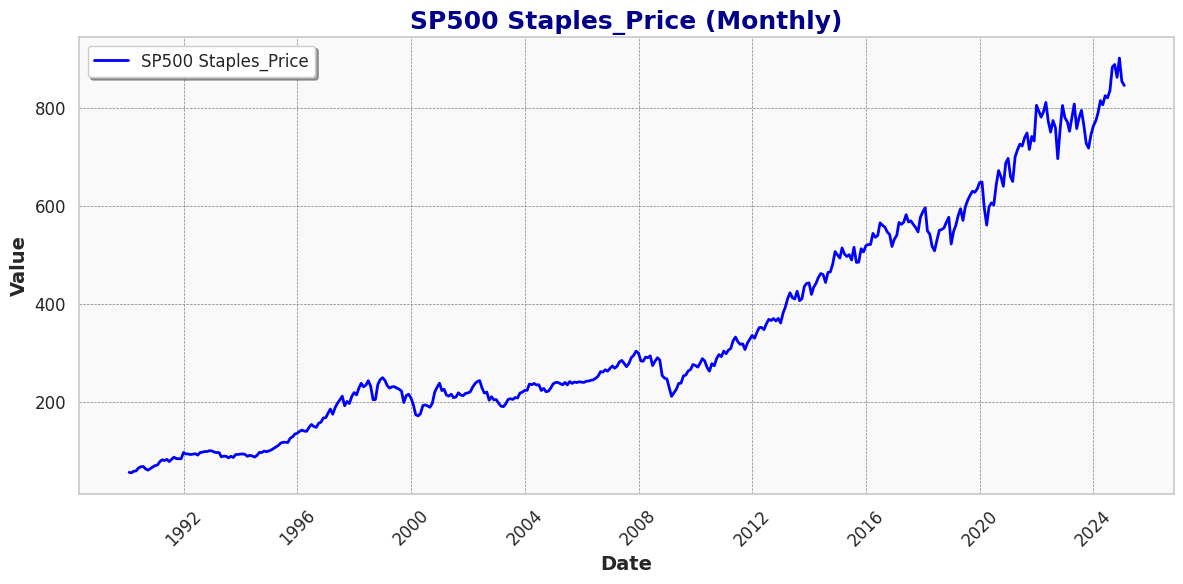

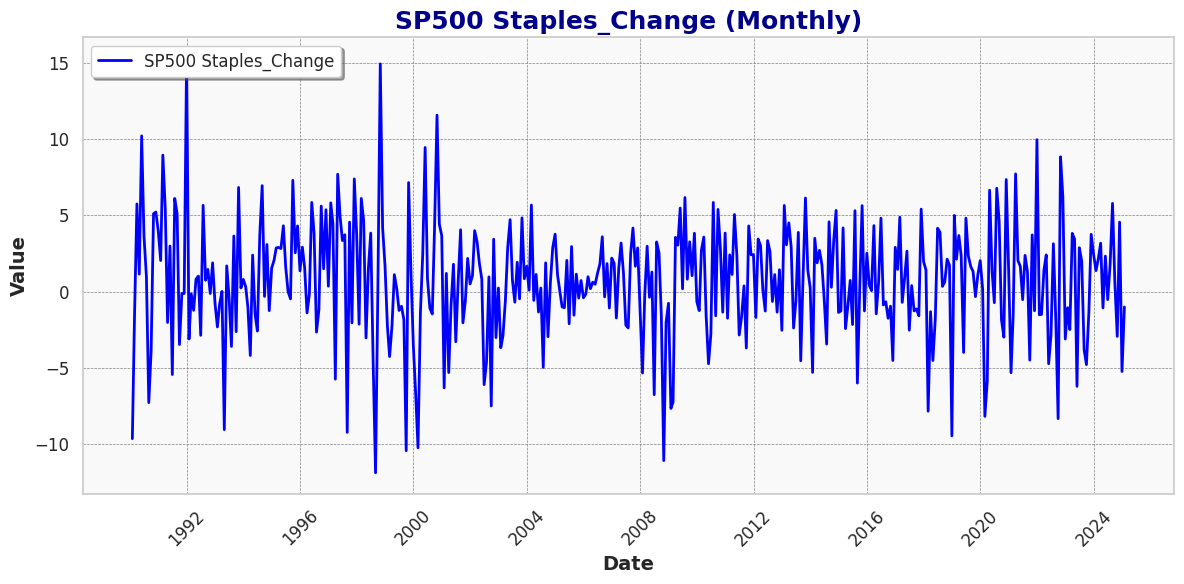

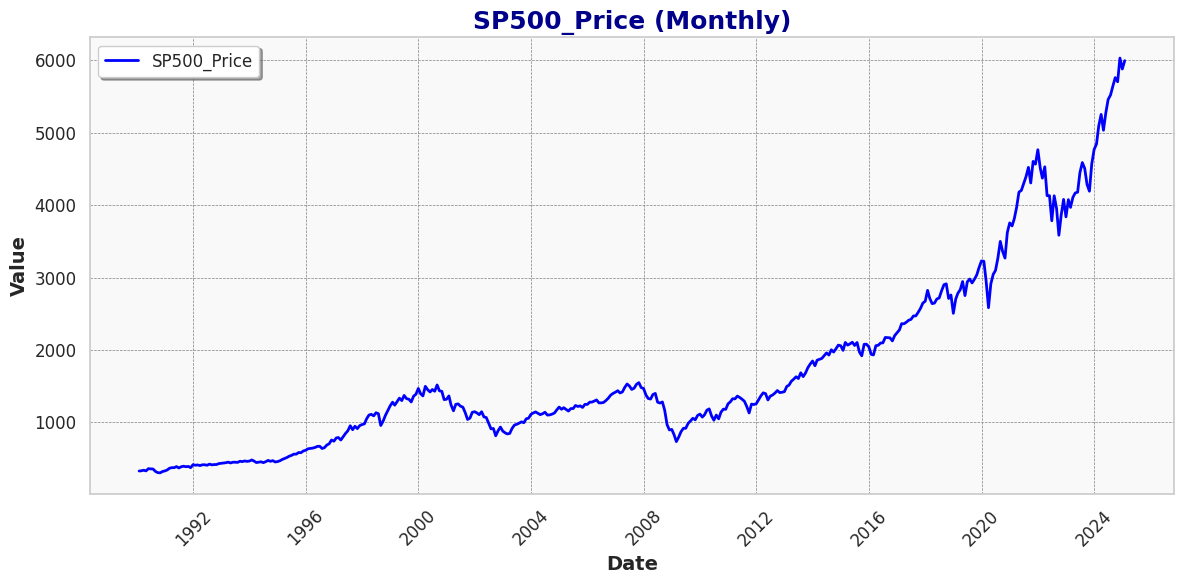

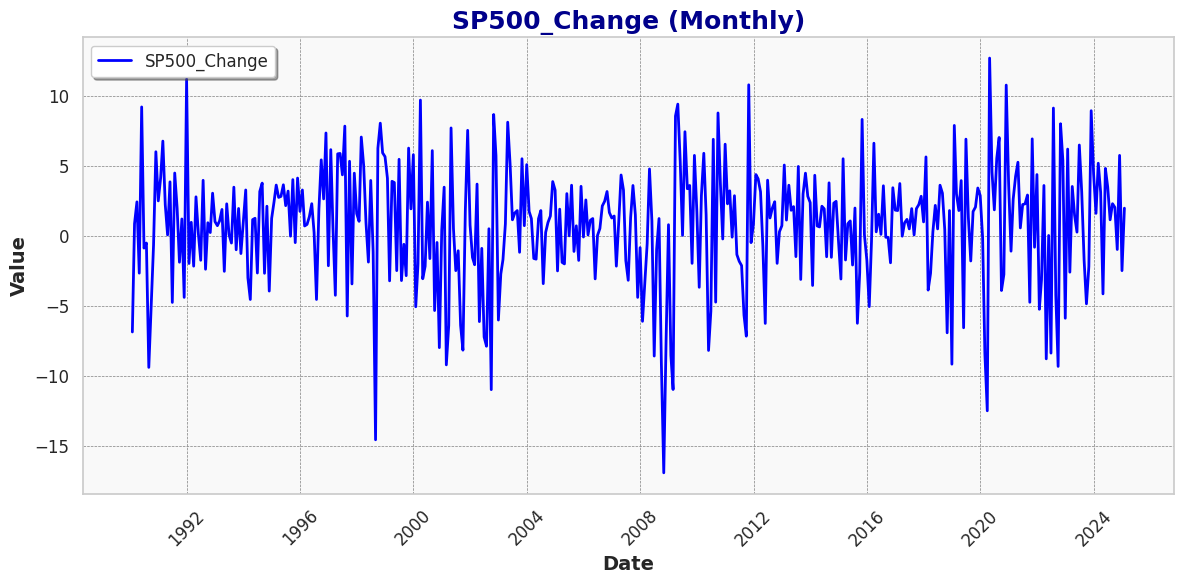

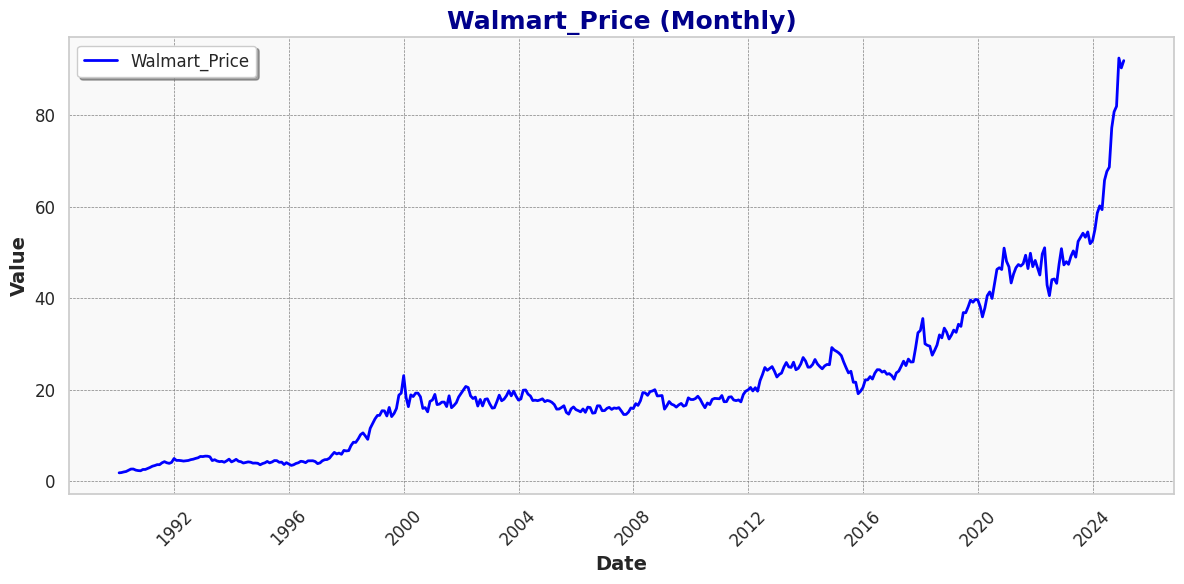

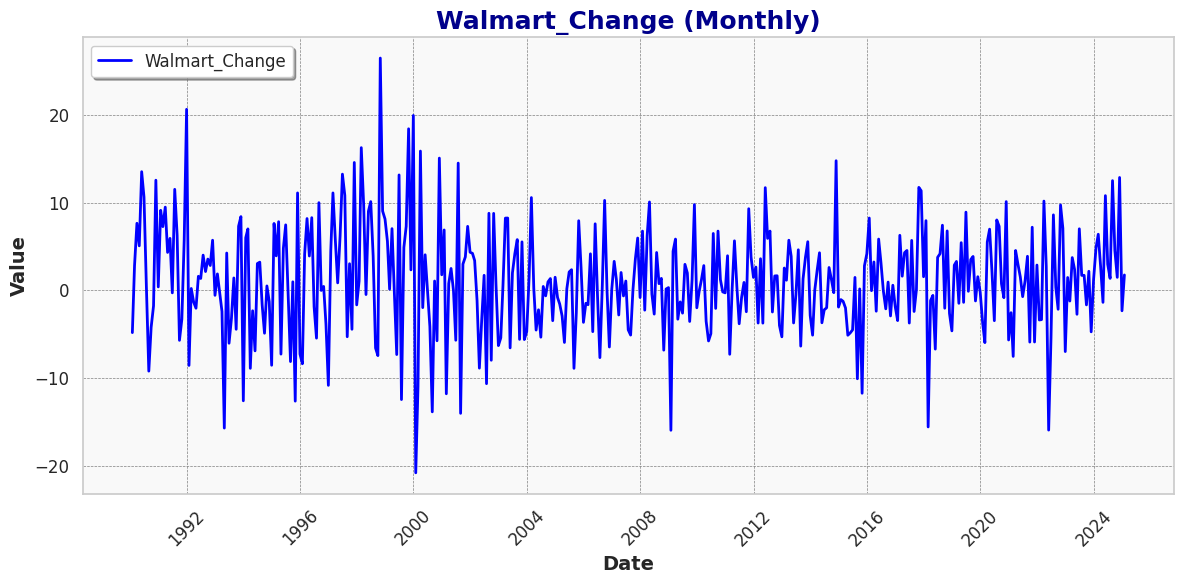

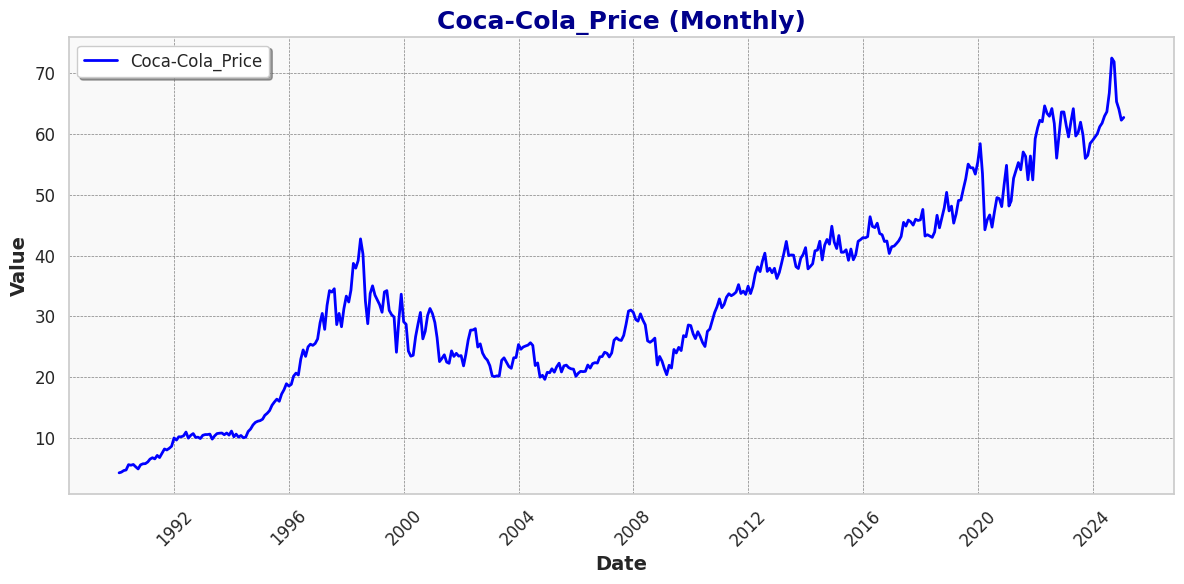

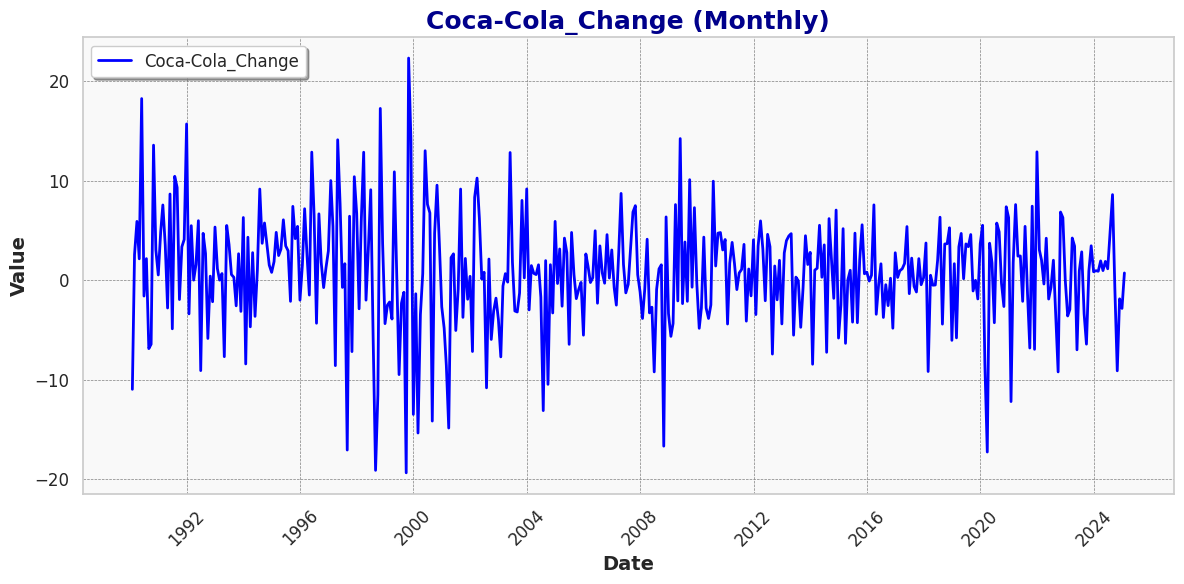

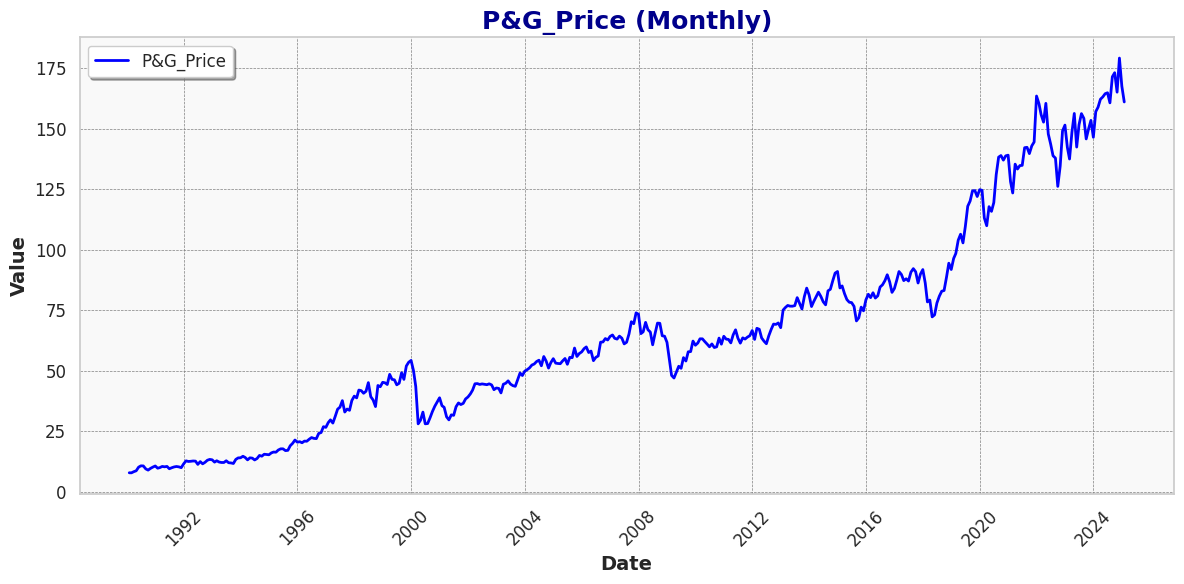

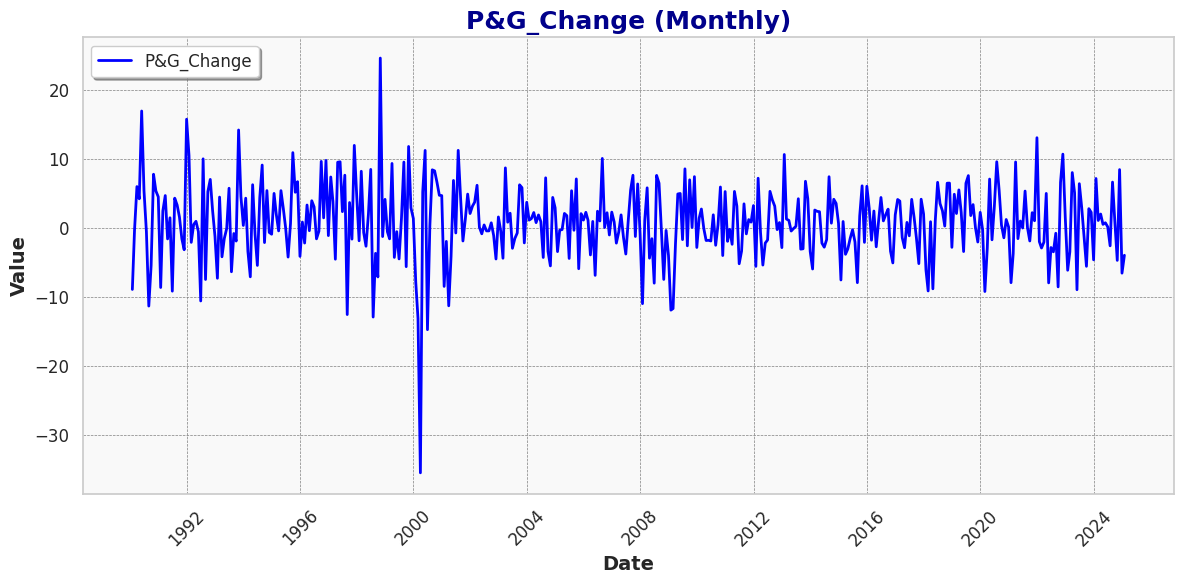

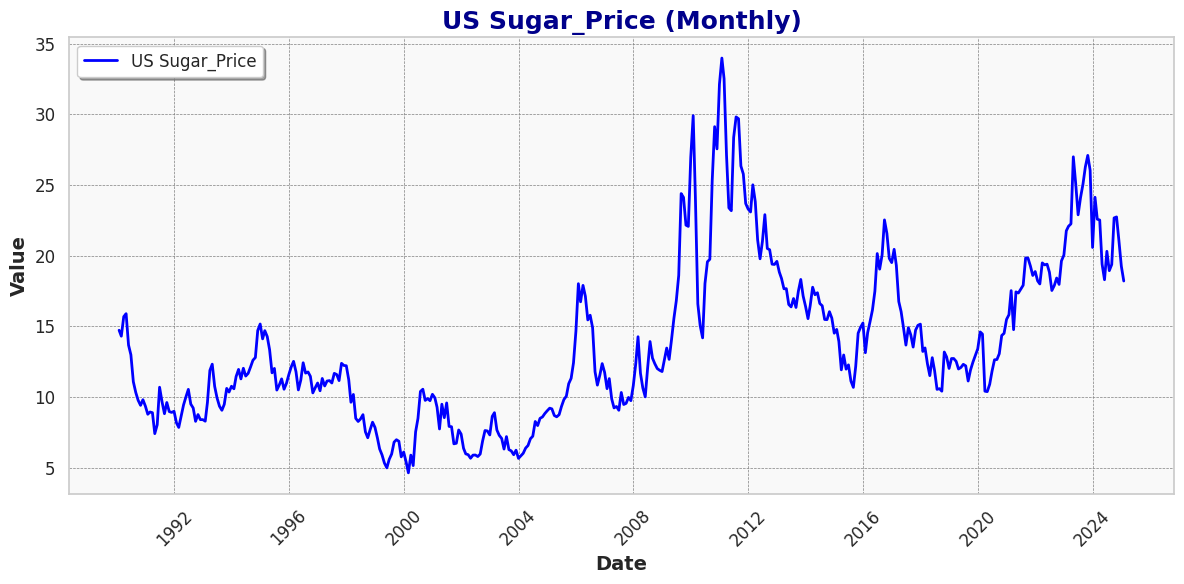

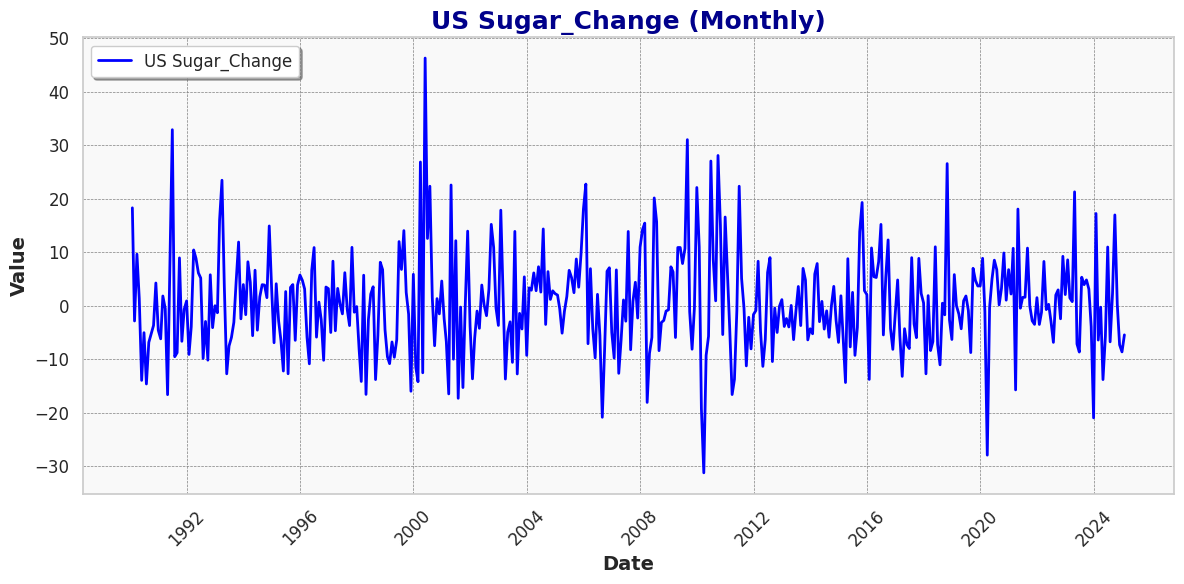

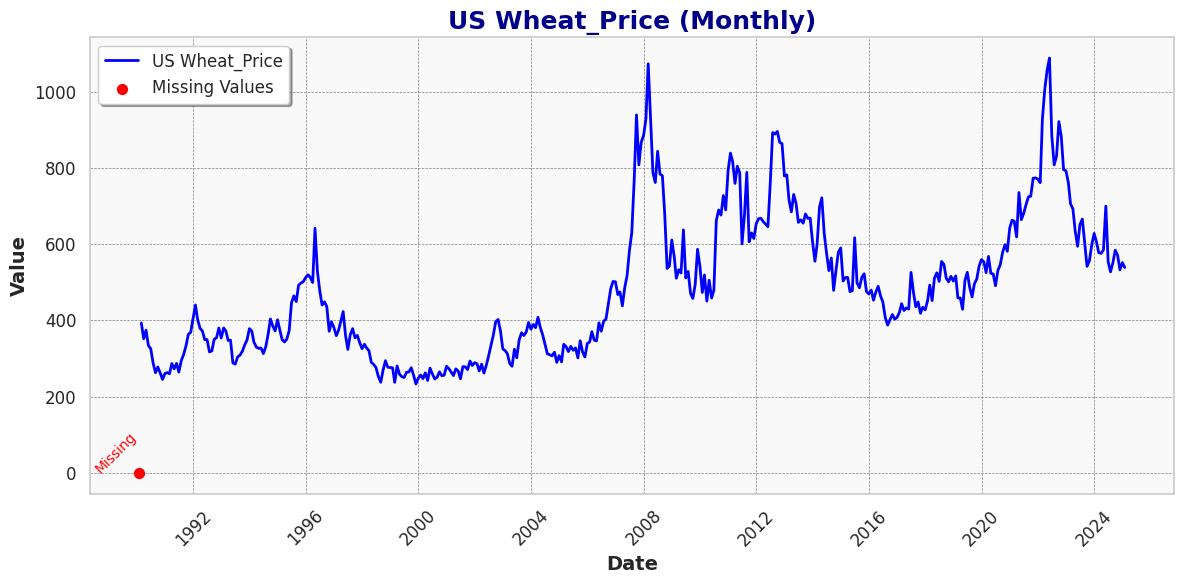

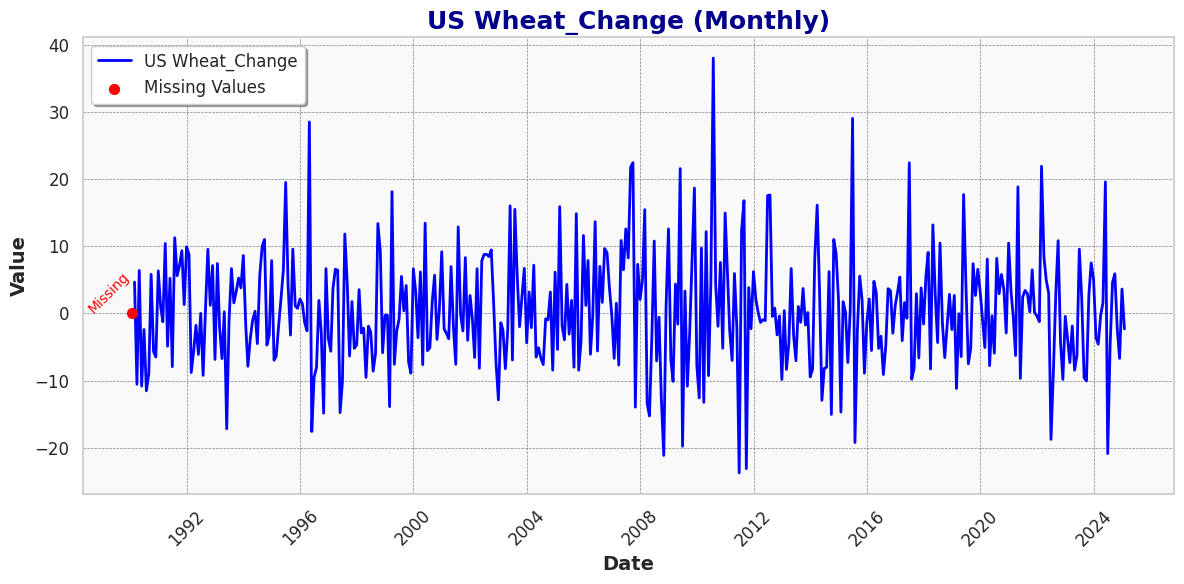

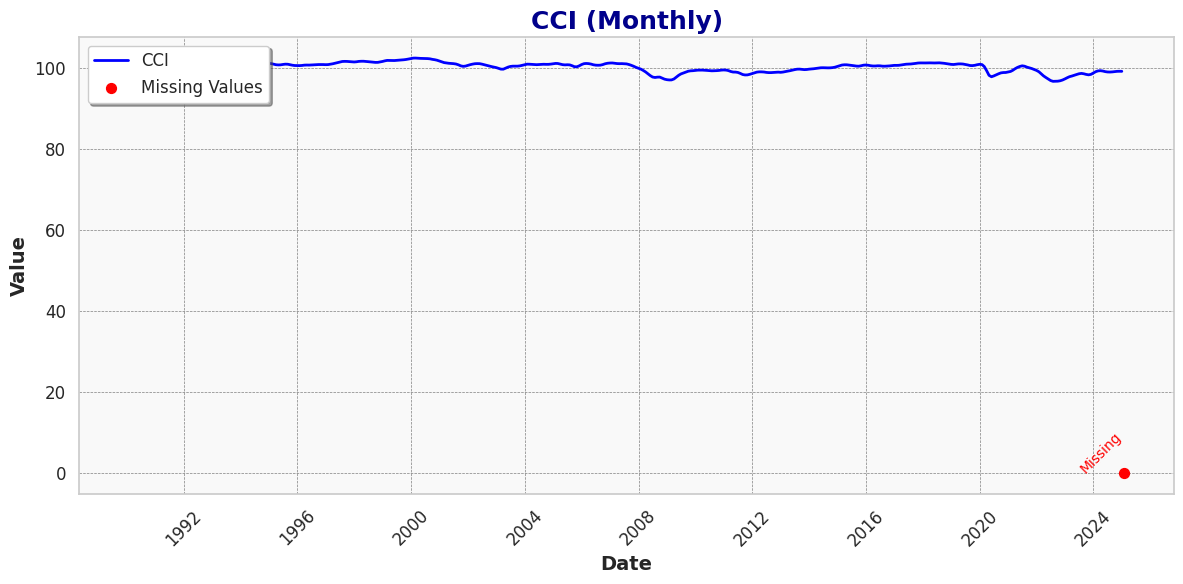

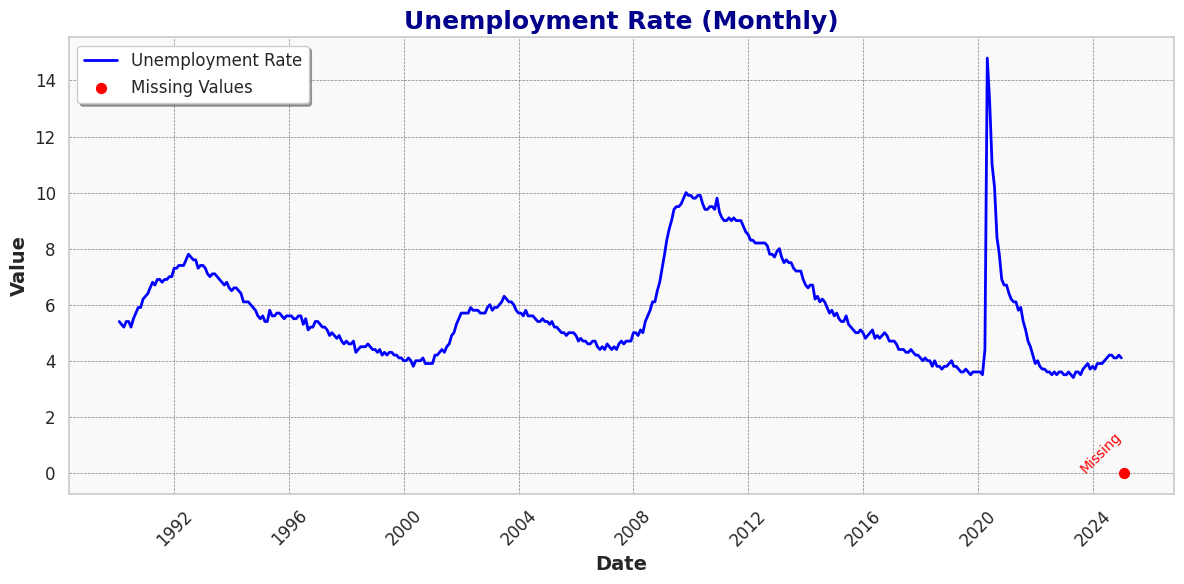

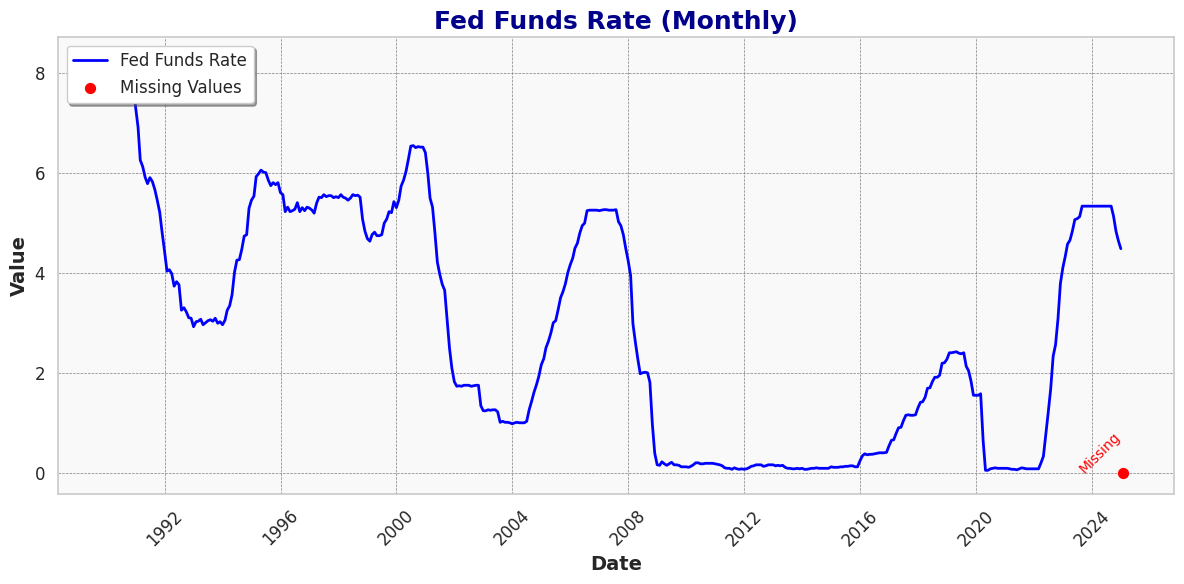

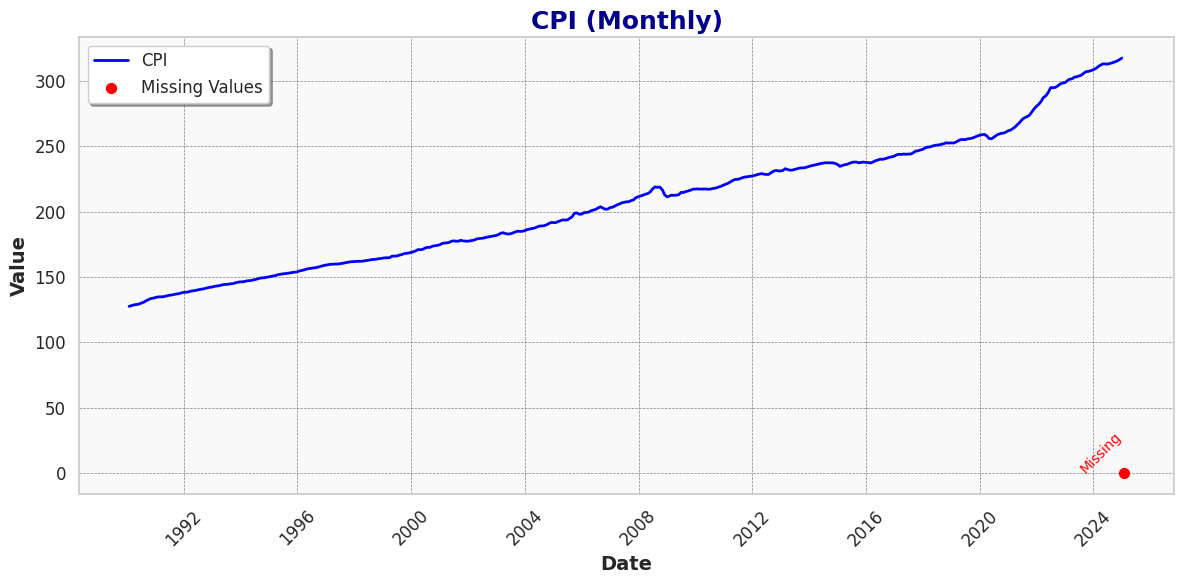

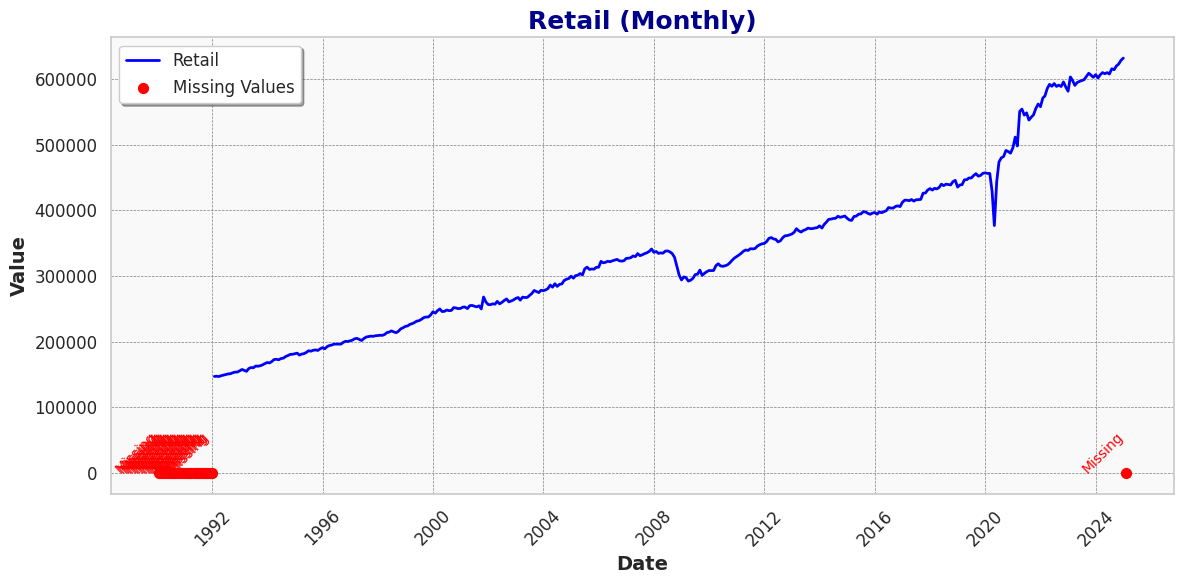

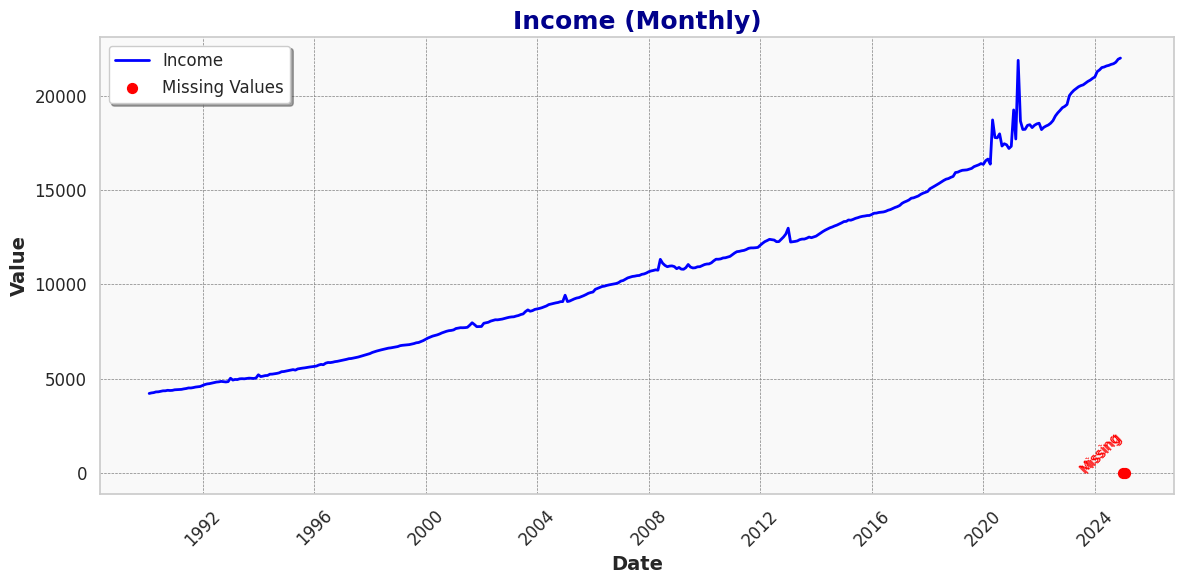

In [ ]:
# Set a theme
sns.set_theme(style="whitegrid")

# Resample the DataFrame to a monthly frequency
df_monthly = df.set_index('Date').resample('ME').first()

# Filter only monthly columns
monthly_columns = [col for col, interval in intervals.items() if interval == "Monthly"]

# Create individual plots for each monthly column
for col in monthly_columns:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the column values without dots (markers)
    ax.plot(df_monthly.index, df_monthly[col], label=col, color='blue', linestyle='-', linewidth=2)

    # Highlight missing values
    missing_mask = df_monthly[col].isnull()
    if missing_mask.any():
        ax.scatter(df_monthly.index[missing_mask], [0]*missing_mask.sum(),
                   color='red', label="Missing Values", s=50, zorder=3)
        # Annotate missing values
        for idx in df_monthly.index[missing_mask]:
            ax.text(idx, 0, 'Missing', color='red', fontsize=10, rotation=45, ha='right')

    # Format the title and labels
    ax.set_title(f'{col} (Monthly)', fontsize=18, fontweight='bold', color='darkblue')
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Value', fontsize=14, fontweight='bold')

    # Customize the legend
    ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)

    # Customize tick labels for clarity
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)

    # Add gridlines for better readability
    ax.grid(visible=True, which='major', linestyle='--', linewidth=0.5, color='gray')

    # Add a light background for the plot area
    ax.set_facecolor('#f9f9f9')

    # Show the plot
    plt.tight_layout()
    plt.show()


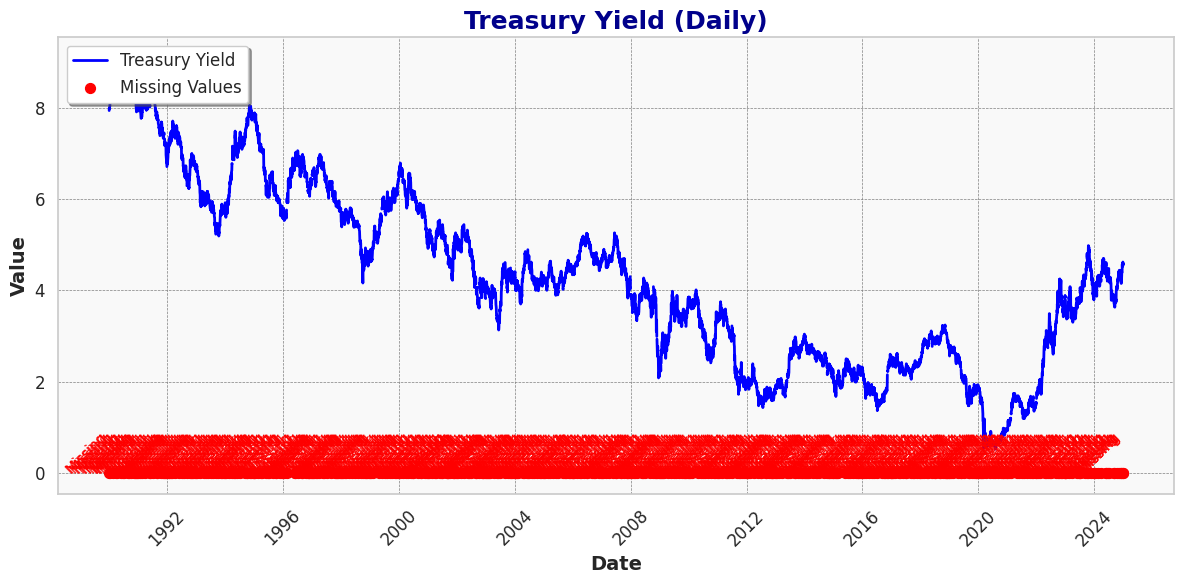

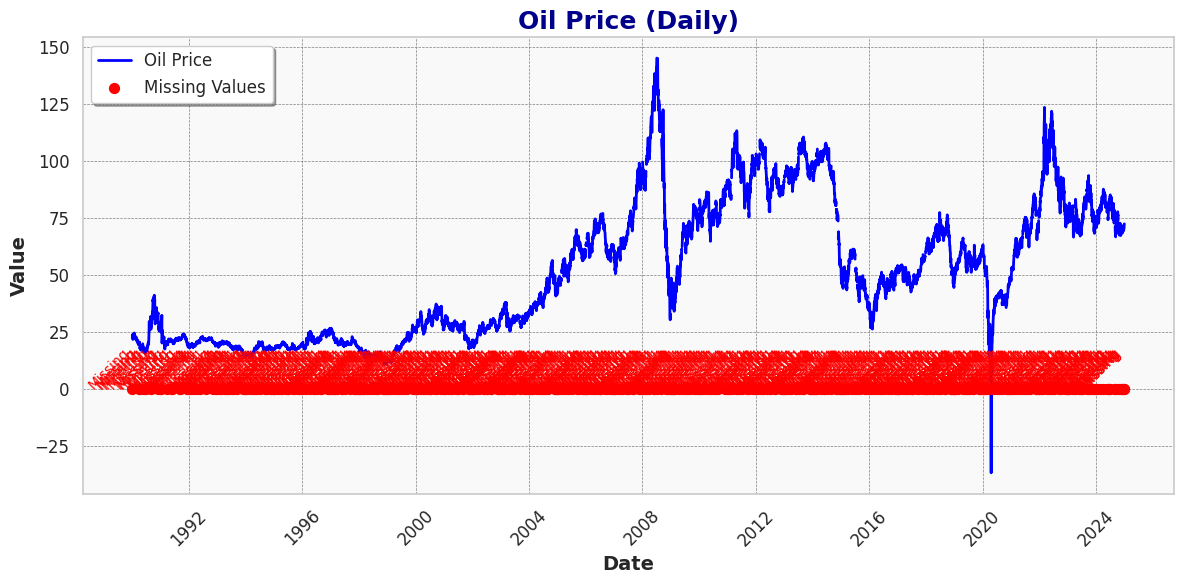

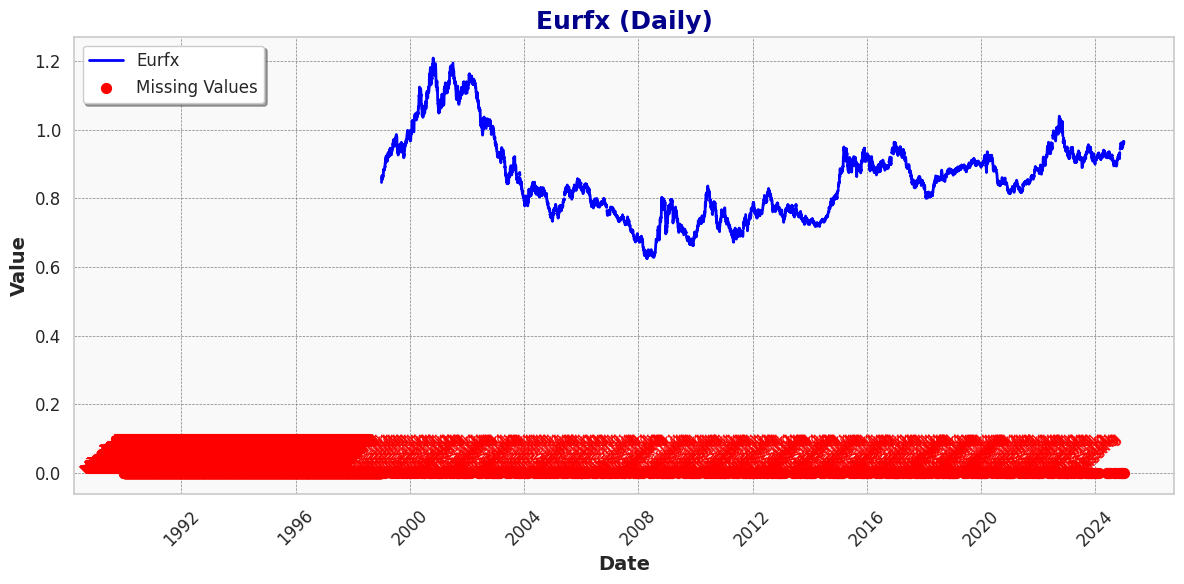

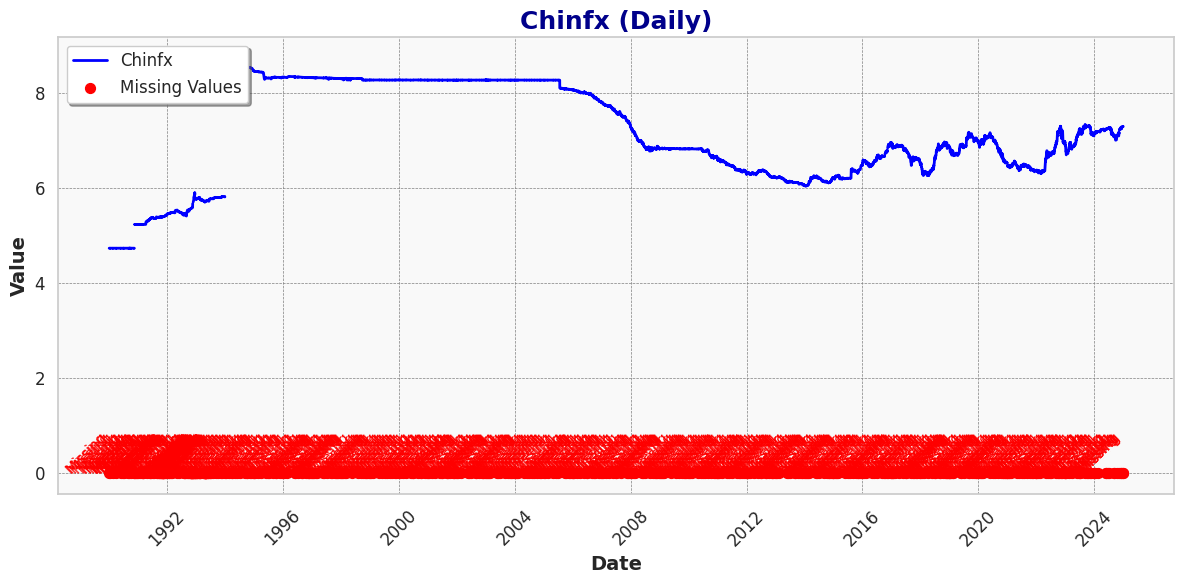

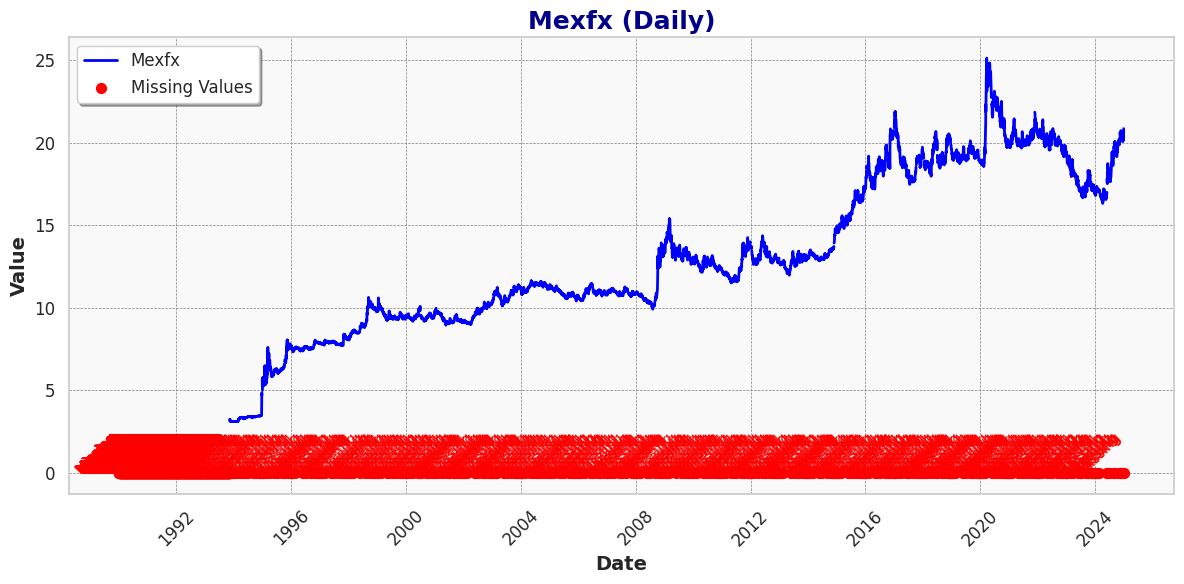

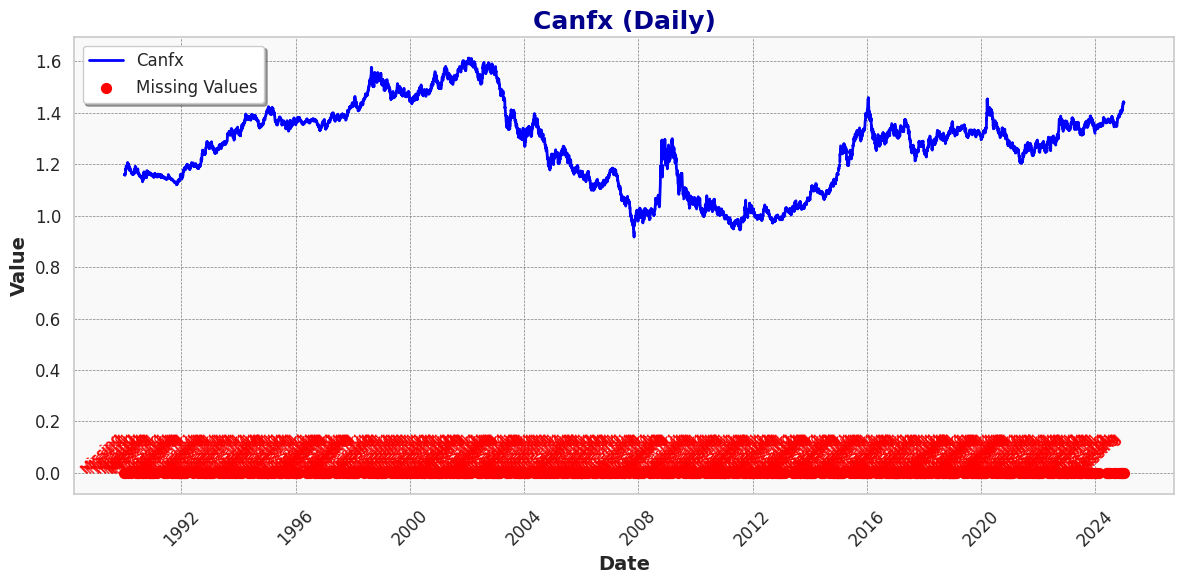

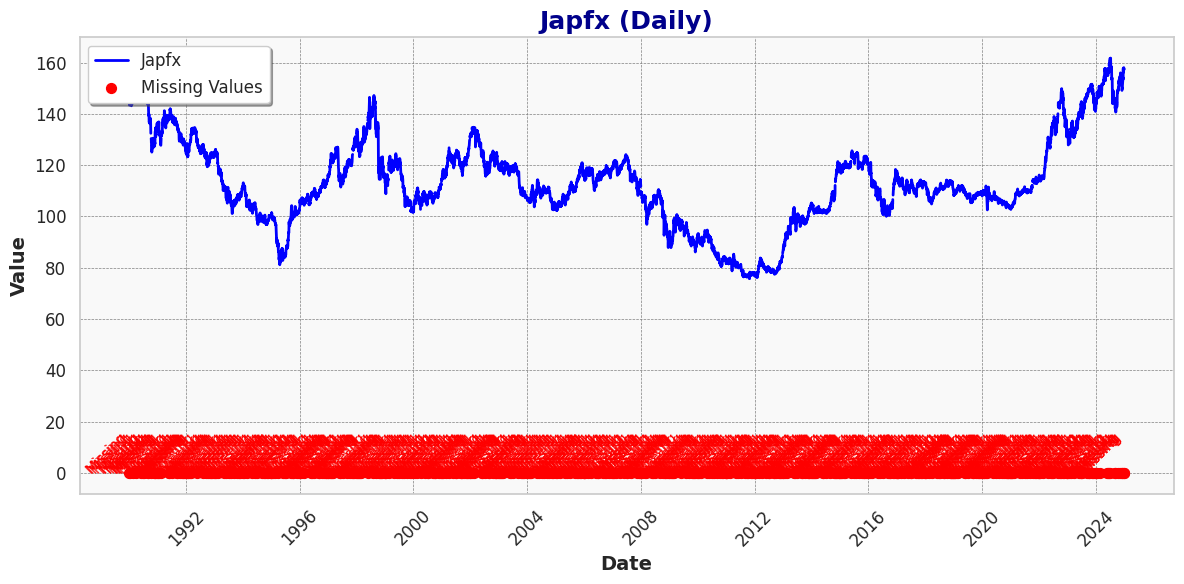

In [ ]:
# Filter only daily columns
daily_columns = [col for col, interval in intervals.items() if interval == "Daily"]

# Create individual plots for each daily column
for col in daily_columns:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the column values without dots (markers)
    ax.plot(df.set_index('Date').index, df[col], label=col, color='blue', linestyle='-', linewidth=2)

    # Highlight missing values
    missing_mask = df[col].isnull()
    if missing_mask.any():
        ax.scatter(df.set_index('Date').index[missing_mask], [0]*missing_mask.sum(),
                   color='red', label="Missing Values", s=50, zorder=3)
        # Annotate missing values
        for idx in df.set_index('Date').index[missing_mask]:
            ax.text(idx, 0, 'Missing', color='red', fontsize=10, rotation=45, ha='right')

    # Format the title and labels
    ax.set_title(f'{col} (Daily)', fontsize=18, fontweight='bold', color='darkblue')
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Value', fontsize=14, fontweight='bold')

    # Customize the legend
    ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)

    # Customize tick labels for clarity
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)

    # Add gridlines for better readability
    ax.grid(visible=True, which='major', linestyle='--', linewidth=0.5, color='gray')

    # Add a light background for the plot area
    ax.set_facecolor('#f9f9f9')

    # Show the plot
    plt.tight_layout()
    plt.show()


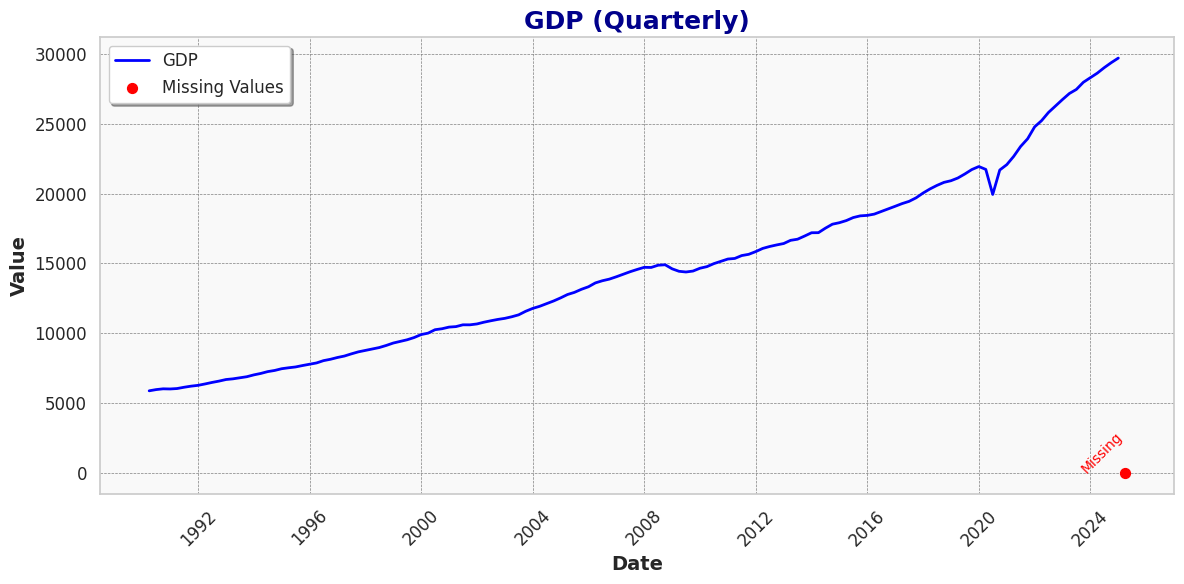

In [ ]:
# Filter only quarterly columns
quarterly_columns = [col for col, interval in intervals.items() if interval == "Quarterly"]

# Resample the DataFrame to a quarterly frequency
df_quarterly = df.set_index('Date').resample('QE').first()

# Create individual plots for each quarterly column
for col in quarterly_columns:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the column values without dots (markers)
    ax.plot(df_quarterly.index, df_quarterly[col], label=col, color='blue', linestyle='-', linewidth=2)

    # Highlight missing values
    missing_mask = df_quarterly[col].isnull()
    if missing_mask.any():
        ax.scatter(df_quarterly.index[missing_mask], [0]*missing_mask.sum(),
                   color='red', label="Missing Values", s=50, zorder=3)
        # Annotate missing values
        for idx in df_quarterly.index[missing_mask]:
            ax.text(idx, 0, 'Missing', color='red', fontsize=10, rotation=45, ha='right')

    # Format the title and labels
    ax.set_title(f'{col} (Quarterly)', fontsize=18, fontweight='bold', color='darkblue')
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Value', fontsize=14, fontweight='bold')

    # Customize the legend
    ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)

    # Customize tick labels for clarity
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)

    # Add gridlines for better readability
    ax.grid(visible=True, which='major', linestyle='--', linewidth=0.5, color='gray')

    # Add a light background for the plot area
    ax.set_facecolor('#f9f9f9')

    # Show the plot
    plt.tight_layout()
    plt.show()


### Handeling Missing Values:

We fill the missing values using appropraite methods based on the displayed patterns of the data:

- To transfer GDP from a quaterly to a monthly interval we use linear interpolation as it shows a smooth upward trend

- For Treasury Yield, Oil Prices, and Japfx we use stochastic modeling, specifically the Kalman filter technique, due to the severe turbulation of these values. Stochastic modeling is a way to understand data that changes randomly over time. The Kalman filter is a tool that helps estimate the true value of something by combining messy, real-world data with predictions from a model. It updates these estimates step by step as new data comes in, improving accuracy by accounting for errors and uncertainty.

- For the remaining exchange rates we use linear interpolation as they show steady trends, flat periods and only minor fluctuations

In [ ]:
# GDP interpolation
# Ensure 'Date' is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df = df.set_index('Date')

# Create a temporary DataFrame for resampling and interpolation
temp_gdp = df['GDP'].resample('MS').interpolate(method='linear')

# Update only NaN values in the original GDP column with the interpolated values
df['GDP'] = df['GDP'].combine_first(temp_gdp)

# Reset the index to make 'Date' a column again
df = df.reset_index()

# Display only rows with numerical GDP values along with the corresponding Date column
gdp_with_dates = df[['Date', 'GDP']].dropna().reset_index(drop=True)
display(gdp_with_dates)

Date           GDP
0   1990-01-01   5872.701000
1   1990-02-01   5901.810000
2   1990-03-01   5930.919000
3   1990-04-01   5960.028000
4   1990-05-01   5978.390667
..         ...           ...
416 2024-09-01  29592.024667
417 2024-10-01  29700.580000
418 2024-11-01  29700.580000
419 2024-12-01  29700.580000
420 2025-01-01  29700.580000

[421 rows x 2 columns]

Missing values after imputation: 0


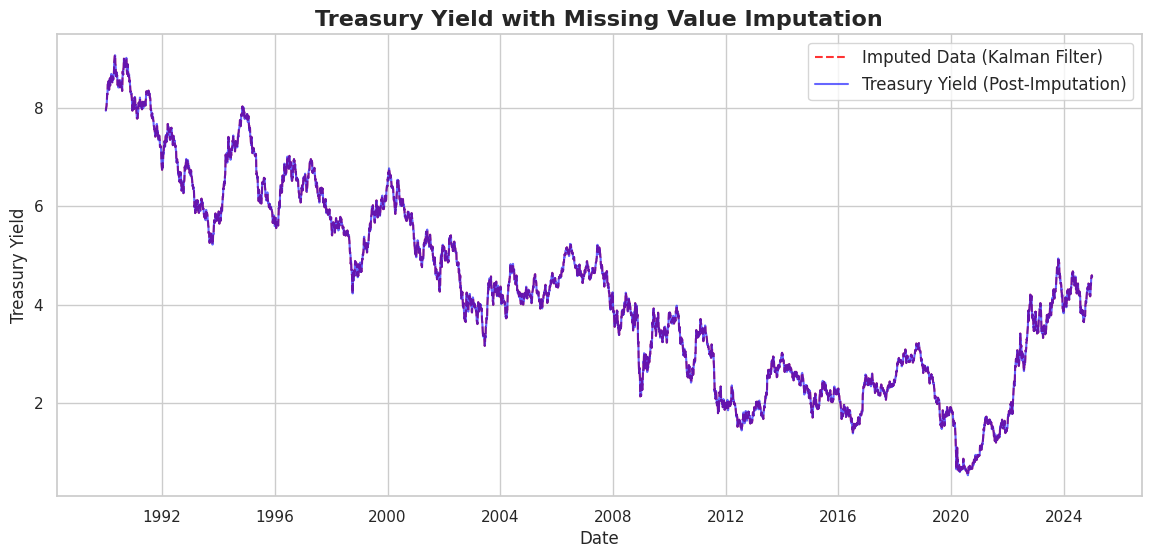

In [ ]:
# Treasury Yield using stochastic modelling
# Mask missing values for Kalman Filter
observed_data = np.ma.masked_invalid(df['Treasury Yield'].values)

# Set up the Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Fit the Kalman Filter model
kf = kf.em(observed_data, n_iter=10)

# Impute missing values
imputed_values, _ = kf.smooth(observed_data)

# Directly replace NaN values in the original column with imputed values
df['Treasury Yield'] = np.where(np.isnan(df['Treasury Yield']), imputed_values, df['Treasury Yield'])

# Display missing data stats after imputation
missing_values_after_imputation = df['Treasury Yield'].isnull().sum()
print("Missing values after imputation:", missing_values_after_imputation)

# Plot original vs imputed data
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], imputed_values, label='Imputed Data (Kalman Filter)', color='red', linestyle='--', alpha=0.8)
plt.plot(df['Date'], df['Treasury Yield'], label='Treasury Yield (Post-Imputation)', color='blue', alpha=0.6)
plt.title('Treasury Yield with Missing Value Imputation', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Treasury Yield', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Missing values after imputation: 0


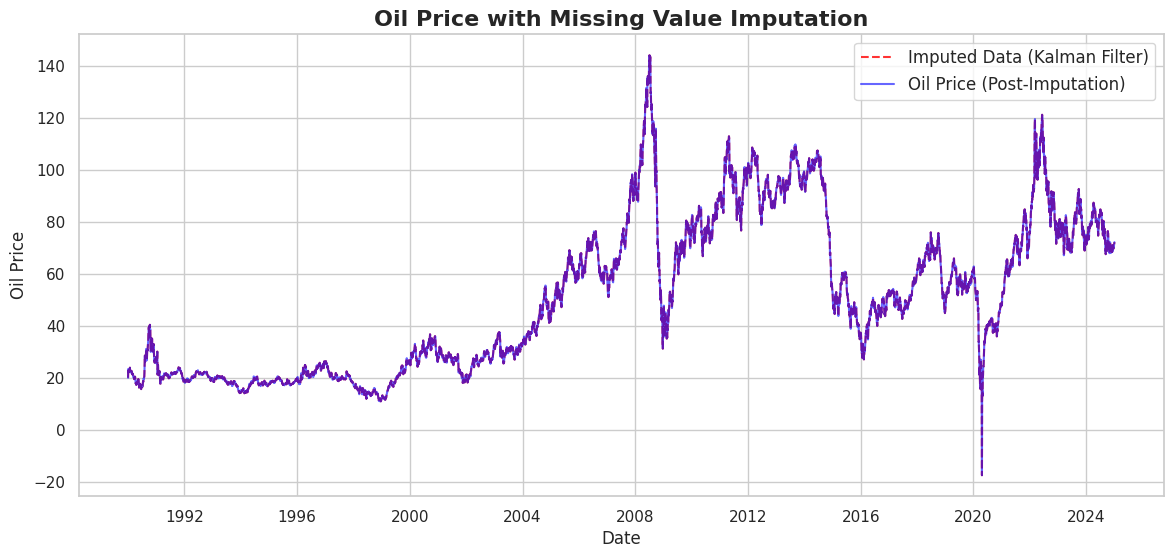

In [ ]:
# Oil Price using stochastic modeling
# Mask missing values for Kalman Filter
observed_data = np.ma.masked_invalid(df['Oil Price'].values)

# Set up the Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Fit the Kalman Filter model
kf = kf.em(observed_data, n_iter=10)

# Impute missing values
imputed_values, _ = kf.smooth(observed_data)

# Directly replace NaN values in the original column with imputed values
df['Oil Price'] = np.where(np.isnan(df['Oil Price']), imputed_values, df['Oil Price'])

# Display missing data stats after imputation
missing_values_after_imputation = df['Oil Price'].isnull().sum()
print("Missing values after imputation:", missing_values_after_imputation)

# Plot original vs imputed data
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], imputed_values, label='Imputed Data (Kalman Filter)', color='red', linestyle='--', alpha=0.8)
plt.plot(df['Date'], df['Oil Price'], label='Oil Price (Post-Imputation)', color='blue', alpha=0.6)
plt.title('Oil Price with Missing Value Imputation', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Oil Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Missing values after imputation: 0


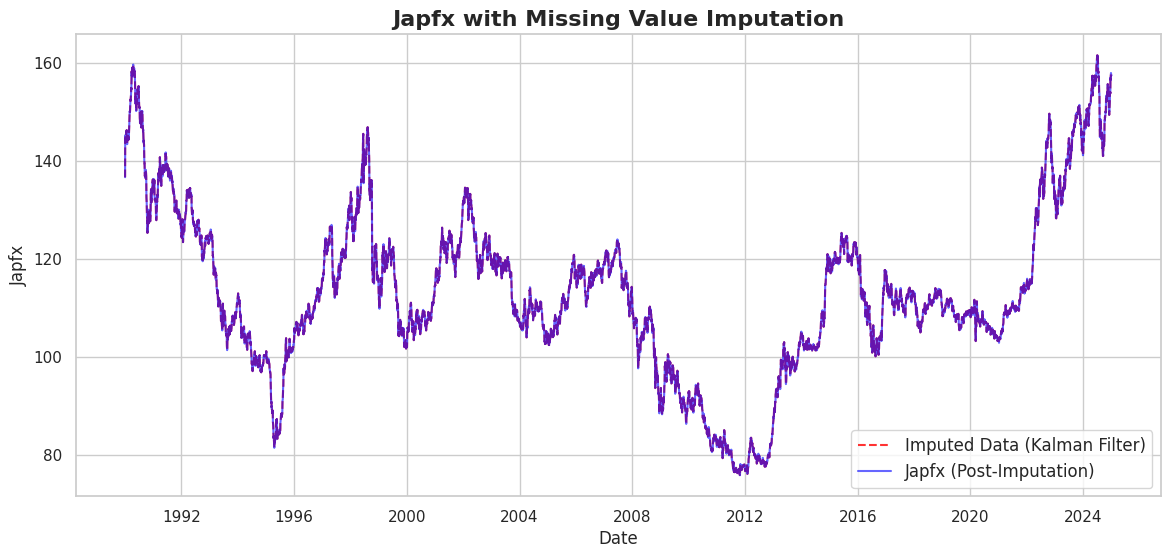

In [ ]:
# Japfx using stochastic modeling
# Mask missing values for Kalman Filter
observed_data = np.ma.masked_invalid(df['Japfx'].values)

# Set up the Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Fit the Kalman Filter model
kf = kf.em(observed_data, n_iter=10)

# Impute missing values
imputed_values, _ = kf.smooth(observed_data)

# Directly replace NaN values in the original column with imputed values
df['Japfx'] = np.where(np.isnan(df['Japfx']), imputed_values, df['Japfx'])

# Display missing data stats after imputation
missing_values_after_imputation = df['Japfx'].isnull().sum()
print("Missing values after imputation:", missing_values_after_imputation)

# Plot original vs imputed data
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], imputed_values, label='Imputed Data (Kalman Filter)', color='red', linestyle='--', alpha=0.8)
plt.plot(df['Date'], df['Japfx'], label='Japfx (Post-Imputation)', color='blue', alpha=0.6)
plt.title('Japfx with Missing Value Imputation', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Japfx', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
# Remaining columns
# Columns to interpolate
columns_to_interpolate = ['Eurfx', 'Chinfx', 'Mexfx', 'Canfx']

# Perform linear interpolation for each column in df
for column in columns_to_interpolate:
    if column in df.columns:
        # Perform linear interpolation
        df[column] = df[column].interpolate(method='linear')
        # Print the number of missing values after interpolation
        print(f"Missing values in {column} after interpolation: {df[column].isnull().sum()}")

# Display the updated DataFrame to check the changes
display(df[['Date'] + columns_to_interpolate])


Missing values in Eurfx after interpolation: 2381
Missing values in Chinfx after interpolation: 1
Missing values in Mexfx after interpolation: 1018
Missing values in Canfx after interpolation: 1


Date     Eurfx  Chinfx    Mexfx   Canfx
0    1990-01-01       NaN     NaN      NaN     NaN
1    1990-01-02       NaN  4.7339      NaN  1.1605
2    1990-01-03       NaN  4.7339      NaN  1.1613
3    1990-01-04       NaN  4.7339      NaN  1.1614
4    1990-01-05       NaN  4.7339      NaN  1.1600
...         ...       ...     ...      ...     ...
9247 2024-12-26  0.959417  7.2981  20.1750  1.4404
9248 2024-12-27  0.959417  7.2980  20.2220  1.4433
9249 2024-12-30  0.962835  7.2993  20.5460  1.4374
9250 2024-12-31  0.966090  7.2993  20.8557  1.4400
9251 2025-01-01  0.966090  7.2993  20.8557  1.4400

[9252 rows x 5 columns]

In [ ]:
# As the euro was introduced around 2000 we miss 10 years of values,
# which is why we choose to delete Eurfx

# The Mexfx misses about 4 years of data.
correlation_data = df[['Mexfx', 'GDP', 'CPI']]
correlation_matrix = correlation_data.corr()
print(correlation_matrix)

# The correlation matrix shows
# high correlation with gdp and cpi, which is why we choose to delete Mexfx

df = df.drop(columns=['Mexfx', 'Eurfx'])

          Mexfx       GDP       CPI
Mexfx  1.000000  0.899313  0.893922
GDP    0.899313  1.000000  0.994807
CPI    0.893922  0.994807  1.000000


In [ ]:
display(df)

Date  SP500 Staples_Price  SP500 Staples_Change  SP500_Price  \
0    1990-01-01                56.33                 -9.64       329.10   
1    1990-01-02                  NaN                   NaN          NaN   
2    1990-01-03                  NaN                   NaN          NaN   
3    1990-01-04                  NaN                   NaN          NaN   
4    1990-01-05                  NaN                   NaN          NaN   
...         ...                  ...                   ...          ...   
9247 2024-12-26                  NaN                   NaN          NaN   
9248 2024-12-27                  NaN                   NaN          NaN   
9249 2024-12-30                  NaN                   NaN          NaN   
9250 2024-12-31                  NaN                   NaN          NaN   
9251 2025-01-01               845.02                 -1.01      5996.71   

      SP500_Change  Walmart_Price  Walmart_Change  Coca-Cola_Price  \
0            -6.88           1.78           -4.81             4.30   
1              NaN            NaN             NaN              NaN   
2              NaN            NaN             NaN              NaN   
3              NaN            NaN             NaN              NaN   
4              NaN            NaN             NaN              NaN   
...            ...            ...             ...              ...   
9247           NaN            NaN             NaN              NaN   
9248           NaN            NaN             NaN              NaN   
9249           NaN            NaN             NaN              NaN   
9250           NaN            NaN             NaN              NaN   
9251          1.96          91.94            1.76            62.71   

      Coca-Cola_Change  P&G_Price  ...  Unemployment Rate  Fed Funds Rate  \
0               -10.97       7.94  ...                5.4            8.23   
1                  NaN        NaN  ...                NaN             NaN   
2                  NaN        NaN  ...                NaN             NaN   
3                  NaN        NaN  ...                NaN             NaN   
4                  NaN        NaN  ...                NaN             NaN   
...                ...        ...  ...                ...             ...   
9247               NaN        NaN  ...                NaN             NaN   
9248               NaN        NaN  ...                NaN             NaN   
9249               NaN        NaN  ...                NaN             NaN   
9250               NaN        NaN  ...                NaN             NaN   
9251              0.72     161.13  ...                NaN             NaN   

        CPI  Treasury Yield  Oil Price  Chinfx   Canfx       Japfx  Retail  \
0     127.5        7.940661  19.995285     NaN     NaN  136.634890     NaN   
1       NaN        7.950383  22.351004  4.7339  1.1605  144.282029     NaN   
2       NaN        7.977336  23.372080  4.7339  1.1613  145.090104     NaN   
3       NaN        7.983271  23.288298  4.7339  1.1614  143.778678     NaN   
4       NaN        7.994636  22.897464  4.7339  1.1600  143.887484     NaN   
...     ...             ...        ...     ...     ...         ...     ...   
9247    NaN        4.586147  70.616379  7.2981  1.4404  157.872330     NaN   
9248    NaN        4.597099  71.233388  7.2980  1.4433  157.688010     NaN   
9249    NaN        4.570045  71.732796  7.2993  1.4374  157.357764     NaN   
9250    NaN        4.576257  72.239259  7.2993  1.4400  157.367266     NaN   
9251    NaN        4.576257  72.239259  7.2993  1.4400  157.367266     NaN   

      Income  
0     4208.4  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
9247     NaN  
9248     NaN  
9249     NaN  
9250     NaN  
9251     NaN  

[9252 rows x 27 columns]

In [ ]:
# For 'Treasury Yield', 'Oil Price', 'Chinfx', 'Mexfx', 'Canfx', 'Japfx', we have daily values.
# We want to use monthly mean values to smooth out daily noise and focus on the broader trends that matter for predicting future indices.
# Since the goal is to forecast 1, 2, and 4 quarters ahead, monthly data aligns better with these timeframes and simplifies the analysis.
# Shifting the values to the first day of the next month ensures that we’re only using information available at the time of prediction,
# keeping it realistic. This approach makes the data cleaner, easier to work with, and more relevant for the forecast.

# List of variables to compute shifted monthly means
variables = ['Treasury Yield', 'Oil Price', 'Chinfx', 'Canfx', 'Japfx']

# Set 'Date' as the index before resampling
df = df.set_index('Date')

# Create shifted means for each variable and delete the original columns
for variable in variables:
    if variable in df.columns:
        # Calculate monthly mean
        monthly_mean = df[variable].resample('ME').mean()
        # Shift the monthly mean to the first day of the next month
        shifted_monthly_mean = monthly_mean.shift(1)
        # Assign the shifted mean to the daily data, propagating it for all days in the following month
        df[f'{variable} Previous Month Mean'] = shifted_monthly_mean.resample('D').ffill()
        # Delete the original column
        df = df.drop(columns=[variable])

# Reset the index back to RangeIndex if needed
df = df.reset_index()

# Filter data to only keep the first day of each month
df = df[df['Date'].dt.day == 1].reset_index(drop=True)

# Delete all rows before 1992-01-01
df = df[df['Date'] >= '1992-01-01'].reset_index(drop=True)

df


Date  SP500 Staples_Price  SP500 Staples_Change  SP500_Price  \
0   1992-01-01                93.95                 -3.11       408.80   
1   1992-02-01                93.81                 -0.15       412.70   
2   1992-03-01                92.66                 -1.23       403.70   
3   1992-04-01                93.40                  0.80       414.90   
4   1992-05-01                94.34                  1.01       415.40   
..         ...                  ...                   ...          ...   
392 2024-09-01               887.78                  0.59      5762.48   
393 2024-10-01               861.70                 -2.94      5705.45   
394 2024-11-01               900.88                  4.55      6032.38   
395 2024-12-01               853.65                 -5.24      5881.63   
396 2025-01-01               845.02                 -1.01      5996.71   

     SP500_Change  Walmart_Price  Walmart_Change  Coca-Cola_Price  \
0           -1.99           4.49           -8.55             9.69   
1            0.95           4.50            0.22            10.22   
2           -2.18           4.44           -1.33            10.22   
3            2.77           4.35           -2.03            10.38   
4            0.12           4.42            1.61            11.00   
..            ...            ...             ...              ...   
392          2.02          80.75            4.56            71.86   
393         -0.99          81.95            1.49            65.31   
394          5.73          92.50           12.87            64.08   
395         -2.50          90.35           -2.32            62.26   
396          1.96          91.94            1.76            62.71   

     Coca-Cola_Change  P&G_Price  ...  Unemployment Rate  Fed Funds Rate  \
0               -3.39      12.87  ...                7.3            4.03   
1                5.47      12.61  ...                7.4            4.06   
2                0.00      12.68  ...                7.4            3.98   
3                1.57      12.81  ...                7.4            3.73   
4                5.97      12.75  ...                7.6            3.82   
..                ...        ...  ...                ...             ...   
392             -0.84     173.20  ...                4.1            5.13   
393             -9.11     165.18  ...                4.1            4.83   
394             -1.88     179.26  ...                4.2            4.64   
395             -2.84     167.65  ...                4.1            4.48   
396              0.72     161.13  ...                NaN             NaN   

         CPI    Retail   Income  Treasury Yield Previous Month Mean  \
0    138.300  146925.0   4681.8                            7.414381   
1    138.600  147223.0   4713.9                            7.091262   
2    139.100  146805.0   4729.5                            7.022268   
3    139.400  148032.0   4755.6                            7.341833   
4    139.700  149010.0   4784.1                            7.531632   
..       ...       ...      ...                                 ...   
392  314.686  620104.0  21774.6                            4.248053   
393  315.454  623269.0  21934.0                            3.872944   
394  316.441  628727.0  21995.1                            3.735570   
395  317.685  632249.0      NaN                            4.095196   
396      NaN       NaN      NaN                            4.349219   

     Oil Price Previous Month Mean  Chinfx Previous Month Mean  \
0                        22.450674                    5.399119   
1                        19.541958                    5.422909   
2                        18.802240                    5.461407   
3                        19.008871                    5.477490   
4                        18.912397                    5.486948   
..                             ...                         ...   
392                      81.884873                    7.261285  

In [ ]:
# List of price columns to keep
price_columns_to_keep = ['SP500 Staples_Price']

# Get a list of all columns that look like prices (adjust the pattern if needed)
change_columns = [col for col in df.columns if '_Change' in col]

# Delete price columns except the ones to keep
change_delete = [col for col in change_columns]
df = df.drop(columns=change_delete)

In [ ]:
# Check if dataset shows no missing values
# Show count of missing values in merged data
print(df.isnull().sum())

Date                                  0
SP500 Staples_Price                   0
SP500_Price                           0
Walmart_Price                         0
Coca-Cola_Price                       0
P&G_Price                             0
US Sugar_Price                        0
US Wheat_Price                        0
CCI                                   1
GDP                                   0
Unemployment Rate                     1
Fed Funds Rate                        1
CPI                                   1
Retail                                1
Income                                2
Treasury Yield Previous Month Mean    0
Oil Price Previous Month Mean         0
Chinfx Previous Month Mean            0
Canfx Previous Month Mean             0
Japfx Previous Month Mean             0
dtype: int64


## Feature engineering
The data should be properly aligned with respect to time (i.e., the data should reflect what was known at each point in time).

- GDP data is published one month after each quater. But, we expect investors to estimate it monthly because it has a linear trend. This is why we lag the variable by one month.


- Unemployment Rate, Fed Funds Rate, CPI, Retail, Income and CCI are released a few days after the month. For simplicity we lag the variables by one month.

- Change and price rates are released daily so we do not have to lag them

In [ ]:
# List of columns to lag
columns_to_lag = ['GDP', 'Unemployment Rate', 'Fed Funds Rate', 'CPI', 'Retail', 'CCI', 'Income']

# Create lagged versions of the columns
for column in columns_to_lag:
    df[f'{column}_LastMonth'] = df[column].shift(1)

# Drop original columns
dfx = df.drop(columns=columns_to_lag)


In [ ]:
dfx

Date  SP500 Staples_Price  SP500_Price  Walmart_Price  \
0   1992-01-01                93.95       408.80           4.49   
1   1992-02-01                93.81       412.70           4.50   
2   1992-03-01                92.66       403.70           4.44   
3   1992-04-01                93.40       414.90           4.35   
4   1992-05-01                94.34       415.40           4.42   
..         ...                  ...          ...            ...   
392 2024-09-01               887.78      5762.48          80.75   
393 2024-10-01               861.70      5705.45          81.95   
394 2024-11-01               900.88      6032.38          92.50   
395 2024-12-01               853.65      5881.63          90.35   
396 2025-01-01               845.02      5996.71          91.94   

     Coca-Cola_Price  P&G_Price  US Sugar_Price  US Wheat_Price  \
0               9.69      12.87            8.18          440.25   
1              10.22      12.61            7.86          401.50   
2              10.22      12.68            8.68          379.00   
3              10.38      12.81            9.45          372.25   
4              11.00      12.75           10.03          349.50   
..               ...        ...             ...             ...   
392            71.86     173.20           22.67          584.00   
393            65.31     165.18           22.74          570.50   
394            64.08     179.26           21.08          532.25   
395            62.26     167.65           19.26          551.50   
396            62.71     161.13           18.21          538.75   

     Treasury Yield Previous Month Mean  Oil Price Previous Month Mean  \
0                              7.414381                      22.450674   
1                              7.091262                      19.541958   
2                              7.022268                      18.802240   
3                              7.341833                      19.008871   
4                              7.531632                      18.912397   
..                                  ...                            ...   
392                            4.248053                      81.884873   
393                            3.872944                      76.681184   
394                            3.735570                      70.529295   
395                            4.095196                      72.045047   
396                            4.349219                      69.875370   

     Chinfx Previous Month Mean  Canfx Previous Month Mean  \
0                      5.399119                   1.130386   
1                      5.422909                   1.146741   
2                      5.461407                   1.156754   
3                      5.477490                   1.182338   
4                      5.486948                   1.192424   
..                          ...                        ...   
392                    7.261285                   1.371050   
393                    7.147486                   1.365500   
394                    7.078677                   1.354364   
395                    7.088328                   1.375793   
396                    7.208033                   1.397345   

     Japfx Previous Month Mean  GDP_LastMonth  Unemployment Rate_LastMonth  \
0                   129.668591            NaN                          NaN   
1                   128.075149    6363.102000                          7.3   
2                   125.435055    6398.989000                          7.4   
3                   127.623621    6434.876000                          7.4   
4                   132.727276    6470.763000                          7.4   
..                         ...            ...                          ...   
392                 157.654868   29483.469333                          4.2   
393                 146.277767   29592.024667                          4.1   
394                 143.205912   29700.580000                   

In [ ]:
dfy = dfx.iloc[1:-1]

# 3. Exploratory Data Analysis
As we now have a clean, well aligned data frame, we can start the exploratory data analysis. We provide histograms, descriptive statistics, outliers and correlations of the variables, to get a finer insight and prevent potential multicollinearity in forecasting models

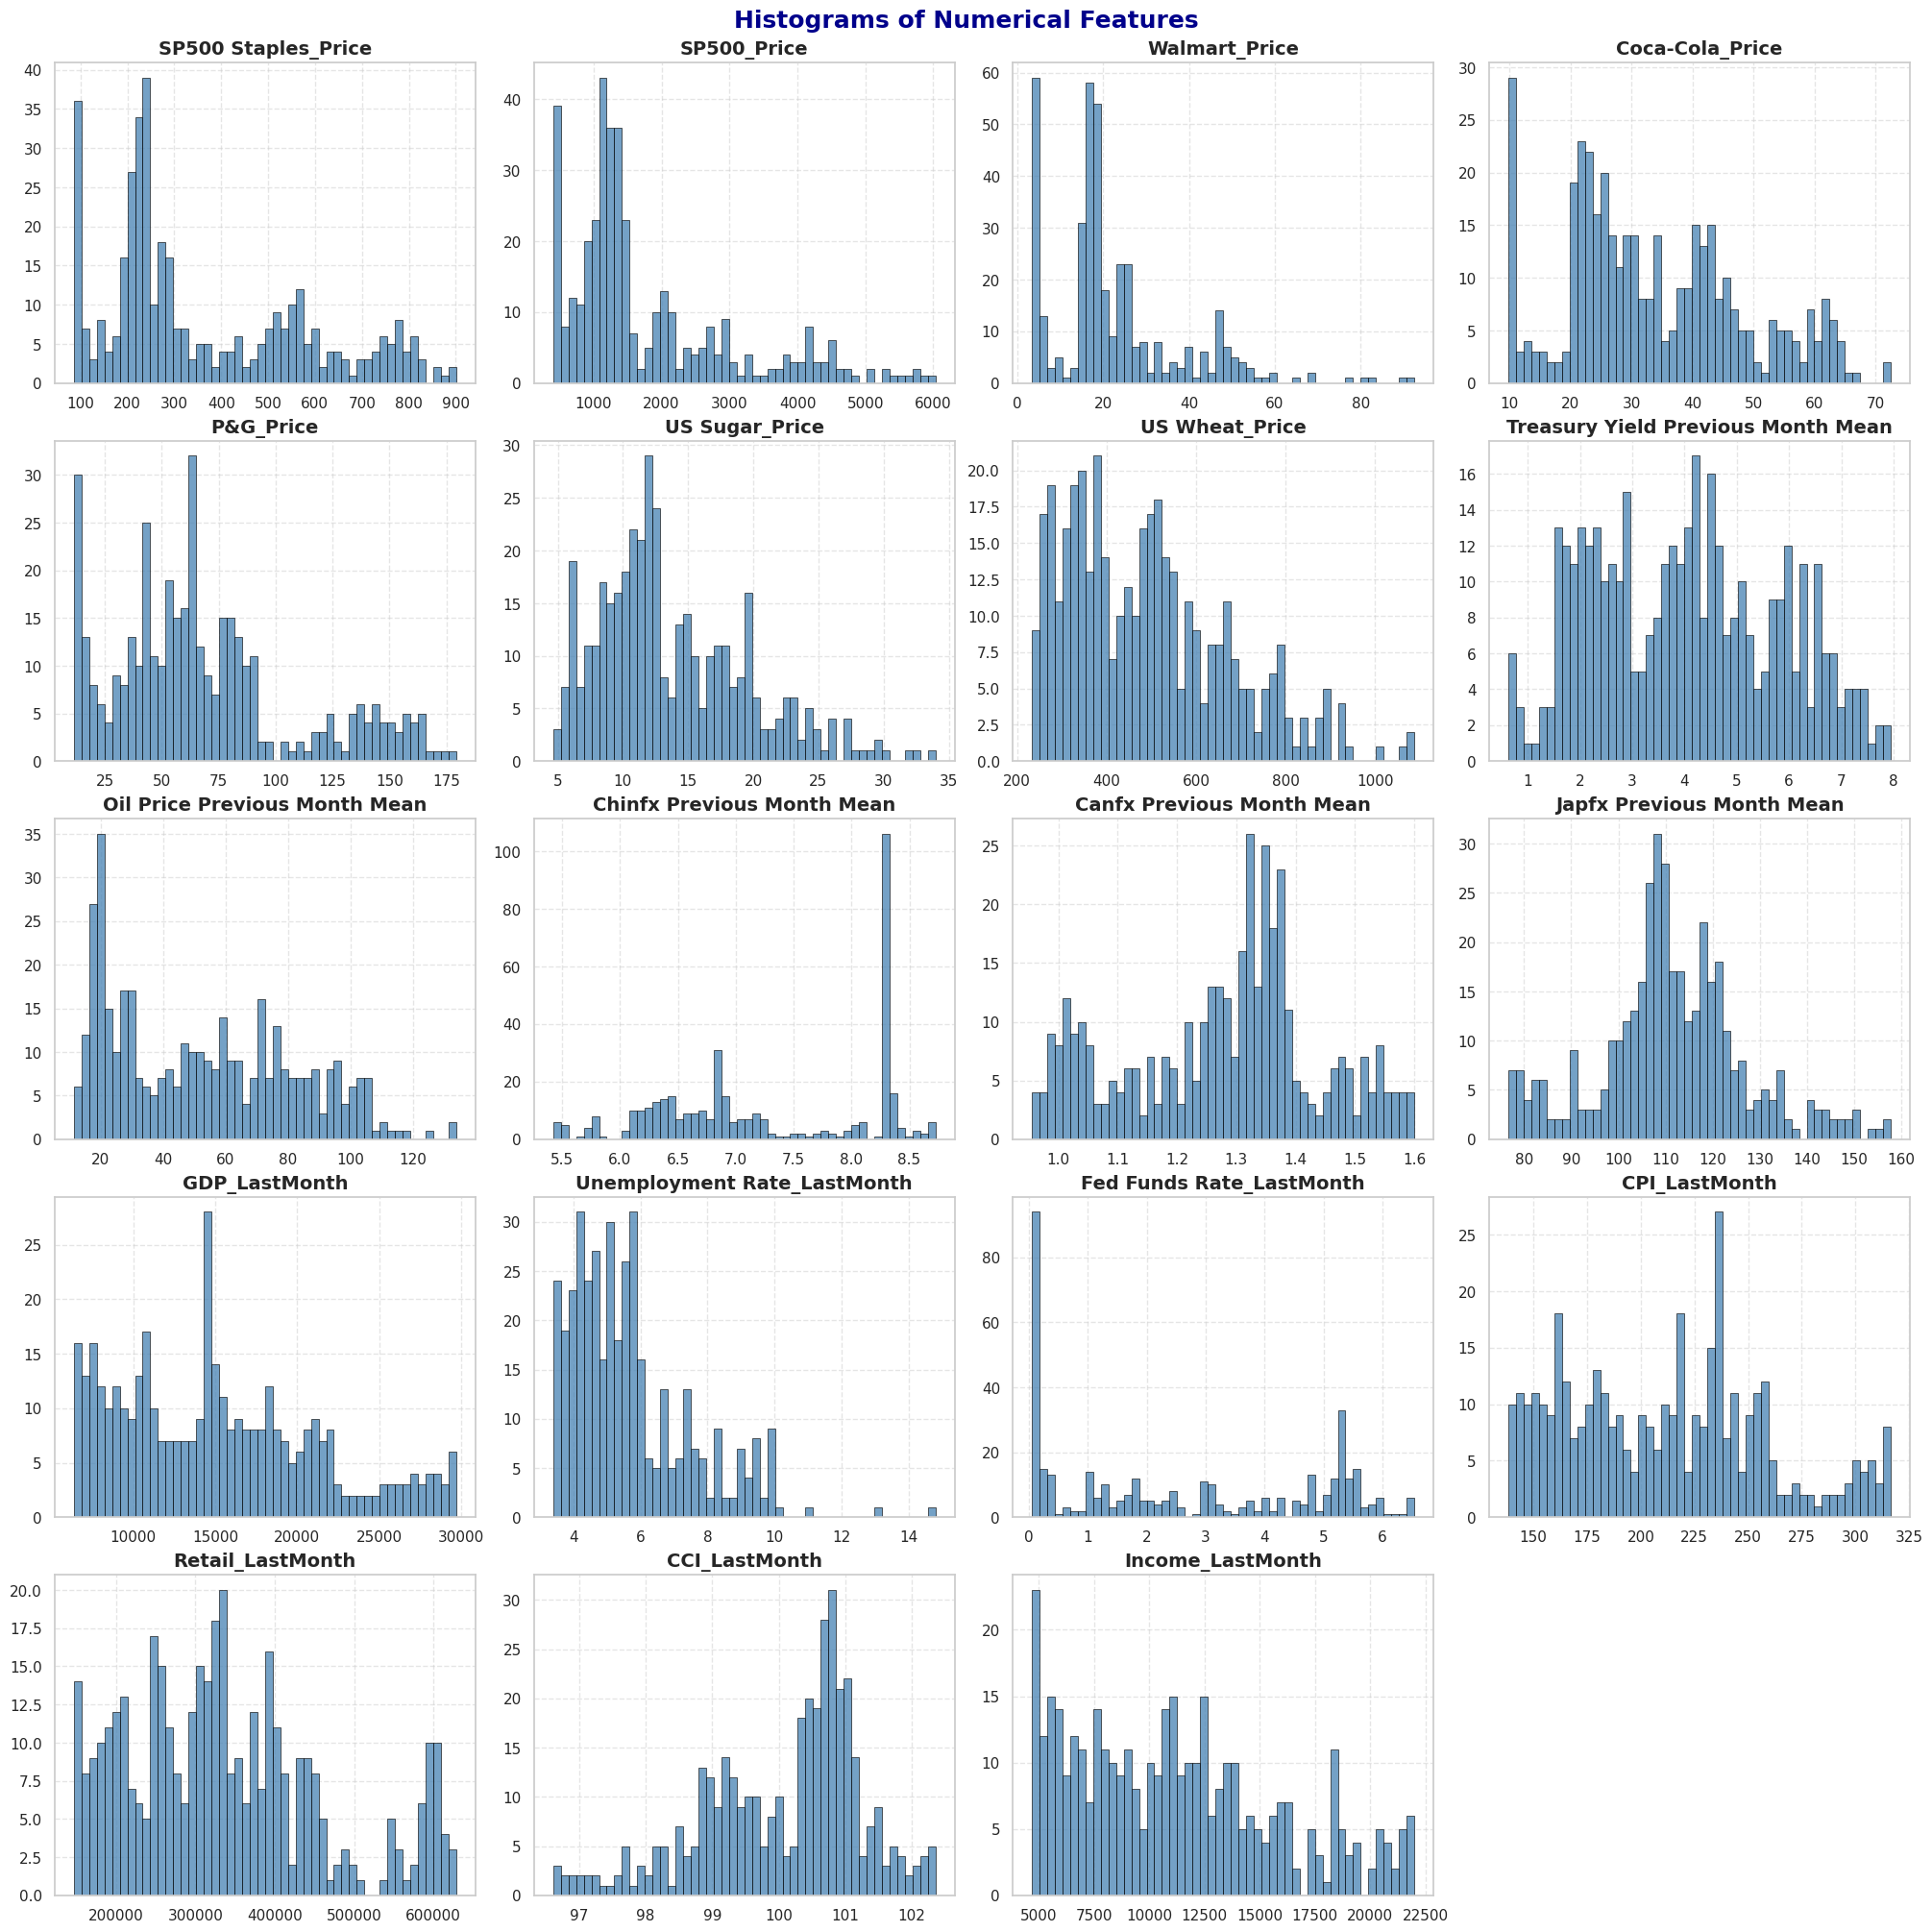

In [ ]:
# Histograms of all numerical variables
# Select numerical features
numerical_features = dfy.select_dtypes(include=np.number).columns

# Set up the grid for subplots
num_cols = 4  # Number of histograms per row
num_rows = -(-len(numerical_features) // num_cols)  # Calculate number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), constrained_layout=True)

# Flatten the axes for easy indexing
axes = axes.flatten()

# Set a professional style
sns.set_theme(style="whitegrid")

# Define a consistent blue color
blue_color = "steelblue"

# Loop through each numerical feature to plot
for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.histplot(
        dfy[feature].dropna(),
        kde=False,
        bins=50,
        color=blue_color,  # Use the same blue color
        edgecolor="black",
        ax=ax,
    )
    ax.set_title(feature, fontsize=14, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(visible=True, linestyle="--", alpha=0.5)

# Remove unused subplots
for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

# Add a central title
fig.suptitle("Histograms of Numerical Features", fontsize=18, fontweight="bold", color="darkblue")
plt.show()


In [ ]:
# Display descriptive statistics for numerical columns
numerical_stats = dfy.describe(include=np.number)
numerical_stats

SP500 Staples_Price  SP500_Price  Walmart_Price  Coca-Cola_Price  \
count           395.000000   395.000000     395.000000       395.000000   
mean            360.770354  1784.118253      22.294734        33.624506   
std             214.846710  1249.720294      15.418785        14.615530   
min              85.980000   403.700000       3.400000         9.840000   
25%             211.750000  1012.500000      15.325000        23.045000   
50%             272.680000  1320.400000      18.340000        30.680000   
75%             537.350000  2172.275000      26.020000        43.180000   
max             900.880000  6032.380000      92.500000        72.470000   

        P&G_Price  US Sugar_Price  US Wheat_Price  \
count  395.000000      395.000000      395.000000   
mean    68.108025       13.806354      490.670481   
std     40.726717        5.762685      180.778398   
min     11.410000        4.650000      233.000000   
25%     40.855000        9.635000      344.750000   
50%     61.820000       12.320000      471.000000   
75%     84.150000       17.535000      600.380000   
max    179.260000       33.970000     1088.000000   

       Treasury Yield Previous Month Mean  Oil Price Previous Month Mean  \
count                          395.000000                     395.000000   
mean                             4.015877                      52.631803   
std                              1.762971                      29.339459   
min                              0.625589                      11.349920   
25%                              2.496933                      24.748820   
50%                              4.005156                      49.729612   
75%                              5.352420                      75.723994   
max                              7.948267                     133.741580   

       Chinfx Previous Month Mean  Canfx Previous Month Mean  \
count                  395.000000                 395.000000   
mean                     7.264890                   1.277332   
std                      0.920303                   0.161638   
min                      5.422909                   0.955576   
25%                      6.475779                   1.157526   
50%                      7.018476                   1.310452   
75%                      8.277100                   1.370927   
max                      8.725529                   1.599980   

       Japfx Previous Month Mean  GDP_LastMonth  Unemployment Rate_LastMonth  \
count                 395.000000     395.000000                   395.000000   
mean                  111.358644   15110.121076                     5.687342   
std                    15.679587    6093.501418                     1.788554   
min                    76.664446    6363.102000                     3.400000   
25%                   103.776505   10206.796500                     4.400000   
50%                   110.146198   14583.793333                     5.300000   
75%                   119.967623   18991.009000                     6.550000   
max                   157.831479   29700.580000                    14.800000   

       Fed Funds Rate_LastMonth  CPI_LastMonth  Retail_LastMonth  \
count                395.000000     395.000000        395.000000   
mean                   2.590810     211.256278     336425.549367   
std                    2.185539      46.455821     124790.360333   
min                    0.050000     138.300000     146805.000000   
25%                    0.185000     170.950000     246667.000000   
50%                    2.130000     212.705000     322678.000000   
75%                    5.005000     240.860500     403994.000000   
max                    6.540000     316.441000     628727.000000   

       CCI_LastMonth  Income_LastMonth  
count     395.000000        395.000000  
mean      100.058578      11185.506835  
std         1.205759       4656.772566  
min        96.611650       4681.800000  
25%        99.231190       7265.050000  
50%       1

Elaboration on histograms and descriptive statistics:

Most of the numerical features show skewed distributions. Some have multiple peaks like SP500_Price and CPI_LastMonth, which could point to different time periods or trends. In addition, variables like Treasury Yield Previous Month Mean and Fed Funds Rate LastMonth are more normally distributed, suggesting they stayed relatively stable, which is powered by their relatively small standard deviation.

### Outliers

Outliers in the dataset, such as those caused by the COVID-19 pandemic and the 2008 financial crisis, were not removed. These events represent significant economic shocks that have had a profound impact on financial markets. Excluding them would risk losing critical information which is necessary for understanding how such events influence the index.

Furthermore, time series forecasting models are designed to account for variability and can handle such outliers without significant distortion. By keeping these data points, the analysis remains reflective of real-world scenarios, ensuring that the model is robust and better equipped to maybe even predict future economic shocks.

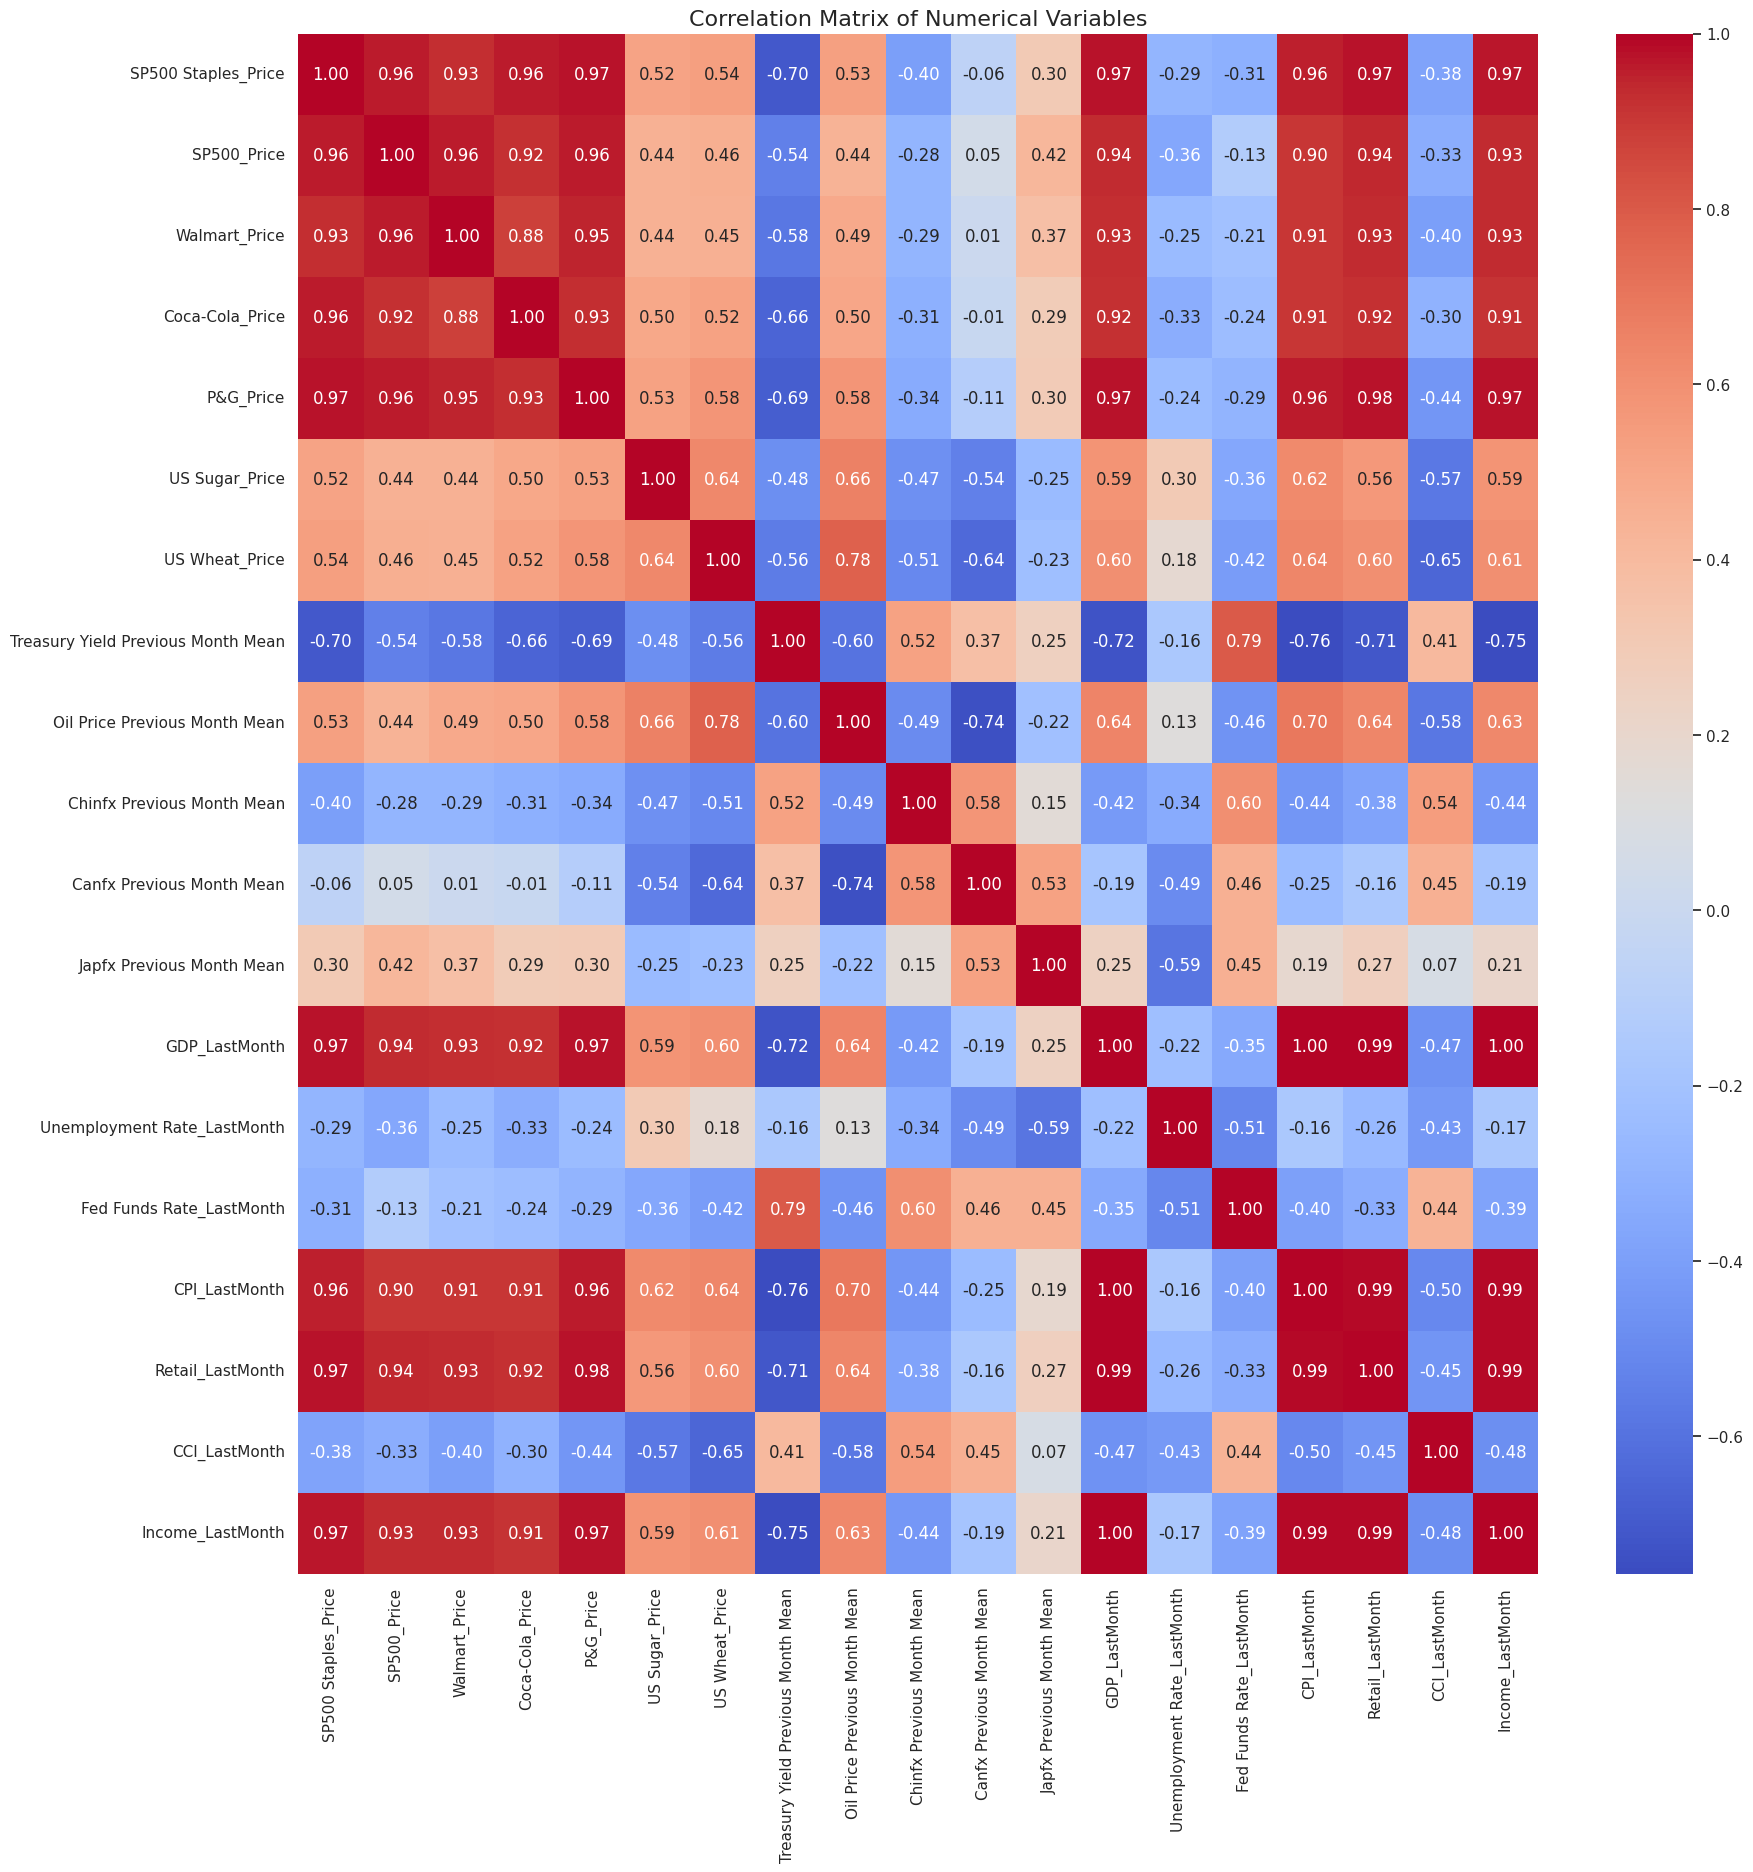

In [ ]:
# Correlation Matrix
# Extract numerical features for correlation analysis
numerical_features = dfy.select_dtypes(include=np.number).columns

# Calculate correlation matrix for numerical features only
plt.figure(figsize=(20, 20))  # Adjust figsize for readability
sns.heatmap(dfx[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables', fontsize=16)
plt.show()

### Correlation Matrix and multicollinearity
When forecasting we use lagged versions of the Y variable "SP500 Staples_Price". If we want to include X variables too, we have to account for multicollinearity by deleting variables that show high correlation with the Y variable (SP500_Staples_Price). The variables we use for the subsequent analysis are based on the following decisions:

1.  We retain variables with diverse information:
From the correlation matrix we can conclude that some variables capture unique dynamics combined with low correlations to others:

   -  Oil Price Previous Month Mean: Correlates moderately with some variables (e.g., S&P 500 Staples Price: 0.53), but adds valuable commodity-related insights.

  -  Treasury Yield Previous Month Mean: Captures interest rate dynamics and has low correlations with most variables except Oil Price (-0.72).

 -  Unemployment_Rate_LastMonth: Provides labor market insights with low correlations to other variables (e.g., S&P 500 Staples Price: -0.29).

 - Exchange rate variables: Chinfx, Canfx and Japfx provide financial market insights and have low correlation to others


2. We remove variables highly correlated with SP500 Staples Price (>0.9) as they may not add additional value in the models:

  -  SP500_Price: Highly correlated with SP500 Staples Price (0.96).

  -  CPI_LastMonth: Highly correlated with SP500 Staples Price (0.94).

  -  Retail_LastMonth: Highly correlated with CPI_LastMonth (0.93) and SP500 Staples Price (0.93).

  -  CCI_LastMonth: Correlated with CPI_LastMonth (0.93) and SP500 Staples Price (0.93).

  - Stock Price variables: Highly correlated with SP500 Staples Price (0.93 >=, 0.97 <=)

  - Income_LastMonth: Highly correlated with SP500 Staples Price (0.97) and GDP (1.00)
3.  We keep variables that provide complementary information:
 -  US Sugar Price and US Wheat Price: These are not strongly correlated with SP500 Staples Price or each other and might add valuable information about commodity trends.
 -  GDP_LastMonth: Highly correlated with SP500 Staples Price (0.93) but adds economic growth perspective.

In [ ]:
dfz = dfy.drop(columns=['SP500_Price', 'Walmart_Price', 'Coca-Cola_Price', 'P&G_Price', 'CPI_LastMonth', 'Retail_LastMonth', 'CCI_LastMonth', 'Income_LastMonth'])

In [ ]:
dfz

Date  SP500 Staples_Price  US Sugar_Price  US Wheat_Price  \
1   1992-02-01                93.81            7.86          401.50   
2   1992-03-01                92.66            8.68          379.00   
3   1992-04-01                93.40            9.45          372.25   
4   1992-05-01                94.34           10.03          349.50   
5   1992-06-01                91.63           10.55          349.50   
..         ...                  ...             ...             ...   
391 2024-08-01               882.60           19.38          551.50   
392 2024-09-01               887.78           22.67          584.00   
393 2024-10-01               861.70           22.74          570.50   
394 2024-11-01               900.88           21.08          532.25   
395 2024-12-01               853.65           19.26          551.50   

     Treasury Yield Previous Month Mean  Oil Price Previous Month Mean  \
1                              7.091262                      19.541958   
2                              7.022268                      18.802240   
3                              7.341833                      19.008871   
4                              7.531632                      18.912397   
5                              7.482185                      20.224844   
..                                  ...                            ...   
391                            4.312579                      79.800665   
392                            4.248053                      81.884873   
393                            3.872944                      76.681184   
394                            3.735570                      70.529295   
395                            4.095196                      72.045047   

     Chinfx Previous Month Mean  Canfx Previous Month Mean  \
1                      5.422909                   1.146741   
2                      5.461407                   1.156754   
3                      5.477490                   1.182338   
4                      5.486948                   1.192424   
5                      5.509755                   1.187432   
..                          ...                        ...   
391                    7.254240                   1.370243   
392                    7.261285                   1.371050   
393                    7.147486                   1.365500   
394                    7.078677                   1.354364   
395                    7.088328                   1.375793   

     Japfx Previous Month Mean  GDP_LastMonth  Unemployment Rate_LastMonth  \
1                   128.075149    6363.102000                          7.3   
2                   125.435055    6398.989000                          7.4   
3                   127.623621    6434.876000                          7.4   
4                   132.727276    6470.763000                          7.4   
5                   133.521908    6502.722333                          7.6   
..                         ...            ...                          ...   
391                 157.831479   29374.914000                          4.2   
392                 157.654868   29483.469333                          4.2   
393                 146.277767   29592.024667                          4.1   
394                 143.205912   29700.580000                          4.1   
395                 149.854073   29700.580000                          4.2   

     Fed Funds Rate_LastMonth  
1                        4.03  
2                        4.06  
3                        3.98  
4                        3.73  
5                        3.82  
..                        ...  
391                      5.33  
392                      5.33  
393                      5.13  
394                      4.83  
395                      4.64  

[395 rows x 12 columns]

# 4. Time Series Analysis

## Trends

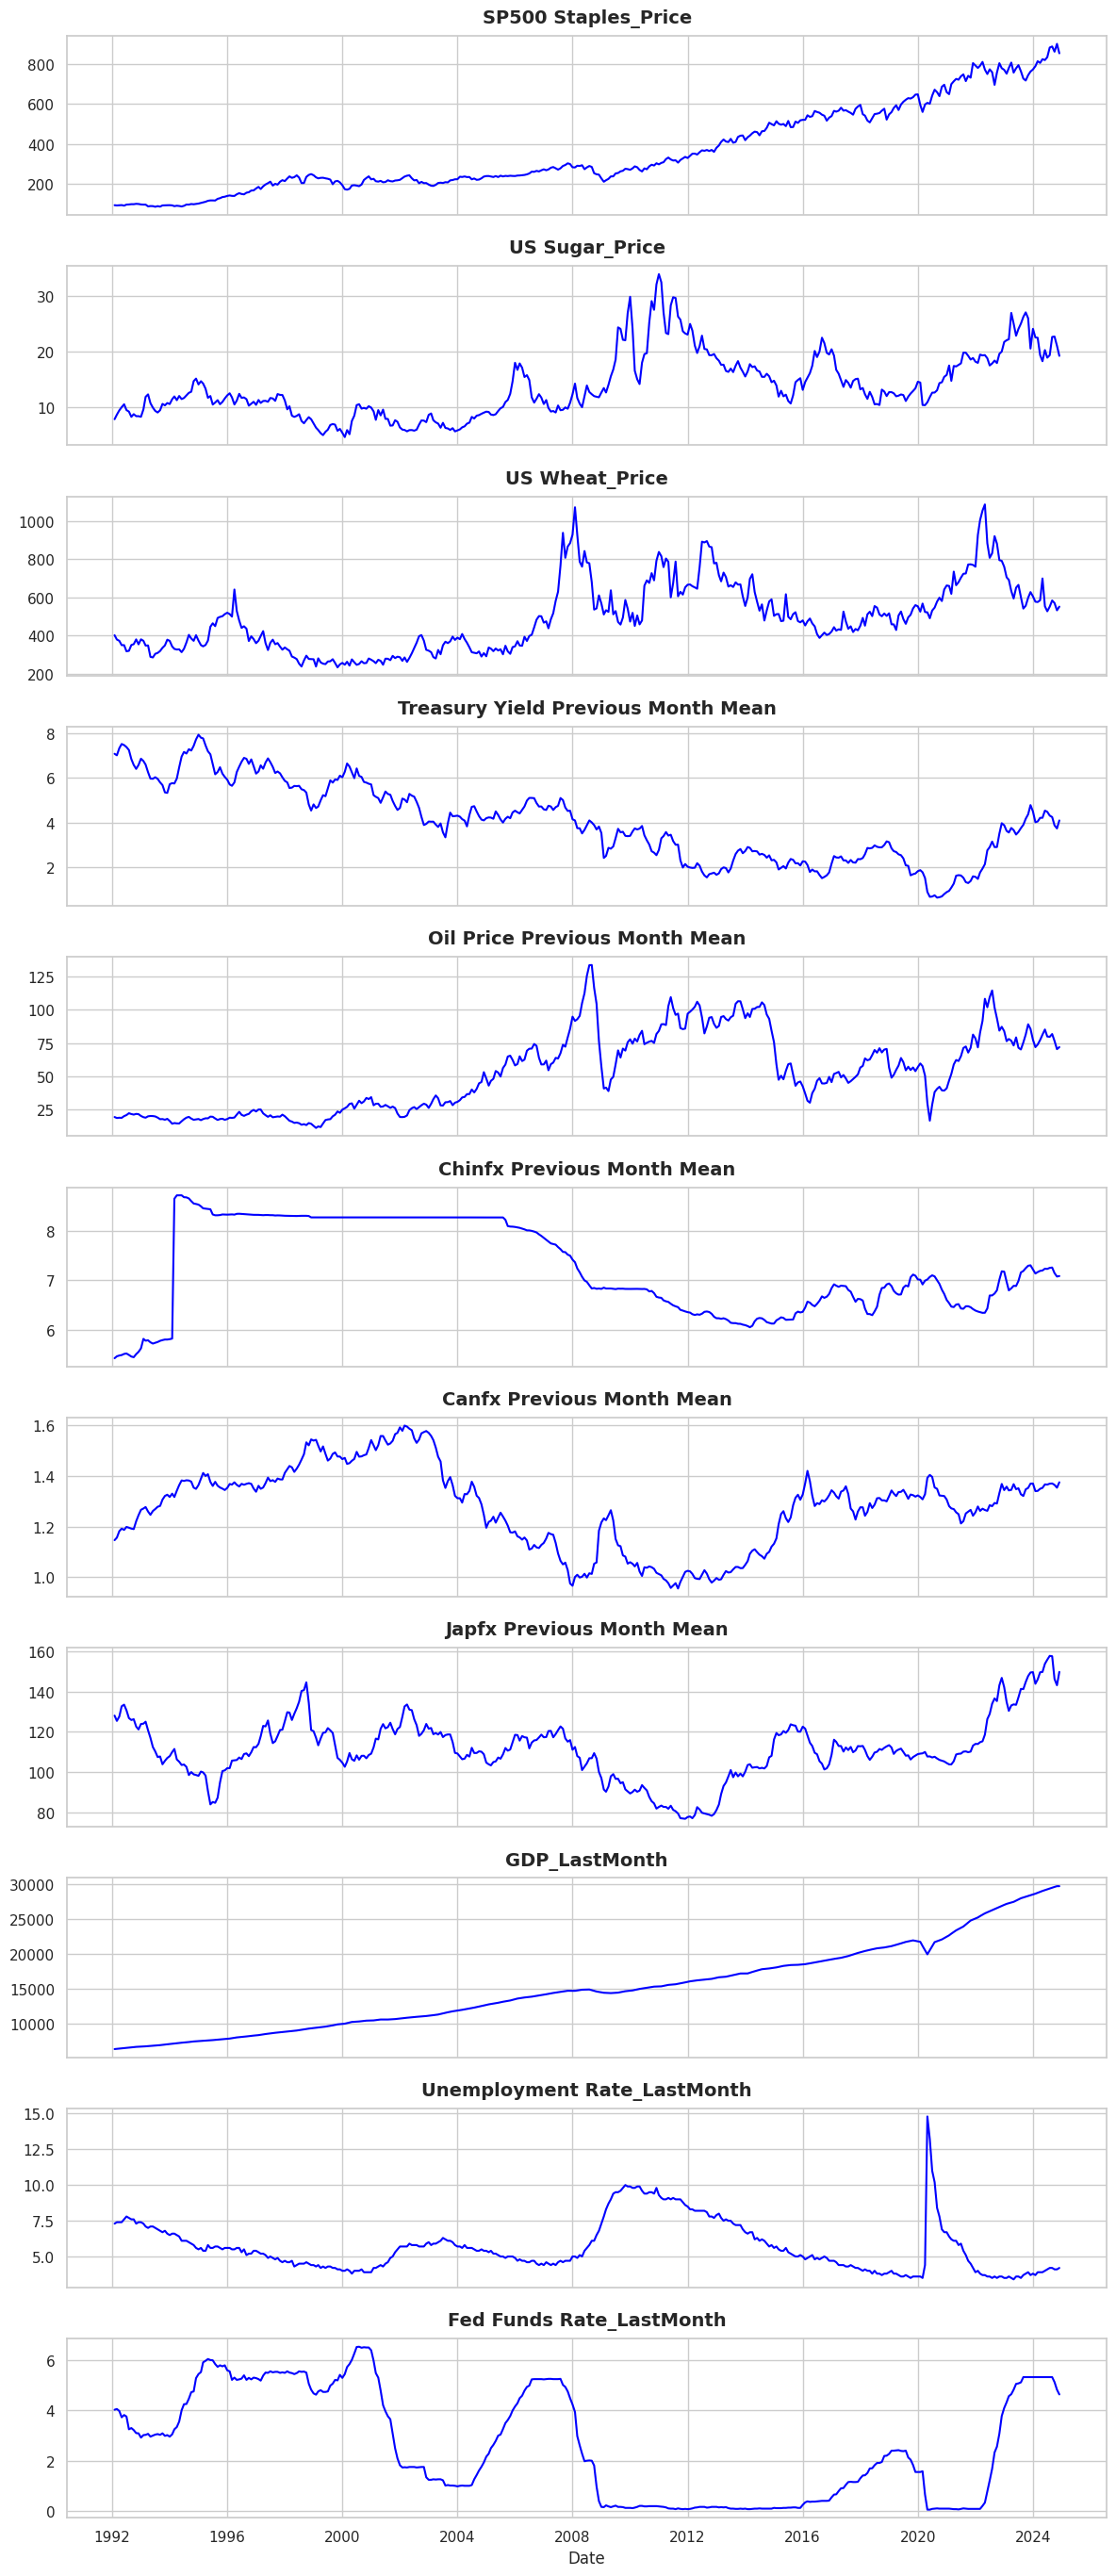

In [ ]:
# Plot the historical data of key factors
# Set a professional style
sns.set_theme(style="whitegrid")

# Create a figure and axes for subplots
num_variables = dfz.shape[1] - 1  # Exclude the Date column
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(12, 2.5 * num_variables), sharex=True)

# Reset index to 0 before the loop for accessing 'axes' array
plot_index = 0
for i, column in enumerate(dfz.columns):
    if column != "Date":  # Skip the Date column
        sns.lineplot(
            x=dfz["Date"], y=dfz[column], ax=axes[plot_index], linewidth=1.5, color="blue"
        )
        axes[plot_index].set_title(f"{column}", fontsize=14, weight='bold', pad=10)
        # Remove the y-axis label
        axes[plot_index].set_ylabel(None)
        axes[plot_index].grid(True)
        # Increment the plot_index for accessing the correct subplot
        plot_index += 1

# Customize the x-axis for the last subplot
axes[-1].set_xlabel("Date", fontsize=12)

# Improve spacing and layout
plt.tight_layout()
plt.show()


In [ ]:
# Check stationarity of each column in the DataFrame
def check_stationarity(dataframe):
    results = []

    for column in dataframe.columns:
        if dataframe[column].dtype in ['float64', 'int64']:
            result = adfuller(dataframe[column].dropna())
            p_value = result[1]
            is_stationary = 'Yes' if p_value < 0.05 else 'No'

            results.append({
                'Variable': column,
                'ADF Statistic': result[0],
                'p-value': p_value,
                'Stationary': is_stationary
            })

    # Convert results to a DataFrame for better visualization
    return pd.DataFrame(results)

# Example usage (replace 'dfz' with your actual DataFrame)
stationarity_results = check_stationarity(dfz)

# Display results
stationarity_results

Variable  ADF Statistic   p-value Stationary
0                  SP500 Staples_Price       1.693842  0.998113         No
1                       US Sugar_Price      -1.687266  0.437685         No
2                       US Wheat_Price      -2.261587  0.184656         No
3   Treasury Yield Previous Month Mean      -2.254567  0.187040         No
4        Oil Price Previous Month Mean      -2.541735  0.105647         No
5           Chinfx Previous Month Mean      -2.323050  0.164642         No
6            Canfx Previous Month Mean      -1.732783  0.414306         No
7            Japfx Previous Month Mean      -2.147116  0.225995         No
8                        GDP_LastMonth       2.021263  0.998700         No
9          Unemployment Rate_LastMonth      -3.242138  0.017671        Yes
10            Fed Funds Rate_LastMonth      -2.918706  0.043216        Yes

Observation on trends:

SP500 Consumer Staples and GDP are almost random walks, indicating that predicting them will be quite hard.

As only two variables are stationary, we create new columns for all variables with their percentage change. We do the following for the forecasting models:

- ARIMA: Transform the SP500_Staples_Price to a change variable

- VAR: Transform all variables to change variables

- Prophet: Use raw data as the model accounts for trends itself

- XGBoost & Random Forest: Transform all variables to change variables

## Seasonality

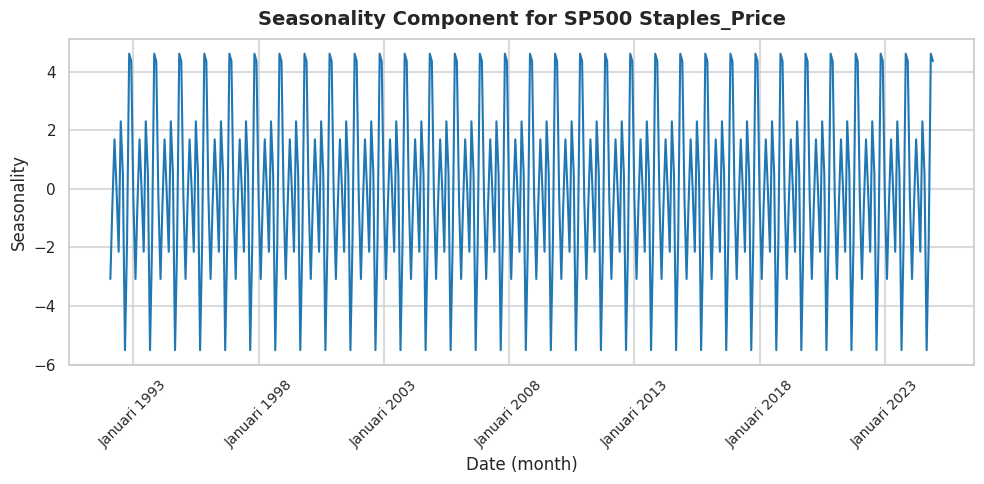

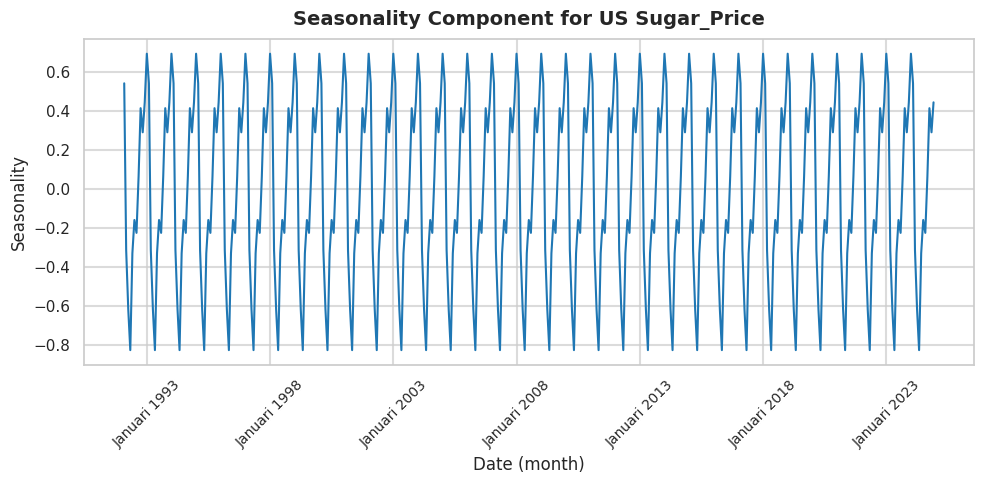

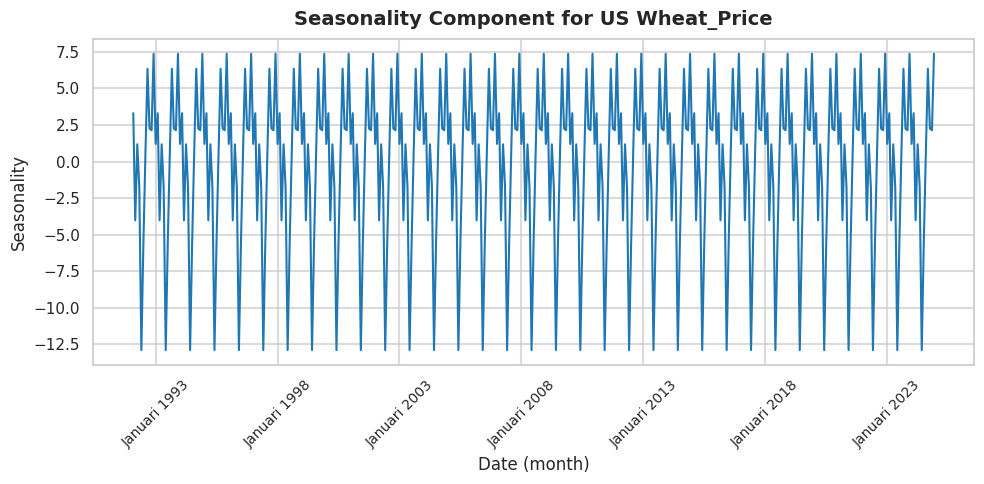

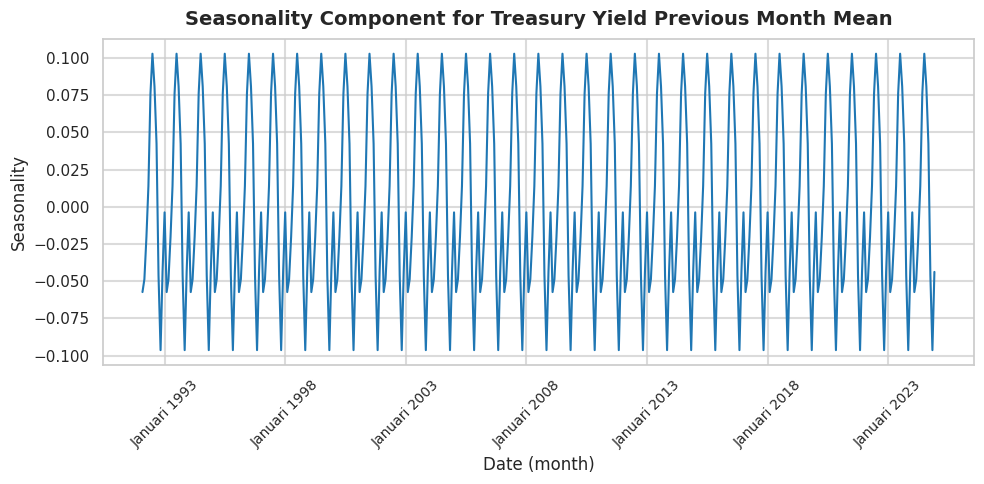

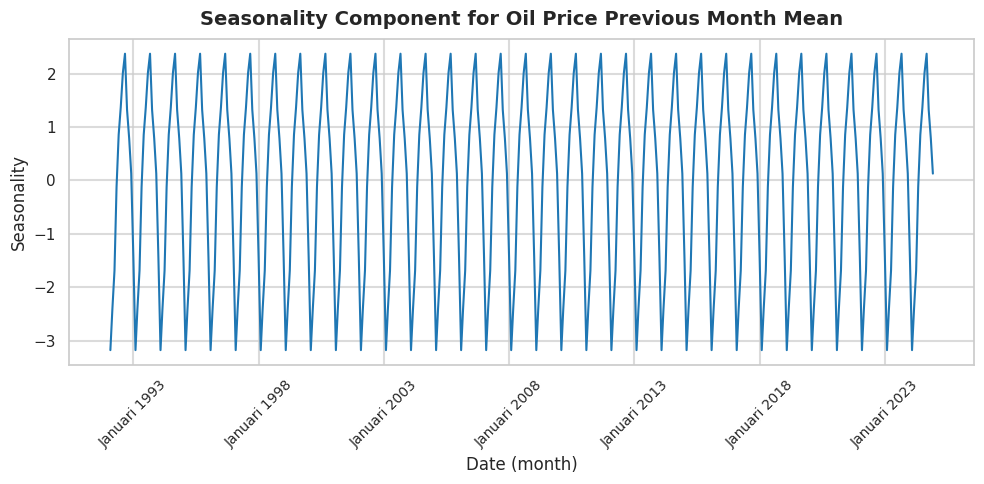

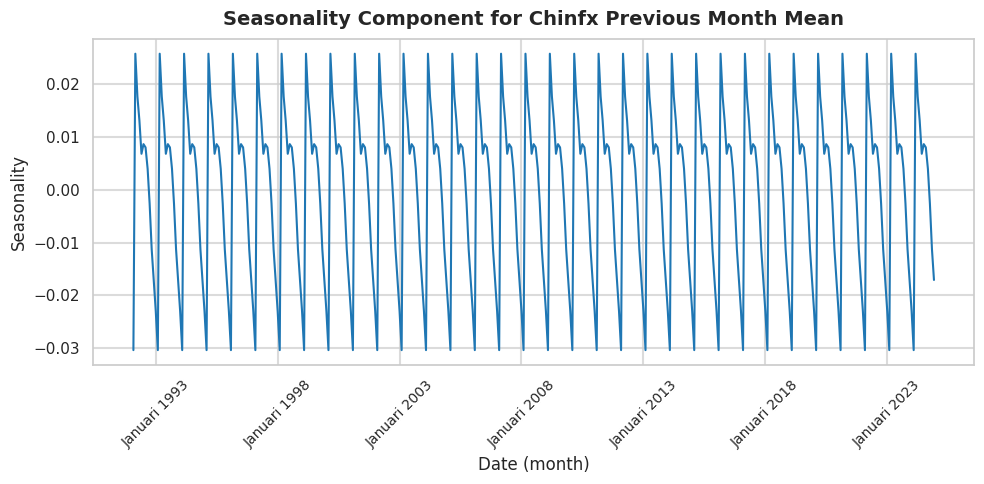

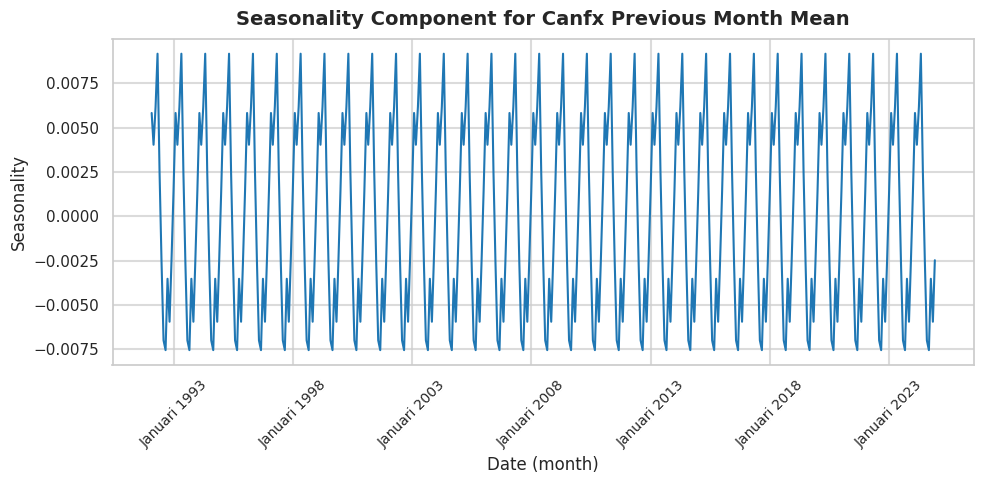

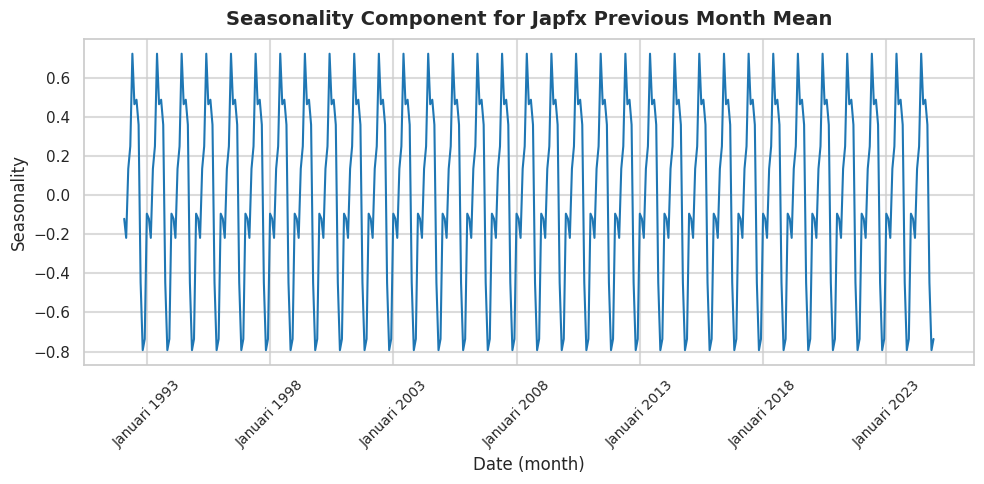

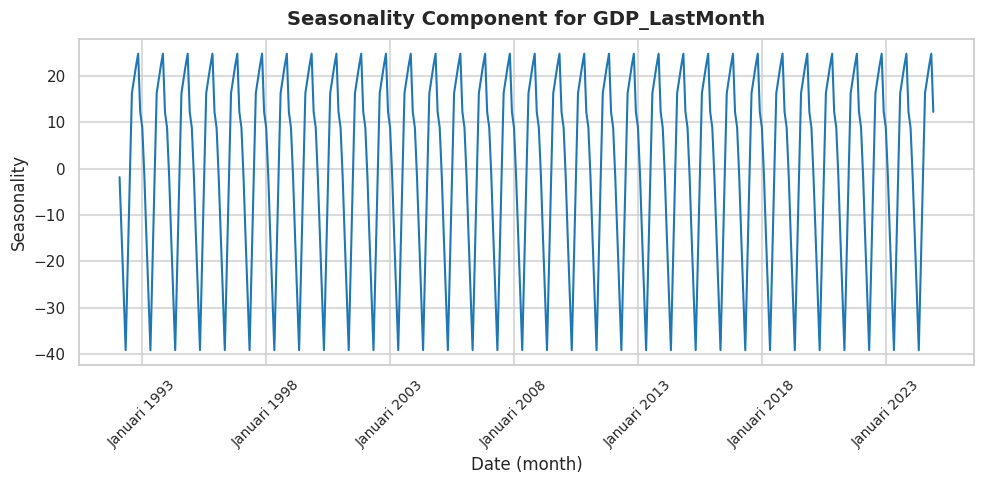

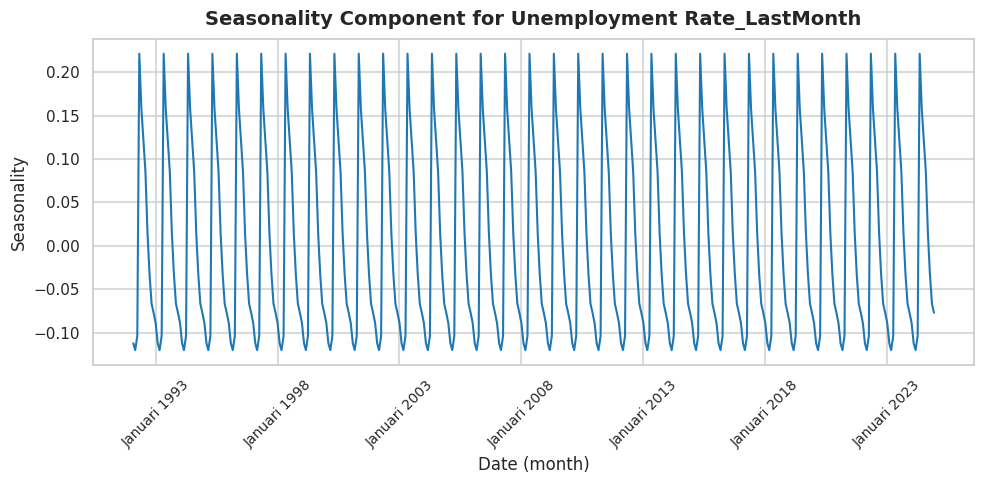

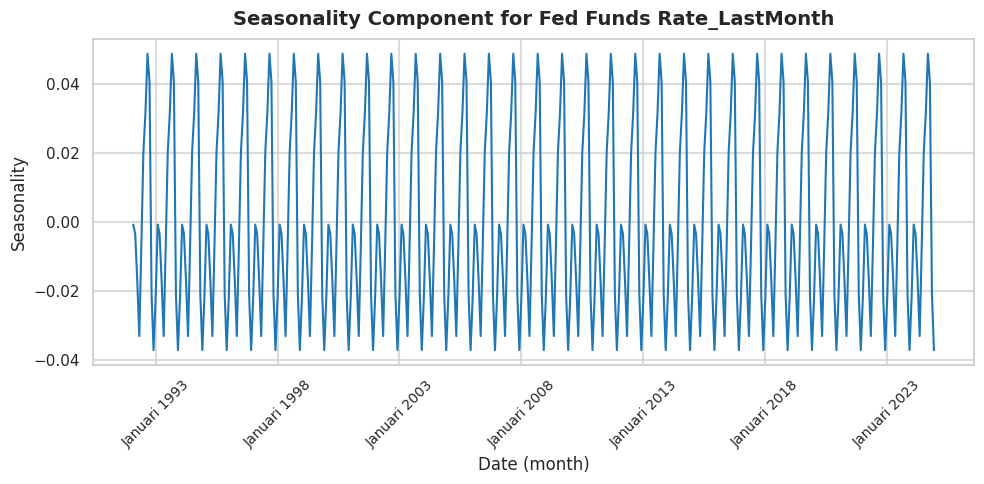

In [ ]:
# Create graphs to show seasonality
for column in dfz.columns:
    if column != 'Date':  # Skip the 'Date' column
        # Perform seasonal decomposition, ensure the index is a DatetimeIndex
        decomposition = seasonal_decompose(dfz.set_index('Date')[column], model='additive', period=12, extrapolate_trend='freq')
        seasonality = decomposition.seasonal  # Extract seasonality component

        # Convert the index of seasonality to datetime objects if it's not already
        seasonality.index = pd.to_datetime(seasonality.index)

        # Select 6 evenly spaced January intervals
        january_dates = [date for date in seasonality.index if date.month == 1]
        selected_dates = january_dates[::len(january_dates) // 6]  # Select 6 evenly spaced Januarys

        # Plot the seasonality component
        plt.figure(figsize=(10, 5))
        plt.plot(seasonality, color='#1f77b4', linewidth=1.5)  # Use blue color matching the example

        # Set x-axis labels with "Januari YYYY"
        plt.xticks(
            ticks=selected_dates,
            labels=[f"Januari {date.year}" for date in selected_dates],
            rotation=45,
            fontsize=10
        )

        # Add title and labels
        plt.title(f"Seasonality Component for {column}", fontsize=14, weight='bold', pad=10)
        plt.xlabel("Date (month)", fontsize=12)
        plt.ylabel("Seasonality", fontsize=12)

        # Add gridlines
        plt.grid(True, which='major', linestyle='-', linewidth=1.5, alpha=0.7)

        plt.tight_layout()
        plt.show()

####Observations on seasonality

Many variables in the dataset show seasonal patterns that repeat at regular intervals. This means their values are influenced by cycles that occur every year or quarter.
- SP500 Staples Price and Income_LastMonth have smoother patterns, likely due to longer-term economic cycles.
- US Wheat Price and Oil Price are more turbulant, probably due to weather conditions or events like trade issues.
- Fed Funds Rate shows patterns connected to government and central bank policies.

We will adress seasonality in the following way:

- ARIMA: Using monthly dummies
- Multivariable models: Using decompostion techniques for simplicity

##Apperent Correlations of key variables with the S&P 500 Consumer Staples Index
When visually examining the plots of historical trends we observe the following:

- GDP LastMonth shows a steady upward trend that aligns with the SP500 Staples_Price pattern. This suggests a possible positive correlation between the economic growth indicator and the index.
- Treasury Yield Previous Month Mean: shows a downward trend, especially after 2008, while SP500 steadily increases. This suggests a possible negative correlation, which could be because higher yields compete with stocks as an investment option.
- Remaining variables do not show correlations that we can easily see through the naked eye

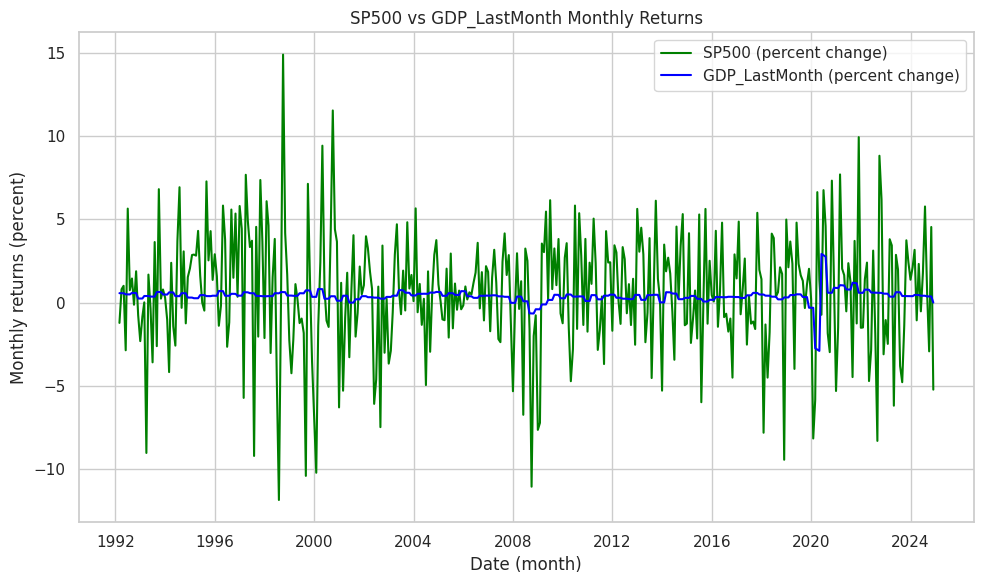

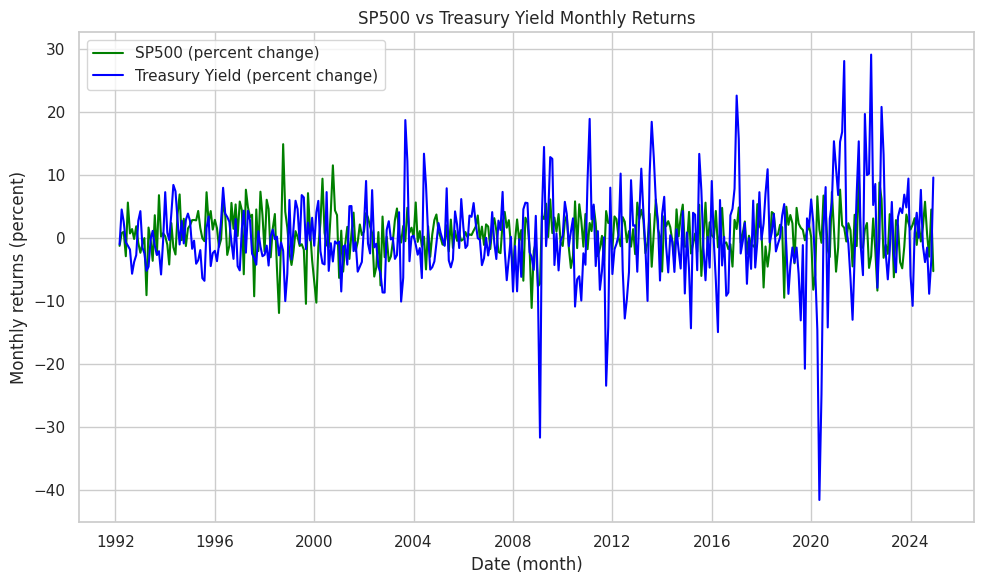

In [ ]:
# Create the first plot: SP500 vs GDP_LastMonth
plt.figure(figsize=(10, 6))
plt.plot(dfz['Date'], dfz['SP500 Staples_Price'].pct_change() * 100, label='SP500 (percent change)', color='green')
plt.plot(dfz['Date'], dfz['GDP_LastMonth'].pct_change() * 100, label='GDP_LastMonth (percent change)', color='blue')
plt.xlabel('Date (month)')
plt.ylabel('Monthly returns (percent)')
plt.title('SP500 vs GDP_LastMonth Monthly Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create the second plot: SP500 vs Treasury Yield
plt.figure(figsize=(10, 6))
plt.plot(dfz['Date'], dfz['SP500 Staples_Price'].pct_change() * 100, label='SP500 (percent change)', color='green')
plt.plot(dfz['Date'], dfz['Treasury Yield Previous Month Mean'].pct_change() * 100, label='Treasury Yield (percent change)', color='blue')
plt.xlabel('Date (month)')
plt.ylabel('Monthly returns (percent)')
plt.title('SP500 vs Treasury Yield Monthly Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Serial Correlation

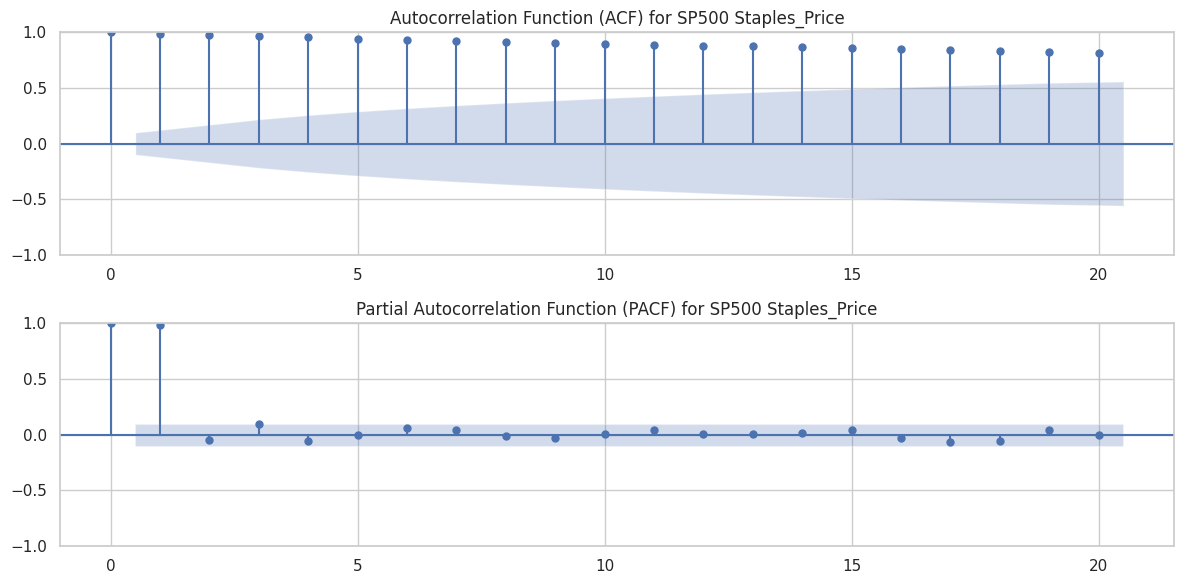

In [ ]:
# Analyse serial correlation of SP500 Staples_Price in dataset
variable = dfz['SP500 Staples_Price']

# ACF and PACF plots
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(variable.dropna(), ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function (ACF) for SP500 Staples_Price')

plt.subplot(2, 1, 2)
plot_pacf(variable.dropna(), ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function (PACF) for SP500 Staples_Price')

plt.tight_layout()
plt.show()


- ACF (Autocorrelation Function):
The ACF shows significant autocorrelation at all lags and decays extremely slow. This indicates strong serial correlation in the time series. This is primarily the case in non-stationary series, which is true for our index

- PACF (Partial Autocorrelation Function):
The PACF shows a spike at lag 1 and quickly diminishes after that. This suggests that the current value depends primarily on the immediately preceding value. This is valuable information for the ARIMA and VAR models.

## ARIMA

In [ ]:
# Convert 'Date' column to datetime and set it as the index
dfz['Date'] = pd.to_datetime(dfz['Date'])
dfz.set_index('Date', inplace=True)

# Select the 'SP500 Staples_Price' column for time series analysis
sp500 = dfz['SP500 Staples_Price']

# Ensure the time series has a proper monthly frequency
sp500 = sp500.asfreq('MS')

# Define the walk-forward validation function
def walk_forward_arima(series, order, title, seasonal_order=None, forecast_horizon=3, initial_window=36, use_diff_norm=False):
    rmse_scores = []
    nrmse_scores = []

    # Start walk-forward validation
    for end_train in range(initial_window, len(series) - forecast_horizon + 1):
        # Define the training and testing sets
        train = series[:end_train]
        test = series[end_train:end_train + forecast_horizon]

        # Fit the ARIMA model on the training set
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)

        # Predict for the forecast horizon
        predictions = results.predict(start=test.index[0], end=test.index[-1])

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test, predictions))

        # Normalize RMSE
        if use_diff_norm:
            normalization_factor = np.mean(np.abs(train.diff().dropna()))
        else:
            normalization_factor = np.mean(train)

        nrmse = (rmse / normalization_factor) * 100 if normalization_factor != 0 else 0

        rmse_scores.append(rmse)
        nrmse_scores.append(nrmse)

    # Average RMSE and NRMSE across all walk-forward iterations
    avg_rmse = np.mean(rmse_scores)
    avg_nrmse = np.mean(nrmse_scores)
    print(f"{title} Walk-Forward RMSE: {avg_rmse:.2f}, NRMSE: {avg_nrmse:.2f}%")
    return avg_rmse, avg_nrmse

# Perform walk-forward validation for basic ARIMA (2,1,0)
wf_rmse_model_1, wf_nrmse_model_1 = walk_forward_arima(
    sp500.diff().dropna(), order=(2, 1, 0), title="ARIMA (2,1,0) Walk-Forward", forecast_horizon=3, initial_window=36, use_diff_norm=True
)

# Perform walk-forward validation for ARIMA with seasonal order (2,1,0)(1,0,0,12)
wf_rmse_model_2, wf_nrmse_model_2 = walk_forward_arima(
    sp500, order=(2, 1, 0), seasonal_order=(1, 0, 0, 12), title="ARIMA (2,1,0)(1,0,0,12) Walk-Forward", forecast_horizon=3, initial_window=36, use_diff_norm=False
)

# Summarize walk-forward validation results
wf_rmse_nrmse_comparison = pd.DataFrame({
    'ARIMA Δ (2,1,0) Walk-Forward': {'WF RMSE': wf_rmse_model_1, 'WF NRMSE (%)': wf_nrmse_model_1},
    'ARIMA Level (2,1,0)(1,0,0,12) Walk-Forward': {'WF RMSE': wf_rmse_model_2, 'WF NRMSE (%)': wf_nrmse_model_2},
}).T

display(wf_rmse_nrmse_comparison)


ARIMA (2,1,0) Walk-Forward Walk-Forward RMSE: 14.96, NRMSE: 168.56%
ARIMA (2,1,0)(1,0,0,12) Walk-Forward Walk-Forward RMSE: 16.75, NRMSE: 7.66%


WF RMSE  WF NRMSE (%)
ARIMA Δ (2,1,0) Walk-Forward                14.955616    168.557243
ARIMA Level (2,1,0)(1,0,0,12) Walk-Forward  16.750638      7.664792

##VAR

In [ ]:
dfz = dfz.reset_index()

In [ ]:
from statsmodels.tsa.api import VAR
import numpy as np

# Convert 'Date' column to datetime format and set it as index
dfz['Date'] = pd.to_datetime(dfz['Date'])
dfz.set_index('Date', inplace=True)

# Set frequency
dfz = dfz.asfreq('MS')

# Difference the data to make it stationary, but exclude 'Date'
diff_data = dfz.select_dtypes(include=np.number).diff().dropna()

# Step 2: Select the optimal lag order using AIC
model = VAR(diff_data)
lag_selection = model.select_order(maxlags=12)  # Consider lags up to 12
optimal_lag = lag_selection.aic  # AIC-selected lag

# Display the optimal lag in a nice format
display(f"The optimal lag selected by AIC is: {optimal_lag}")

'The optimal lag selected by AIC is: 2'

In [ ]:
data = dfz.copy()

# Function to compute rolling window forecasts and validation
def rolling_window_validation(data, target_var, rolling_window=36, steps_ahead=3):
    variables = list(data.columns)
    variables.remove(target_var)  # Exclude target variable initially
    results = {}

    for i, variable in enumerate(variables, start=1):
        current_vars = [target_var] + variables[:i]  # Add one variable at a time
        rolling_forecasts = []
        actuals = []
        indices = []

        # Perform rolling window forecast
        for start in range(len(data) - rolling_window - steps_ahead):
            train = data.iloc[start:start + rolling_window][current_vars]
            test_index = start + rolling_window + steps_ahead  # Move test index correctly for next quarter

            model = VAR(train)
            fitted_model = model.fit(2)  # Use the previously determined lag of 2

            forecast = fitted_model.forecast(train.values[-2:], steps=steps_ahead)
            rolling_forecasts.append(forecast[-1][0])  # Target variable forecast
            actuals.append(data.iloc[test_index][target_var])
            indices.append(data.index[test_index])

        # Store results for the current variable set
        results[tuple(current_vars)] = pd.DataFrame({
            'Forecast': rolling_forecasts,
            'Actual': actuals
        }, index=indices)

    return results

# Adjust the function to format NRMSE as a percentage and drop NaN rows
def calculate_rmse_nrmse_clean(results, target_var):
    metrics = {}
    for variables, result_df in results.items():
        y_true = result_df['Actual']
        y_pred = result_df['Forecast']
        if len(y_true) > 0 and len(y_pred) > 0:  # Ensure data is not empty
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Calculate RMSE
            nrmse = (rmse / (y_true.max() - y_true.min())) * 100  # NRMSE as a percentage
            metrics[variables] = {'RMSE': rmse, 'NRMSE (%)': nrmse}
    return pd.DataFrame(metrics).T.dropna()  # Drop NaN rows

# Run rolling window validation (Make sure dfz contains the required columns)
rolling_results = rolling_window_validation(data, target_var='SP500 Staples_Price', rolling_window=36, steps_ahead=3)

# Calculate clean RMSE and NRMSE metrics
validation_metrics_clean = calculate_rmse_nrmse_clean(rolling_results, target_var='SP500 Staples_Price')

# Display the cleaned metrics
display(validation_metrics_clean)


RMSE  \
SP500 Staples_Price US Sugar_Price NaN            NaN                                NaN                           NaN                        NaN                       NaN                       NaN           NaN                         NaN                         32.647081   
                                   US Wheat_Price NaN                                NaN                           NaN                        NaN                       NaN                       NaN           NaN                         NaN                         35.061748   
                                                  Treasury Yield Previous Month Mean NaN                           NaN                        NaN                       NaN                       NaN           NaN                         NaN                         36.464580   
                                                                                     Oil Price Previous Month Mean NaN                        NaN                       NaN                       NaN           NaN                         NaN                         37.891127   
                                                                                                                   Chinfx Previous Month Mean NaN                       NaN                       NaN           NaN                         NaN                        542.696887   
                                                                                                                                              Canfx Previous Month Mean NaN                       NaN           NaN                         NaN                        125.553788   
                                                                                                                                                                        Japfx Previous Month Mean NaN           NaN                         NaN                        101.102149   
                                                                                                                                                                                                  GDP_LastMonth NaN                         NaN                        389.404722   
                                                                                                                                                                                                                Unemployment Rate_LastMonth NaN                       2147.805907   
                                                                                                                                                                                                                                            Fed Funds Rate_LastMonth  3244.140375   

                                                                                                                                                                                                                                                                       NRMSE (%)  
SP500 Staples_Price US Sugar_Price NaN            NaN                                NaN                           NaN                        NaN                       NaN                       NaN           NaN                         NaN                         4.158705  
                                   US Wheat_Price NaN                                NaN                           NaN                        NaN                       NaN                       NaN           NaN                         NaN                         4.466294  
                                                  Treasury Yield Previous Month Mean NaN                           NaN                        NaN                       NaN                       NaN           NaN                         NaN                         4.644992  
                                                                                     Oil Price Previous Month Mean NaN   

In [ ]:
# Best model isolation
best_model = validation_metrics_clean.loc[validation_metrics_clean['NRMSE (%)'].idxmin()]
best_model_details = {
    "Variables": ["SP500 Staples_Price", "US Sugar_Price"],
    "RMSE": best_model['RMSE'],
    "NRMSE (%)": best_model['NRMSE (%)']
}

# Convert to a DataFrame for better display
best_model_df = pd.DataFrame([best_model_details])

# Display the cleaned, nicely formatted best model details
display(best_model_df)


Variables       RMSE  NRMSE (%)
0  [SP500 Staples_Price, US Sugar_Price]  32.647081   4.158705


We constructed VAR models by first determining the optimal lag order using the Akaike Information Criterion (AIC), which selected a lag of 2. In addition, we added one variable at a time to the model and conducted rolling window validation over 36 months to forecast the 3rd next month's price. For each model, we calculated RMSE and normalized RMSE (NRMSE) to evaluate forecasting accuracy.

## Prophet

In [ ]:
dfz = dfz.reset_index()

In [ ]:
# Annotate variables used in the prophet
prophet_df = dfz[['Date', 'SP500 Staples_Price']].copy()
prophet_df.rename(columns={'Date': 'ds', 'SP500 Staples_Price': 'y'}, inplace=True)

In [ ]:
# Create the rolling window for validation
window_size = 36  # 36 months rolling window
forecasts = []
actual_values = []

for i in range(window_size, len(prophet_df)):
    train_data = prophet_df.iloc[i - window_size:i]  # Rolling window data
    test_data = prophet_df.iloc[i:i + 1]  # Next quarter (assuming quarterly data)

    model = Prophet()  # Initialize Prophet model
    model.fit(train_data)  # Fit model to rolling window data

    future = model.make_future_dataframe(periods=1, freq='ME')  # Predict one month ahead (adjust freq as needed)

    forecast = model.predict(future)

    forecasts.append(forecast['yhat'].iloc[-1])  # Get the last forecast value
    actual_values.append(test_data['y'].iloc[0])


In [ ]:
# RMSE and NRMSE values
rmse = np.sqrt(mean_squared_error(actual_values, forecasts))
nrmse = rmse / (np.max(actual_values) - np.min(actual_values))

# Convert NRMSE to percentage
nrmse_percentage = nrmse * 100

# Create a DataFrame for display
results_df = pd.DataFrame({
    'Model': ['Prophet'],
    'RMSE': [rmse],
    'NRMSE (%)': [nrmse_percentage]
})

# Display the DataFrame
display(results_df)

Model       RMSE  NRMSE (%)
0  Prophet  42.896032   5.389626

## XGBoost

In [ ]:
dfz = dfz.reset_index()

In [ ]:
# Step 1: Feature Engineering
# Create lagged features and rolling statistics for the dataset
def create_features(data, target_var, max_lag=3):
    df = data.copy()

    # Set 'Date' column as index before feature engineering
    df = df.set_index('Date')

    # Create lagged features for the target variable
    for lag in range(1, max_lag + 1):
        df[f'{target_var}_lag{lag}'] = df[target_var].shift(lag)

    # Create lagged features for all other variables
    for col in data.columns:
        if col != target_var and col != 'Date':  # Exclude 'Date' column
            for lag in range(1, max_lag + 1):
                df[f'{col}_lag{lag}'] = df[col].shift(lag)

    # Add rolling statistics (mean and variance)
    df[f'{target_var}_rolling_mean'] = df[target_var].rolling(window=max_lag).mean()
    df[f'{target_var}_rolling_std'] = df[target_var].rolling(window=max_lag).std()

    # Add time-based features (e.g., month, quarter)
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter

    # Drop rows with NaN values resulting from lagging
    df = df.dropna()
    return df

# Step 2: Prepare the dataset
target_var = 'SP500 Staples_Price'
prepared_data = create_features(dfz, target_var) # Change data to dfz

# Define the target (shifted by 3 months) and predictors
prepared_data['target'] = prepared_data[target_var].shift(-3)
prepared_data = prepared_data.dropna()  # Drop NaNs resulting from the target shift

X = prepared_data.drop(columns=['target'])
y = prepared_data['target']


# Step 3: Train-Test Split
tscv = TimeSeriesSplit(n_splits=5)
X_train, y_train = X.iloc[:-36], y.iloc[:-36]
X_test, y_test = X.iloc[-36:], y.iloc[-36:]

# Step 4: Train Boosting Model (XGBoost Example)
# Convert data to DMatrix, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=500,
                      evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=10, verbose_eval=False)

# Step 5: Forecast and Evaluate
y_pred = xgb_model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)  # Calculate mean squared error
rmse = np.sqrt(mse)  # Manually calculate RMSE
nrmse = rmse / (y_test.max() - y_test.min()) * 100  # NRMSE as a percentage

# Prepare forecast results
forecast_results = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred}, index=y_test.index)
print(f'XGBoost RMSE: {rmse}')
print(f'XGBoost NRMSE (%): {nrmse}')

XGBoost RMSE: 67.89134093270674
XGBoost NRMSE (%): 33.10158017196817


In [ ]:
# Enhanced Feature Engineering with Differencing and Fourier Terms
def create_enhanced_features(data, target_var, max_lag=3):
    df = data.copy()

    # Set 'Date' column as index before feature engineering
    df = df.set_index('Date')  # Make 'Date' the index

    # Create lagged features for the target variable and other variables
    for lag in range(1, max_lag + 1):
        df[f'{target_var}_lag{lag}'] = df[target_var].shift(lag)
        for col in data.columns:
            if col != target_var and col != 'Date':  # Exclude 'Date'
                df[f'{col}_lag{lag}'] = df[col].shift(lag)

    # Add rolling statistics (mean and variance)
    df[f'{target_var}_rolling_mean'] = df[target_var].rolling(window=max_lag).mean()
    df[f'{target_var}_rolling_std'] = df[target_var].rolling(window=max_lag).std()

    # Add Fourier terms to address seasonality
    df['sin_month'] = np.sin(2 * np.pi * df.index.month / 12)  # Access .month from DatetimeIndex
    df['cos_month'] = np.cos(2 * np.pi * df.index.month / 12)

    # Include lagged seasonal features (values from 1 year ago, if applicable)
    df[f'{target_var}_lag12'] = df[target_var].shift(12)

    # Drop rows with NaN values resulting from lagging and differencing
    df = df.dropna()
    return df

# Prepare dataset with enhanced features
prepared_data_enhanced = create_enhanced_features(dfz, target_var) # Change data to dfz

# Define target and predictors
prepared_data_enhanced['target'] = prepared_data_enhanced[target_var].shift(-3)
prepared_data_enhanced = prepared_data_enhanced.dropna()

X_enhanced = prepared_data_enhanced.drop(columns=['target'])
y_enhanced = prepared_data_enhanced['target']

# Perform rolling window validation with a 36-month window
def rolling_window_xgboost(X, y, window_size=36, params=None):
    results = []
    all_actuals = []  # Initialize list to store actual values
    all_preds = []  # Initialize list to store predicted values

    for start in range(len(X) - window_size - 3):
        # Train-test split for the rolling window
        X_train = X.iloc[start:start + window_size]
        y_train = y.iloc[start:start + window_size]
        X_test = X.iloc[start + window_size:start + window_size + 3]
        y_test = y.iloc[start + window_size:start + window_size + 3]

        # Convert to DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Train XGBoost
        model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtrain, 'train')],
                          early_stopping_rounds=10, verbose_eval=False)

        # Forecast and store results
        y_pred = model.predict(dtest)
        results.append((y_test.values, y_pred))

        # Extend the lists with actual and predicted values
        all_actuals.extend(y_test.values)
        all_preds.extend(y_pred)

    return results, all_actuals, all_preds  # Return all_actuals and all_preds

# XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Perform rolling validation
rolling_results, all_actuals, all_preds = rolling_window_xgboost(X_enhanced, y_enhanced, window_size=36, params=xgb_params)

# Calculate RMSE and NRMSE for the rolling validation
mse_rolling = mean_squared_error(all_actuals, all_preds)  # Compute MSE
rmse_rolling = np.sqrt(mse_rolling)  # Compute RMSE manually
nrmse_rolling = rmse_rolling / (max(all_actuals) - min(all_actuals)) * 100  # Compute NRMSE as a percentage

# Display results
rolling_results_df = pd.DataFrame({'Actual': all_actuals, 'Predicted': all_preds})
print(f'Advanced XGBoost RMSE: {rmse_rolling:.2f}')
print(f'Advanced XGBoost NRMSE (%): {nrmse_rolling:.2f}')

Advanced XGBoost RMSE: 25.61
Advanced XGBoost NRMSE (%): 3.40


We constructed two XGBoost models to forecast SP500 Staples_Price for the next quarter. The first model was a standard setup with lagged features for the target variable and basic hyperparameters, trained and validated using a rolling window approach. It provided a baseline for performance by leveraging historical data trends but did not explicitly address seasonality or advanced feature interactions. The second, advanced model introduced additional features, including Fourier terms to capture seasonality, rolling statistics (mean and standard deviation), and lagged seasonal values (e.g., from 12 months prior). This enhanced model aimed to account for complex relationships in the data and improve performance through more informative predictors. Both models were evaluated using RMSE and NRMSE, with the advanced model expected to perform better due to its richer feature set.

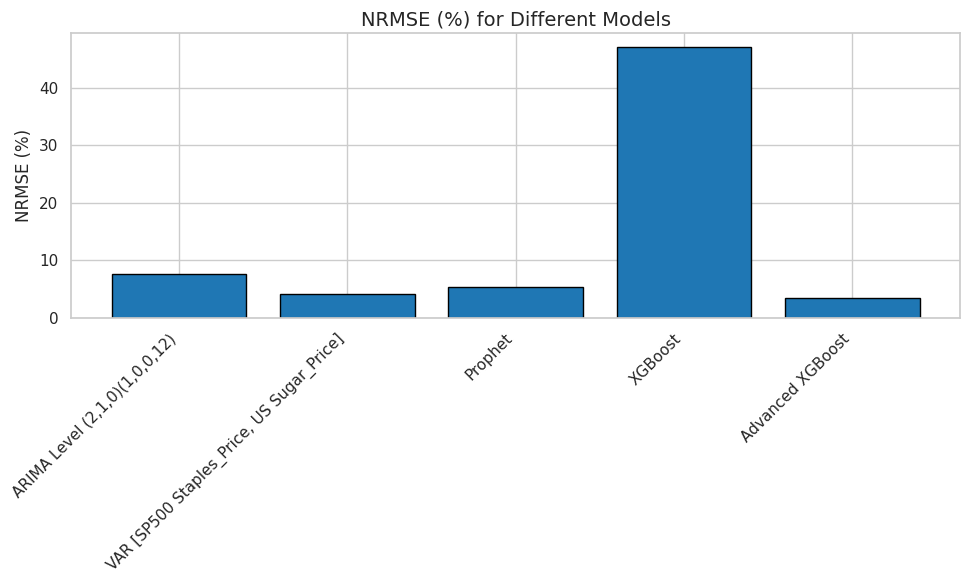

In [ ]:
# Re-import necessary libraries after reset
import matplotlib.pyplot as plt
import pandas as pd

models = [
    "ARIMA Level (2,1,0)(1,0,0,12)",
    "VAR [SP500 Staples_Price, US Sugar_Price]",
    "Prophet",
    "XGBoost",
    "Advanced XGBoost"
]

rmse_values = [16.750638, 32.647081, 42.896032, 96.738148, 25.61]
nrmse_values = [7.664792, 4.158705, 5.389626, 47.166332, 3.40]

# Create DataFrame for visualization
data = pd.DataFrame({"Model": models, "RMSE": rmse_values, "NRMSE (%)": nrmse_values})

# Plot NRMSE
plt.figure(figsize=(10, 6))
plt.bar(data["Model"], data["NRMSE (%)"], color='tab:blue', edgecolor='black')
plt.title("NRMSE (%) for Different Models", fontsize=14)
plt.ylabel("NRMSE (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

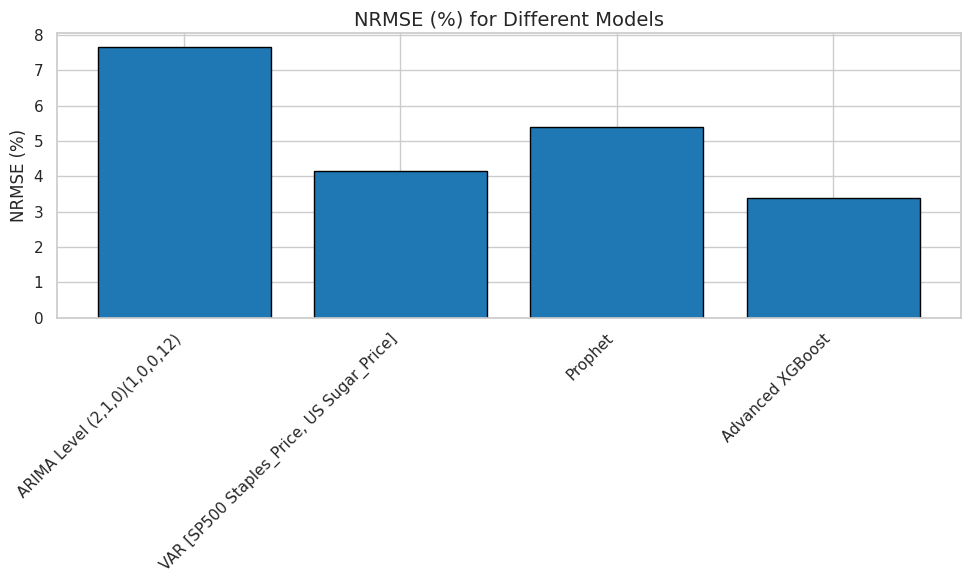

In [ ]:
# Data from screenshots for RMSE and NRMSE
models = [
    "ARIMA Level (2,1,0)(1,0,0,12)",
    "VAR [SP500 Staples_Price, US Sugar_Price]",
    "Prophet",
    "Advanced XGBoost"
]

nrmse_values = [7.664792, 4.158705, 5.389626, 3.40]

# Create DataFrame for visualization
data = pd.DataFrame({"Model": models, "NRMSE (%)": nrmse_values})

# Plot NRMSE
plt.figure(figsize=(10, 6))
plt.bar(data["Model"], data["NRMSE (%)"], color='tab:blue', edgecolor='black')
plt.title("NRMSE (%) for Different Models", fontsize=14)
plt.ylabel("NRMSE (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


We can see a slight advancde of the enhanced XGBoost model

In [ ]:
# prompt: delete the first column of dfz

# Assuming dfz is already defined as in your provided code.
# No need to re-import libraries as they are already imported in your code.

# Delete the first column of dfz
dfz = dfz.iloc[:, 1:]
dfz

Date  SP500 Staples_Price  US Sugar_Price  US Wheat_Price  \
0   1992-02-01                93.81            7.86          401.50   
1   1992-03-01                92.66            8.68          379.00   
2   1992-04-01                93.40            9.45          372.25   
3   1992-05-01                94.34           10.03          349.50   
4   1992-06-01                91.63           10.55          349.50   
..         ...                  ...             ...             ...   
390 2024-08-01               882.60           19.38          551.50   
391 2024-09-01               887.78           22.67          584.00   
392 2024-10-01               861.70           22.74          570.50   
393 2024-11-01               900.88           21.08          532.25   
394 2024-12-01               853.65           19.26          551.50   

     Treasury Yield Previous Month Mean  Oil Price Previous Month Mean  \
0                              7.091262                      19.541958   
1                              7.022268                      18.802240   
2                              7.341833                      19.008871   
3                              7.531632                      18.912397   
4                              7.482185                      20.224844   
..                                  ...                            ...   
390                            4.312579                      79.800665   
391                            4.248053                      81.884873   
392                            3.872944                      76.681184   
393                            3.735570                      70.529295   
394                            4.095196                      72.045047   

     Chinfx Previous Month Mean  Canfx Previous Month Mean  \
0                      5.422909                   1.146741   
1                      5.461407                   1.156754   
2                      5.477490                   1.182338   
3                      5.486948                   1.192424   
4                      5.509755                   1.187432   
..                          ...                        ...   
390                    7.254240                   1.370243   
391                    7.261285                   1.371050   
392                    7.147486                   1.365500   
393                    7.078677                   1.354364   
394                    7.088328                   1.375793   

     Japfx Previous Month Mean  GDP_LastMonth  Unemployment Rate_LastMonth  \
0                   128.075149    6363.102000                          7.3   
1                   125.435055    6398.989000                          7.4   
2                   127.623621    6434.876000                          7.4   
3                   132.727276    6470.763000                          7.4   
4                   133.521908    6502.722333                          7.6   
..                         ...            ...                          ...   
390                 157.831479   29374.914000                          4.2   
391                 157.654868   29483.469333                          4.2   
392                 146.277767   29592.024667                          4.1   
393                 143.205912   29700.580000                          4.1   
394                 149.854073   29700.580000                          4.2   

     Fed Funds Rate_LastMonth  
0                        4.03  
1                        4.06  
2                        3.98  
3                        3.73  
4                        3.82  
..                        ...  
390                      5.33  
391                      5.33  
392                      5.13  
393                      4.83  
394                      4.64  

[395 rows x 12 columns]

# 5. Prediction using a LLM

In [ ]:
# Install `llama-cpp` and download model
%%capture

from huggingface_hub import hf_hub_download

# install llama_cpp if not already
!python3 -c 'from llama_cpp import Llama' 2> /dev/null || (CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python'==0.2.53')
from llama_cpp import Llama

# Mistral Model
use_model = "openhermes-2.5-mistral-7b.Q5_K_M"
repo_id = "TheBloke/OpenHermes-2.5-Mistral-7B-GGUF"

model_filename = hf_hub_download(
    repo_id=repo_id,
    filename=use_model + ".gguf",
    repo_type="model",
    local_dir=".",
    token=False,
)

In [ ]:
# Instantiate the local LLM
%%capture
llamma = Llama(
    model_path=model_filename,
    n_gpu_layers=-1,
    n_ctx=8000,
    random_seed=42,
)
llamma.verbose=False

In [ ]:
# Local LLM Function
from pprint import pprint, pp, pformat


template = """<|im_start|>system
You are a quantitative analyst.<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start|>Analyst:
"""

def local_llm(prompt, verbose=False, apply_template=True, temperature=0.7, max_tokens=None, llm=llamma):
    if apply_template:
        prompt = template.format(prompt=prompt)
    if verbose:
        print(f"Prompt:\n{prompt}")
    response = llm(prompt, max_tokens=max_tokens, temperature=temperature, top_p=0.95)
    return response["choices"][0]["text"]

In [ ]:
# Column explanations for the llm
column_explanations = {
    "Date": "The date of the stock price.",
    "SP500 Staples_Price": "The current price of the SP500 Staples stock.",
    "US Sugar_Price": "The current price of the US Sugar stock.",
    "US Wheat_Price": "The current price of the US Wheat stock.",
    "Treasury Yield Previous Month Mean": "The mean treasury yield for the previous month.",
    "Oil Price Previous Month Mean	": "The mean oil price for the previous month.",
    "Chinfx Previous Month Mean": "The mean exchange rate of China vs US",
    "Canfx Previous Month Mean": "The mean exchange rate of Canada vs US",
    "Japfx Previous Month Mean": "The mean exchange rate of Japan vs US",
    "GDP_LastMonth": "The GDP of the US for the previous month.",
    "Unemployment Rate_LastMonth": "The unemployment rate for the previous month.",
    "Fed Funds Rate_LastMonth": "The federal funds rate for the previous month."
}

In [ ]:
dfz_string = dfz.to_string()

In [ ]:
# First attempt prompt
prompt = f""" This is the dataset: {dfz}
Here are the column explanations:
{column_explanations}
Use ONLY the column "SP500 Staples_Price" for your predictions
You are a financial quantitative analyst with the task of predicting next quarter's SP500 Staples_Price within the range of the dates available
Use rolling window validation of 36 months per prediction to validate your predictions.

Please write your response in a format of a JSON as {{"LLM_NRMSE_NEXT_QUATER":...}}
DO NOT WRITE ANYTHING ELSE
"""
local_llm(prompt, temperature=0,apply_template=True)

'{"LLM_NRMSE_NEXT_QUATER": 0.047}'

In [ ]:
prompt = f""" This is the dataset
{dfz}
Here are the column explanations:
{column_explanations}
Use these descriptions to analyze the dataset and answer the following question:
You are a financial quantitative analyst with the task of predicting next quarter's SP500 Staples_Price within the range of the dates available
Use rolling window validation of 36 months per prediction to validate your predictions.

Please write your response in a format of a JSON as {{"LLM_NRMSE_NEXT_QUATER":...}}
DO NOT WRITE ANYTHING ELSE
"""
local_llm(prompt, temperature=0,apply_template=True)

'{"LLM_NRMSE_NEXT_QUATER": 0.047}'

## Chain-of-thought prompting

In [ ]:

prompt = f""" This is the dataset
{dfz}
Here are the column explanations:
{column_explanations}
Use these descriptions to analyze the dataset and answer the following question:
You are a financial quantitative analyst with the task of predicting next quarter's SP500 Staples_Price within the range of the dates available

Please write your response in a format of a JSON as {{"LLM_NRMSE_NEXT_QUATER":...}}
Instructions:
1. Analyze the trends in the data over time.
2. Make an informed prediction for the next quarter's SP500 Staples_Price within the range of the dates available.
3. Use rolling window validation of 36 months per prediction to validate your predictions.
4. Provide the final answer strictly in JSON format as: {{"LLM_NRMSE_NEXT_QUATER":...}}
DO NOT WRITE ANYTHING ELSE
"""
local_llm(prompt, temperature=0,apply_template=True)

'{"LLM_NRMSE_NEXT_QUATER": 0.067}'

Trial and error process:
We first let the model only predict based on previous prices of the stock. We then included additional variables which apparently did not change the outcomd. Lastly, we used chain of thought prompting which unfortunately resulted in a lower validity.

# 6. Comparative Analyses

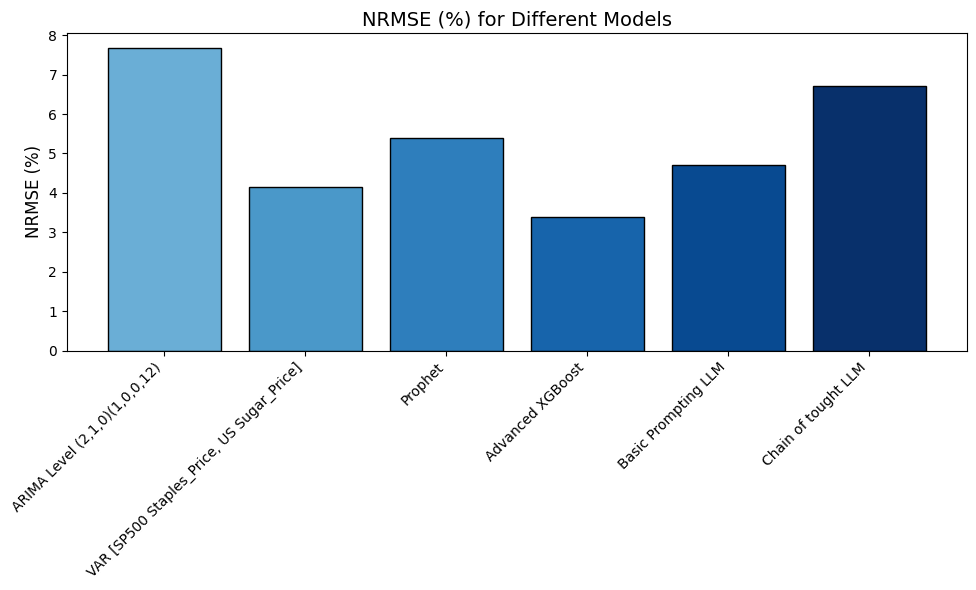

In [7]:
models = [
    "ARIMA Level (2,1,0)(1,0,0,12)",
    "VAR [SP500 Staples_Price, US Sugar_Price]",
    "Prophet",
    "Advanced XGBoost",
    "Basic Prompting LLM",
    "Chain of tought LLM"
]

nrmse_values = [7.664792, 4.158705, 5.389626, 3.40, 4.7, 6.7]

# Create DataFrame for visualization
data = pd.DataFrame({"Model": models, "NRMSE (%)": nrmse_values})

# Generate a colormap with a range of blue tones
num_bars = len(models)
colors = plt.cm.Blues(np.linspace(0.5, 1, num_bars))

# Plot NRMSE with different color tones
plt.figure(figsize=(10, 6))
plt.bar(data["Model"], data["NRMSE (%)"], color=colors, edgecolor='black')
plt.title("NRMSE (%) for Different Models", fontsize=14)
plt.ylabel("NRMSE (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Altough the advanced XGBoost is still the most accurate, the LLM's performed well.

# 7: Impact of Forecast Horizon on Model Accuracy